# Imports
to add
- for roll -- show % contango vs backwardation and maybe highlight periods
- short term MA (rolling 1/2) long term value (roll M12/13): see book for value definition
- Maybe use it as a stop loss strategy replacement
- ln returns
- consider better MA set like 5/20, 10/100, 20,250
- split all into portfolios but put on same graph



In [1]:
# ---------------------------------------------------------------------
# Imports
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D  # noqa
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import re

import sys, os
from pathlib import Path

# 1) where we are right now
CWD = Path.cwd()  # /Users/.../Systematic_Energy_Trading/futures_strategies

# 2) project root = parent of current folder
PROJECT_ROOT = CWD.parent  # /Users/.../Systematic_Energy_Trading

# 3) put *project root* at the very front of sys.path
sys.path.insert(0, str(PROJECT_ROOT))

# 4) quick check
print("CWD:", CWD)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("rolling.py exists?:", (PROJECT_ROOT / "energy/strategies/rolling.py").exists())



from energy.strategies.rolling import (
    rolling_pnl,
    roll_EL,
    RollingStrategy,
    roll_EOM_NGL,
    roll_EOM_EOM_expiry,
    roll_EOM_midmonth_expiry,
    roll_EOM_dynamic_brent,
)
from energy.strategies.momentum import (
    momentum,
    momentum_ma_simple,
    momentum_ma_ewma
)

from energy.strategies.portfolios import (
    equal_weight_static, risk_parity_static, risk_parity_dynamic, mvo
)
from energy.strategies.carry import carry
from energy.analytics.metrics import metrics
from energy.preprocess.expiry_calendar import expiry_calendar
from energy.preprocess.read_data import read_data
from energy.preprocess.drop_dupes import drop_dupes

plt.style.use("seaborn-v0_8-whitegrid")

data_path = "../data/Commods.xlsx"
calendar_path = "../data/expiry_calendars.xlsx"



CWD: /Users/markbogorad/Desktop/Quant_Projects/Systematic_Energy_Trading/futures_strategies
PROJECT_ROOT: /Users/markbogorad/Desktop/Quant_Projects/Systematic_Energy_Trading
rolling.py exists?: True


# Set Commodities (6-pack+NGLs)
- Parameters for Scaling & T-cost

In [2]:
COMMODITIES = {
    "Propane": ("BAP", 100, 1000, 0.001),
    "Ethane":  ("CAP", 100, 1000, 0.001),
    "Butane":  ("DAE", 100, 1000, 0.001),
    "WTI":     ("CL", 100, 1000, 0.01),
    "Brent":   ("CO", 100, 1000, 0.01),
    "ULSD":    ("HO", 100, 1000, 0.05),
    "RBOB":    ("XB", 100, 1000, 0.02),
    "Gasoil":  ("QS", 100, 1000, 0.02), 
    "Natgas":  ("NG", 100, 1000, 0.001), 
}

NORMALIZATION = {
    # NGLs are quoted in ¢/gal  → $/bbl  = c/gal 100 * 0.42
    "Propane": 0.42*100,
    "Ethane":  0.42*100,
    "Butane":  0.42*100,

    # Refineds are quoted in $/gal → $/bbl = $/gal * 42, 
    # since already scaling by 100 per lot, the multiplier is 0.42
    "RBOB":   0.42,
    "ULSD":   0.42,

    # Crudes already in $/bbl
    "WTI":     1.0,
    "Brent":   1.0,

    # ICE Gasoil in $/metric ton → $/bbl ≈ $/ton / 7.45
    "Gasoil":  1.0 / 7.45,   # ≈ 0.134228

    # Natgas in $/MMBtu → $/bbl-equiv ≈ $/MMBtu * 5.8
    "Natgas":  5.8,
}

roll_window = 5

CLEAN_DATA = {}
all_ma_results = {}
all_carry_results = {}


# Rolling Futures + Drop Dupes on All

In [3]:
_FCOL_PATTERN = re.compile(r"^F\d+$")

def load_prices(commodity_name: str, ticker: str, *, normalize: bool = True) -> pd.DataFrame:
    sheet_name = f"{commodity_name} ({ticker})"
    df = read_data(data_path, sheet=sheet_name)
    df = drop_dupes(df).sort_index()

    if normalize:
        scale = NORMALIZATION.get(commodity_name, 1.0)
        if scale != 1.0:
            fcols = [c for c in df.columns if _FCOL_PATTERN.match(str(c))]
            if fcols:
                df.loc[:, fcols] = df[fcols] * scale
        # remember what we did
        df.attrs["norm_scale"] = scale
    else:
        df.attrs["norm_scale"] = 1.0

    return df


def load_expiry(ticker: str) -> pd.DatetimeIndex:
    return expiry_calendar(ticker, calendar_path)



## NGLs Roll

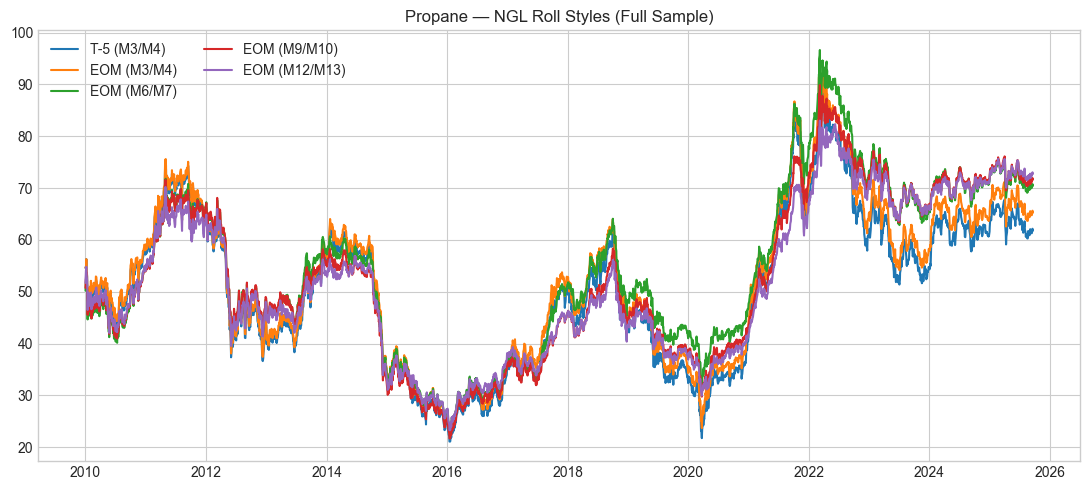

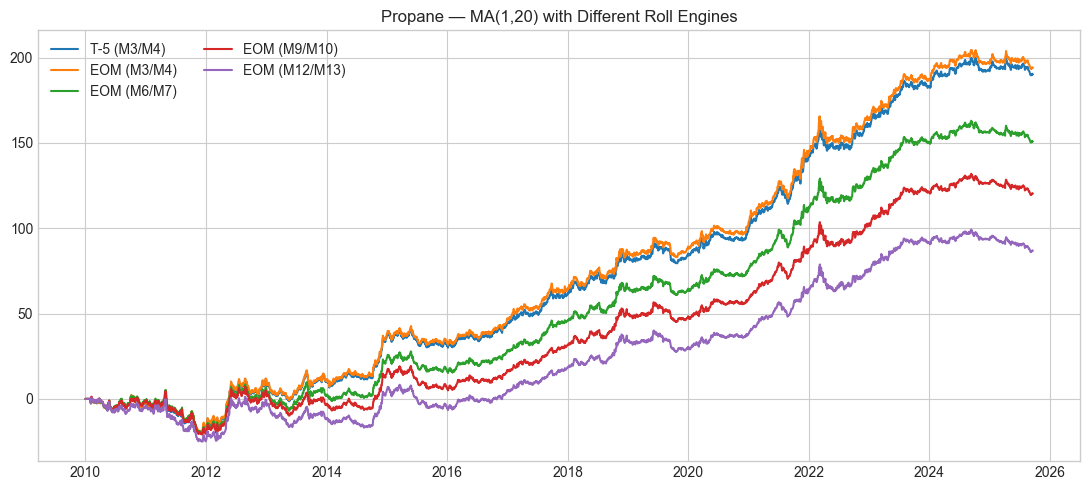

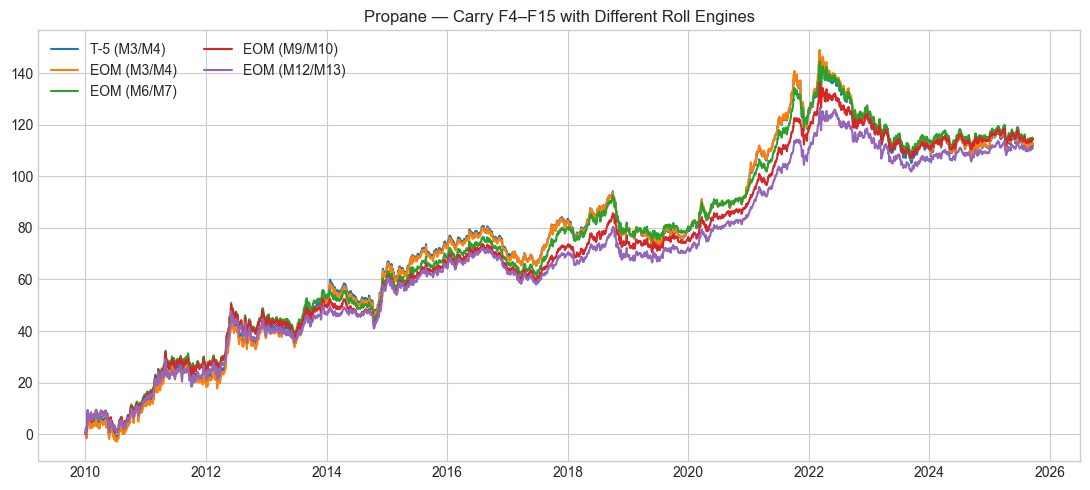

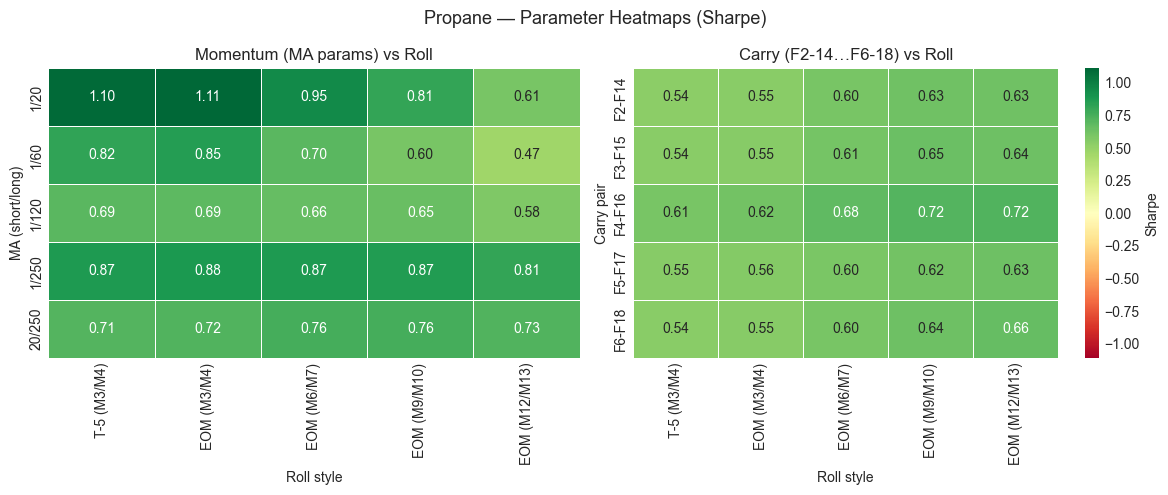

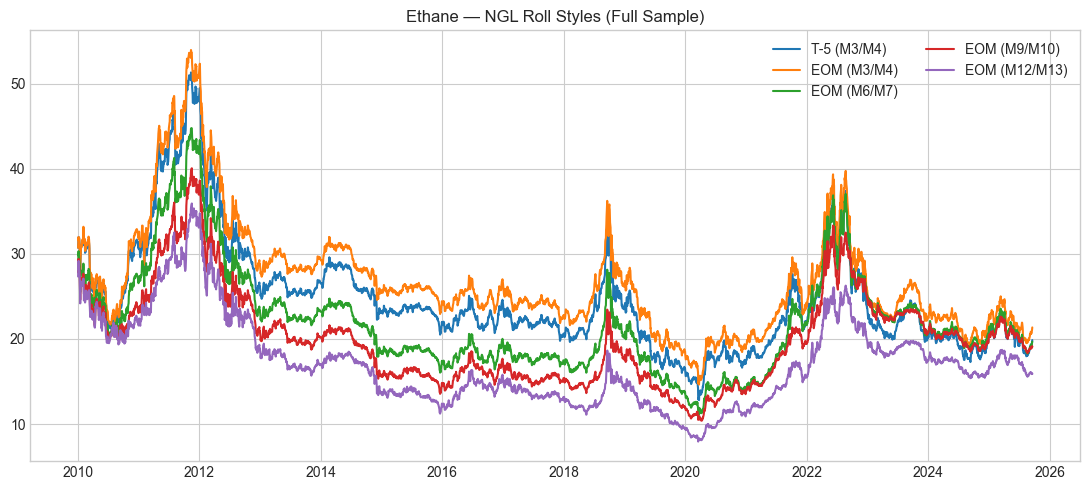

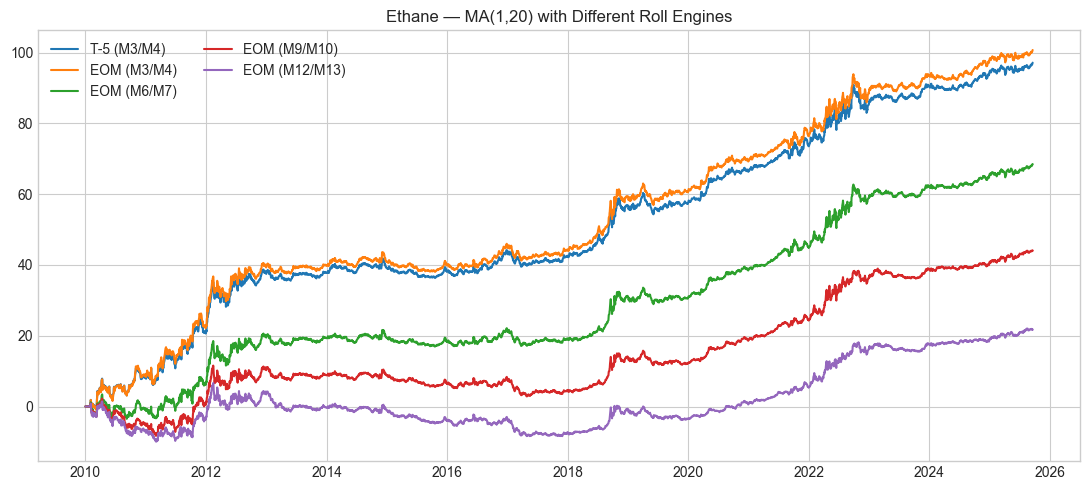

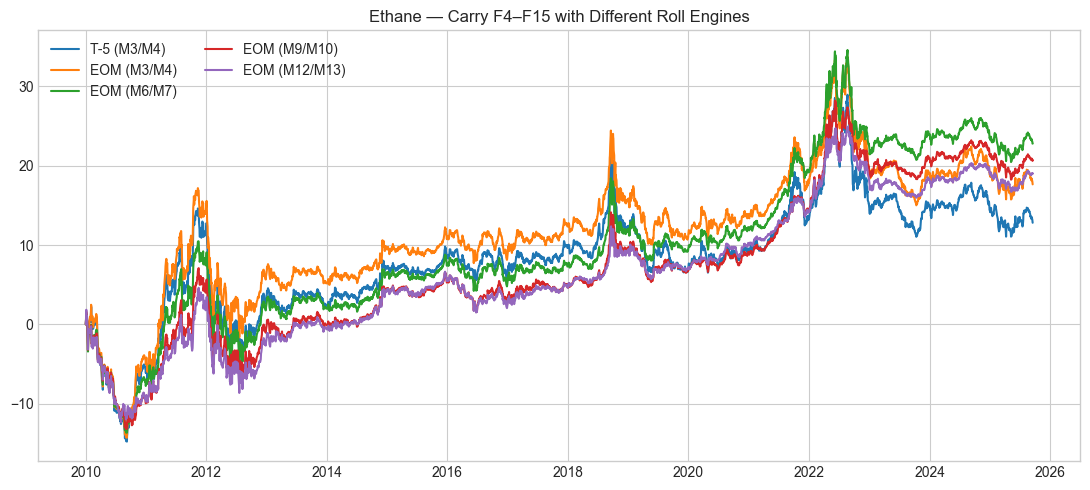

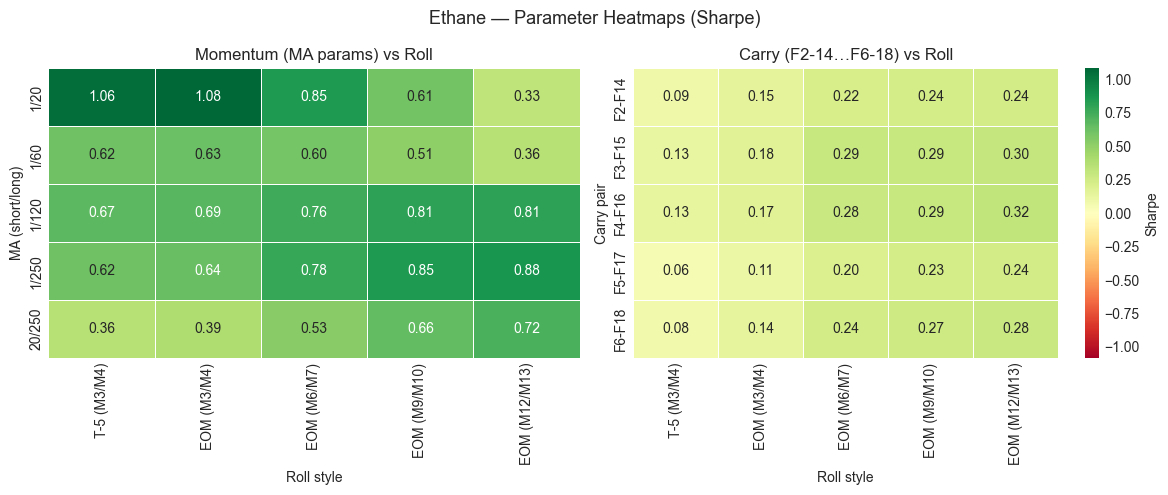

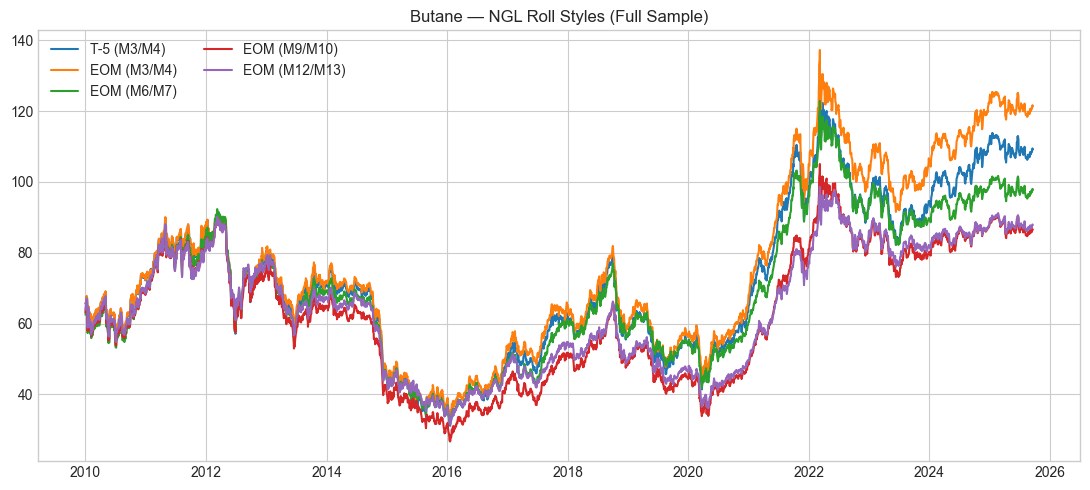

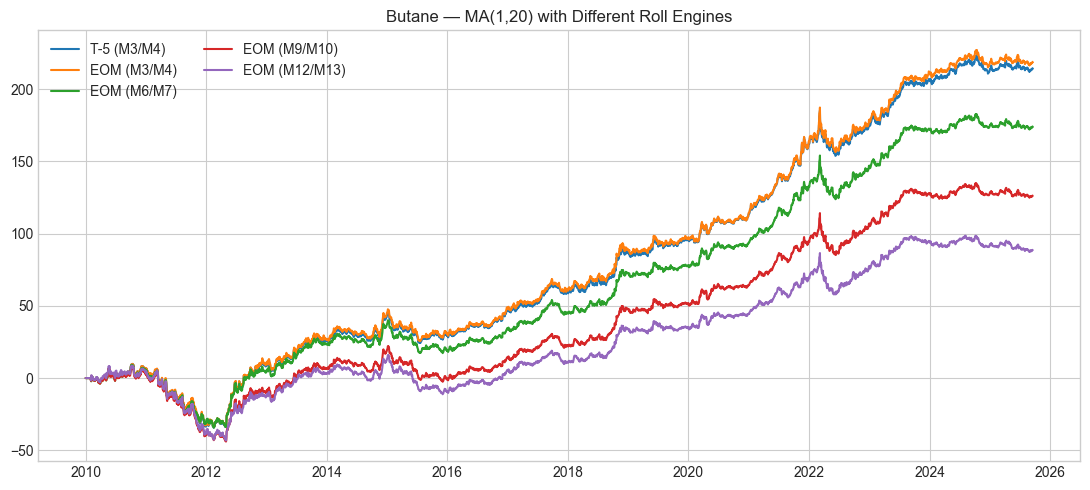

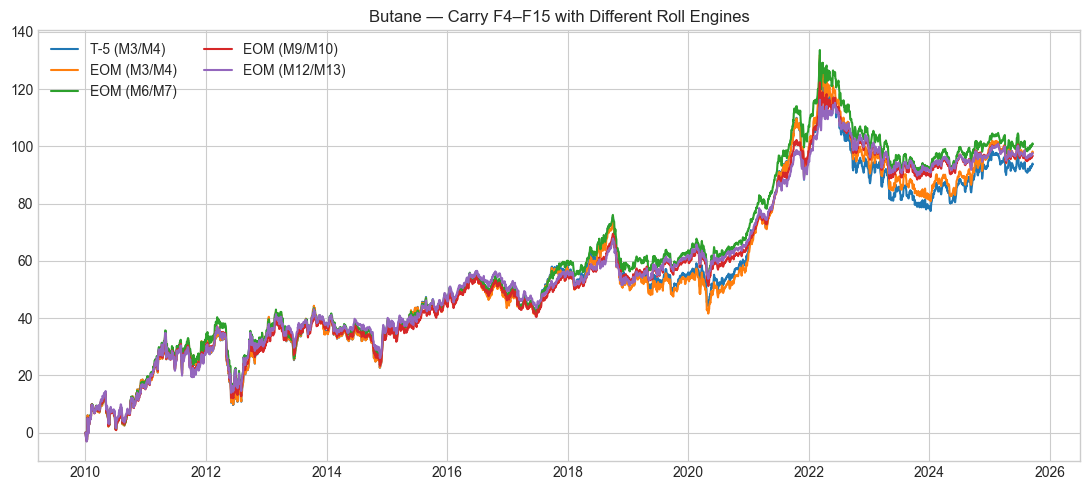

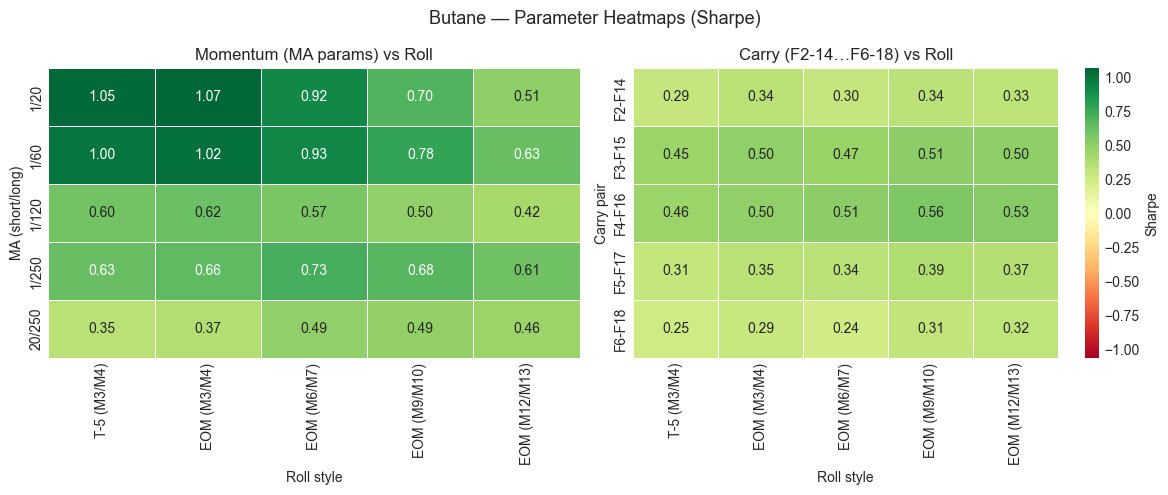

Total PnL   Total Cost  APL/unit  \
commodity style                                                  
Propane   T-5 (M3/M4)      711,438.0000 -37,800.0000    0.4526   
          EOM (M3/M4)    1,059,534.0000 -37,800.0000    0.6740   
          EOM (M6/M7)    2,022,510.0000 -37,800.0000    1.2865   
          EOM (M9/M10)   2,084,628.0000 -37,800.0000    1.3261   
          EOM (M12/M13)  2,098,782.0000 -37,800.0000    1.3351   
Ethane    T-5 (M3/M4)   -1,084,650.0000 -37,800.0000   -0.6900   
          EOM (M3/M4)     -936,180.0000 -37,800.0000   -0.5955   
          EOM (M6/M7)     -923,874.0000 -37,800.0000   -0.5877   
          EOM (M9/M10)    -872,508.0000 -37,800.0000   -0.5550   
          EOM (M12/M13) -1,144,836.0000 -37,800.0000   -0.7282   
Butane    T-5 (M3/M4)    4,352,586.0000 -37,800.0000    2.7687   
          EOM (M3/M4)    5,571,384.0000 -37,800.0000    3.5440   
          EOM (M6/M7)    3,525,606.0000 -37,800.0000    2.2427   
          EOM (M9/M10)   2,333,016.0000 -37,800.0000    1.4841   
          EOM (M12/M13)  2,385,852.0000 -37,800.0000    1.5177   

                         Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
commodity style                                                            
Propane   T-5 (M3/M4)           11.0975  0.0408   -0.4473  1.0118 15.7205  
          EOM (M3/M4)           11.1785  0.0603   -0.4381  1.5386 15.7205  
          EOM (M6/M7)           10.1445  0.1268   -0.4000  3.2161 15.7205  
          EOM (M9/M10)           9.5374  0.1390   -0.4131  3.2102 15.7205  
          EOM (M12/M13)          9.1763  0.1455   -0.3960  3.3717 15.7205  
Ethane    T-5 (M3/M4)            5.9244 -0.1165   -0.3193 -2.1611 15.7205  
          EOM (M3/M4)            5.9896 -0.0994   -0.3189 -1.8672 15.7205  
          EOM (M6/M7)            5.2084 -0.1128   -0.2905 -2.0231 15.7205  
          EOM (M9/M10)           4.6872 -0.1184   -0.2641 -2.1014 15.7205  
          EOM (M12/M13)          4.3009 -0.1693   -0.2576 -2.8270 15.7205  
Butane    T-5 (M3/M4)           13.0222  0.2126   -0.4793  5.7762 15.7205  
          EOM (M3/M4)           13.1332  0.2699   -0.4646  7.6275 15.7205  
          EOM (M6/M7)           12.0611  0.1859   -0.4678  4.7940 15.7205  
          EOM (M9/M10)          11.5870  0.1281   -0.4994  2.9714 15.7205  
          EOM (M12/M13)         11.2043  0.1355   -0.4651  3.2634 15.7205

Total PnL  Total Cost  APL/unit  \
commodity style         strategy                                         
Propane   T-5 (M3/M4)   MA(1,20) 19,012,902.0000 75,300.0000   12.0943   
          EOM (M3/M4)   MA(1,20) 19,393,086.0000 71,100.0000   12.3361   
          EOM (M6/M7)   MA(1,20) 15,079,476.0000 71,100.0000    9.5922   
          EOM (M9/M10)  MA(1,20) 12,024,312.0000 71,100.0000    7.6488   
          EOM (M12/M13) MA(1,20)  8,674,308.0000 71,100.0000    5.5178   
Ethane    T-5 (M3/M4)   MA(1,20)  9,715,624.0000 75,500.0000    6.1802   
          EOM (M3/M4)   MA(1,20) 10,074,108.0000 74,100.0000    6.4082   
          EOM (M6/M7)   MA(1,20)  6,850,314.0000 74,100.0000    4.3576   
          EOM (M9/M10)  MA(1,20)  4,405,410.0000 74,100.0000    2.8023   
          EOM (M12/M13) MA(1,20)  2,172,228.0000 74,100.0000    1.3818   
Butane    T-5 (M3/M4)   MA(1,20) 21,413,726.0000 75,700.0000   13.6215   
          EOM (M3/M4)   MA(1,20) 21,855,070.0000 72,500.0000   13.9022   
          EOM (M6/M7)   MA(1,20) 17,381,314.0000 72,500.0000   11.0564   
          EOM (M9/M10)  MA(1,20) 12,608,812.0000 72,500.0000    8.0206   
          EOM (M12/M13) MA(1,20)  8,851,534.0000 72,500.0000    5.6306   

                                  Std Dev (ann.)  Sharpe  Drawdown      RoD  \
commodity style         strategy                                              
Propane   T-5 (M3/M4)   MA(1,20)         10.9996  1.0995   -0.2348  51.5191   
          EOM (M3/M4)   MA(1,20)         11.0772  1.1136   -0.2333  52.8690   
          EOM (M6/M7)   MA(1,20)         10.0459  0.9548   -0.2413  39.7543   
          EOM (M9/M10)  MA(1,20)          9.4362  0.8106   -0.2420  31.6005   
          EOM (M12/M13) MA(1,20)          9.0761  0.6080   -0.2543  21.7011   
Ethane    T-5 (M3/M4)   MA(1,20)          5.8472  1.0570   -0.0570 108.4929   
          EOM (M3/M4)   MA(1,20)          5.9114  1.0840   -0.0568 112.8327   
          EOM (M6/M7)   MA(1,20)          5.1430  0.8473   -0.0668  65.2678   
          EOM (M9/M10)  MA(1,20)          4.6152  0.6072   -0.1028  27.2670   
          EOM (M12/M13) MA(1,20)          4.2106  0.3282   -0.1407   9.8172   
Butane    T-5 (M3/M4)   MA(1,20)         12.8972  1.0562   -0.4021  33.8783   
          EOM (M3/M4)   MA(1,20)         13.0087  1.0687   -0.3985  34.8897   
          EOM (M6/M7)   MA(1,20)         11.9378  0.9262   -0.3986  27.7406   
          EOM (M9/M10)  MA(1,20)         11.4466  0.7007   -0.4783  16.7673   
          EOM (M12/M13) MA(1,20)         11.0625  0.5090   -0.4769  11.8069   

                                   Years  
commodity style         strategy          
Propane   T-5 (M3/M4)   MA(1,20) 15.7205  
          EOM (M3/M4)   MA(1,20) 15.7205  
          EOM (M6/M7)   MA(1,20) 15.7205  
          EOM (M9/M10)  MA(1,20) 15.7205  
          EOM (M12/M13) MA(1,20) 15.7205  
Ethane    T-5 (M3/M4)   MA(1,20) 15.7205  
          EOM (M3/M4)   MA(1,20) 15.7205  
          EOM (M6/M7)   MA(1,20) 15.7205  
          EOM (M9/M10)  MA(1,20) 15.7205  
          EOM (M12/M13) MA(1,20) 15.7205  
Butane    T-5 (M3/M4)   MA(1,20) 15.7205  
          EOM (M3/M4)   MA(1,20) 15.7205  
          EOM (M6/M7)   MA(1,20) 15.7205  
          EOM (M9/M10)  MA(1,20) 15.7205  
          EOM (M12/M13) MA(1,20) 15.7205

Total PnL  Total Cost  APL/unit  \
commodity style         strategy                                            
Propane   T-5 (M3/M4)   Carry F4-15 11,182,562.0000 10,900.0000    7.1133   
          EOM (M3/M4)   Carry F4-15 11,260,946.0000 10,300.0000    7.1632   
          EOM (M6/M7)   Carry F4-15 11,460,992.0000 10,300.0000    7.2905   
          EOM (M9/M10)  Carry F4-15 11,403,200.0000 10,300.0000    7.2537   
          EOM (M12/M13) Carry F4-15 11,080,010.0000 10,300.0000    7.0481   
Ethane    T-5 (M3/M4)   Carry F4-15  1,280,788.0000 13,400.0000    0.8147   
          EOM (M3/M4)   Carry F4-15  1,764,946.0000 12,200.0000    1.1227   
          EOM (M6/M7)   Carry F4-15  2,278,438.0000 12,200.0000    1.4493   
          EOM (M9/M10)  Carry F4-15  2,069,110.0000 12,200.0000    1.3162   
          EOM (M12/M13) Carry F4-15  1,903,588.0000 12,200.0000    1.2109   
Butane    T-5 (M3/M4)   Carry F4-15  9,374,526.0000 16,800.0000    5.9632   
          EOM (M3/M4)   Carry F4-15  9,795,502.0000 14,900.0000    6.2310   
          EOM (M6/M7)   Carry F4-15 10,077,658.0000 14,900.0000    6.4105   
          EOM (M9/M10)  Carry F4-15  9,666,058.0000 14,900.0000    6.1487   
          EOM (M12/M13) Carry F4-15  9,751,108.0000 14,900.0000    6.2028   

                                     Std Dev (ann.)  Sharpe  Drawdown     RoD  \
commodity style         strategy                                                
Propane   T-5 (M3/M4)   Carry F4-15         11.0791  0.6421   -0.1690 42.0954   
          EOM (M3/M4)   Carry F4-15         11.1601  0.6419   -0.1693 42.3074   
          EOM (M6/M7)   Carry F4-15         10.1254  0.7200   -0.1482 49.1812   
          EOM (M9/M10)  Carry F4-15          9.5184  0.7621   -0.1243 58.3662   
          EOM (M12/M13) Carry F4-15          9.1606  0.7694   -0.1095 64.3493   
Ethane    T-5 (M3/M4)   Carry F4-15          5.9212  0.1376   -0.1677  4.8590   
          EOM (M3/M4)   Carry F4-15          5.9861  0.1875   -0.1636  6.8625   
          EOM (M6/M7)   Carry F4-15          5.2052  0.2784   -0.1485  9.7588   
          EOM (M9/M10)  Carry F4-15          4.6849  0.2809   -0.1455  9.0432   
          EOM (M12/M13) Carry F4-15          4.2987  0.2817   -0.1392  8.6996   
Butane    T-5 (M3/M4)   Carry F4-15         13.0108  0.4583   -0.2240 26.6233   
          EOM (M3/M4)   Carry F4-15         13.1222  0.4748   -0.2204 28.2664   
          EOM (M6/M7)   Carry F4-15         12.0483  0.5321   -0.1841 34.8254   
          EOM (M9/M10)  Carry F4-15         11.5743  0.5312   -0.1831 33.5796   
          EOM (M12/M13) Carry F4-15         11.1912  0.5543   -0.1686 36.7982   

                                      Years  
commodity style         strategy             
Propane   T-5 (M3/M4)   Carry F4-15 15.7205  
          EOM (M3/M4)   Carry F4-15 15.7205  
          EOM (M6/M7)   Carry F4-15 15.7205  
          EOM (M9/M10)  Carry F4-15 15.7205  
          EOM (M12/M13) Carry F4-15 15.7205  
Ethane    T-5 (M3/M4)   Carry F4-15 15.7205  
          EOM (M3/M4)   Carry F4-15 15.7205  
          EOM (M6/M7)   Carry F4-15 15.7205  
          EOM (M9/M10)  Carry F4-15 15.7205  
          EOM (M12/M13) Carry F4-15 15.7205  
Butane    T-5 (M3/M4)   Carry F4-15 15.7205  
          EOM (M3/M4)   Carry F4-15 15.7205  
          EOM (M6/M7)   Carry F4-15 15.7205  
          EOM (M9/M10)  Carry F4-15 15.7205  
          EOM (M12/M13) Carry F4-15 15.7205

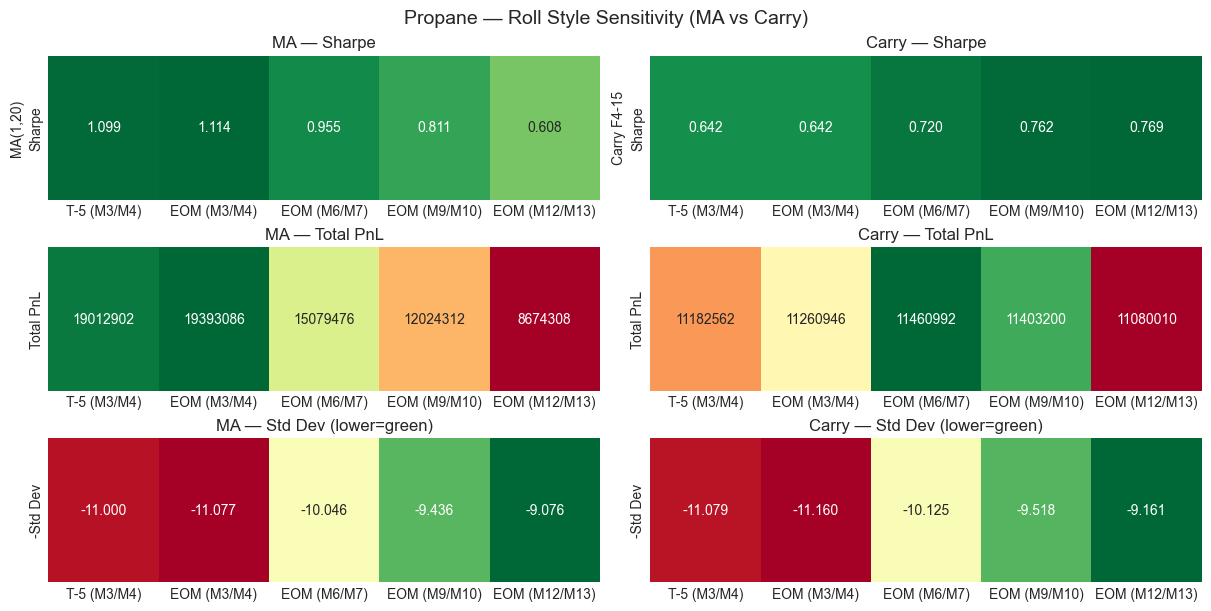

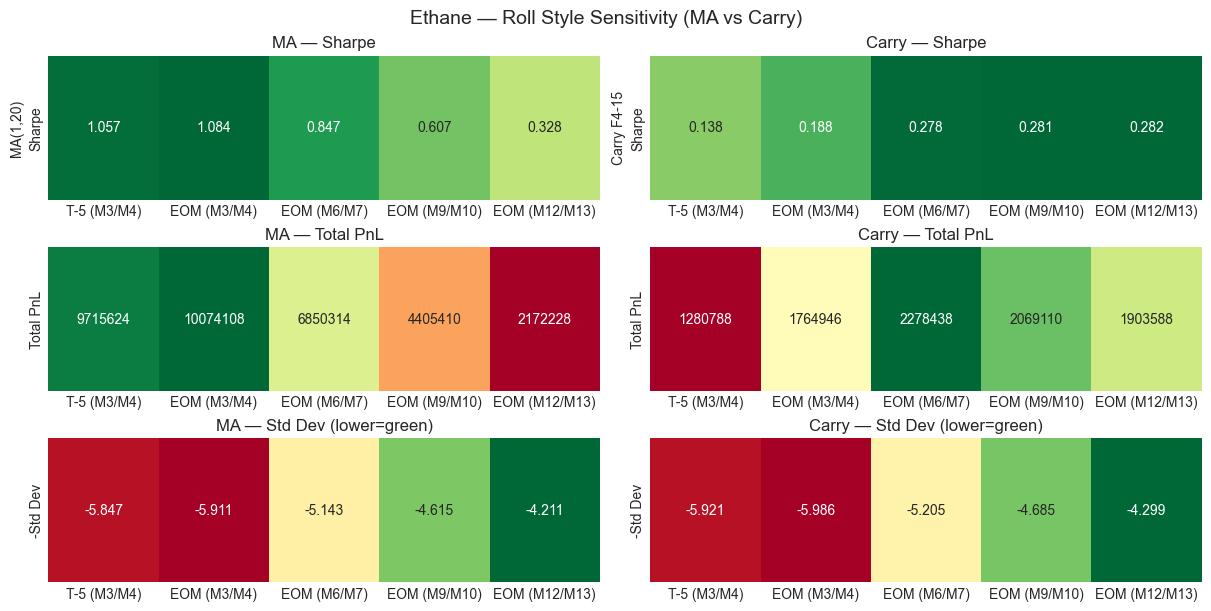

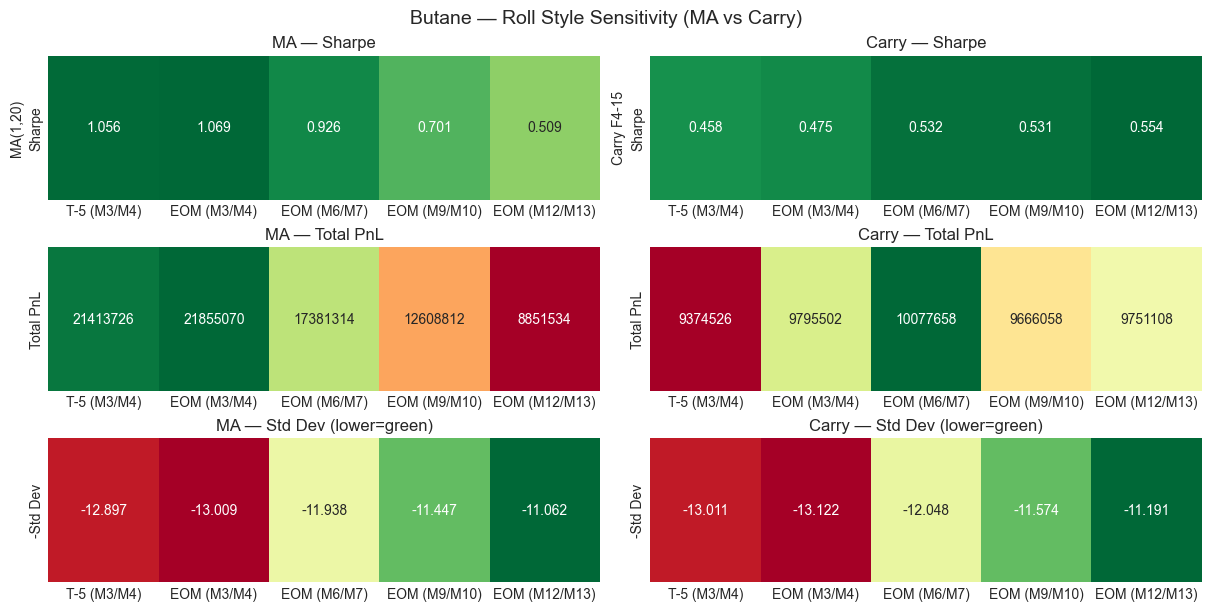

In [4]:
# ---------------------------------------------------------------------
# NGLs Roll — Propane / Ethane / Butane + MA(20) + Carry F4-15
# + PARAMETER HEATMAPS (MA grid, Carry grid) per NGL
# ---------------------------------------------------------------------
ngl_names = ["Propane", "Ethane", "Butane"]

# strategy parameter grids
ma_params = [(1, 20), (1, 60), (1, 120), (1, 250), (20, 250)]
carry_pairs = [(2, 14), (3, 15), (4, 16), (5, 17), (6, 18)]

all_ngl_roll_metrics = []     # plain roll metrics (what you already had)
all_ngl_ma_metrics = []       # MA(20) per roll-style
all_ngl_carry_metrics = []    # F4-15 carry per roll-style

for commodity_name in ngl_names:
    ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

    prices = load_prices(commodity_name, ticker)
    expiry_cal = load_expiry(ticker)

    # --- 1) T-5, M3/M4 -----------------------------------------------
    res_t5_m34 = rolling_pnl(
        prices,
        expiry_cal,
        front_col="F3",
        next_col="F4",
        roll_window=roll_window,
    )
    res_t5_m34 = roll_EL(res_t5_m34, prices, front_col="F3", t_cost=t_cost)

    # --- 2) EOM, M3/M4 -----------------------------------------------
    res_eom_m34 = roll_EOM_NGL(prices, expiry_cal, mid_col="F3", far_col="F4")
    res_eom_m34 = roll_EL(res_eom_m34, prices, front_col="F3", t_cost=t_cost)

    # --- 3) EOM, M6/M7 -----------------------------------------------
    res_eom_m67 = roll_EOM_NGL(prices, expiry_cal, mid_col="F6", far_col="F7")
    res_eom_m67 = roll_EL(res_eom_m67, prices, front_col="F6", t_cost=t_cost)

    # --- 4) EOM, M9/M10 ----------------------------------------------
    res_eom_m910 = roll_EOM_NGL(prices, expiry_cal, mid_col="F9", far_col="F10")
    res_eom_m910 = roll_EL(res_eom_m910, prices, front_col="F9", t_cost=t_cost)

    # --- 5) EOM, M12/M13 ---------------------------------------------
    res_eom_m1213 = roll_EOM_NGL(prices, expiry_cal, mid_col="F12", far_col="F13")
    res_eom_m1213 = roll_EL(res_eom_m1213, prices, front_col="F12", t_cost=t_cost)

    # --- bundle for plotting / downstream strategies -----------------
    results_for_ngl = {
        "T-5 (M3/M4)":   res_t5_m34,
        "EOM (M3/M4)":   res_eom_m34,
        "EOM (M6/M7)":   res_eom_m67,
        "EOM (M9/M10)":  res_eom_m910,
        "EOM (M12/M13)": res_eom_m1213,
    }

    # -----------------------------------------------------------------
    # 0. BASE ROLL CHART
    # -----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(results_for_ngl))

    for (label, df_res), color in zip(results_for_ngl.items(), palette):
        ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

    ax.set_title(f"{commodity_name} — NGL Roll Styles (Full Sample)")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # BASE ROLL METRICS
    # -----------------------------------------------------------------
    for label, df_res in results_for_ngl.items():
        m = metrics(df_res, contracts=contracts, units=units)
        m["commodity"] = commodity_name
        m["style"] = label
        all_ngl_roll_metrics.append(m)

    # -----------------------------------------------------------------
    # 1. MA(20) ON TOP OF EACH ROLL VARIANT
    # -----------------------------------------------------------------
    ma_results_for_ngl = {}

    for label, rolled_df in results_for_ngl.items():
        df_ma = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col="F3",
            short_ma=1,
            long_ma=20,
            t_cost=t_cost,
            epsilon=0.00,
        )
        ma_results_for_ngl[label] = df_ma

        m_ma = metrics(df_ma, contracts=contracts, units=units)
        m_ma["commodity"] = commodity_name
        m_ma["style"] = label
        m_ma["strategy"] = "MA(1,20)"
        all_ngl_ma_metrics.append(m_ma)

    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(ma_results_for_ngl))

    for (label, df_ma), color in zip(ma_results_for_ngl.items(), palette):
        ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

    ax.set_title(f"{commodity_name} — MA(1,20) with Different Roll Engines")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
    # -----------------------------------------------------------------
    carry_results_for_ngl = {}

    for label, rolled_df in results_for_ngl.items():
        if not {"F4", "F15"}.issubset(prices.columns):
            continue

        df_carry = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col="F4",
            end_col="F15",
            t_cost=t_cost,
            epsilon=0.00,
        )
        carry_results_for_ngl[label] = df_carry

        m_c = metrics(df_carry, contracts=contracts, units=units)
        m_c["commodity"] = commodity_name
        m_c["style"] = label
        m_c["strategy"] = "Carry F4-15"
        all_ngl_carry_metrics.append(m_c)

    if carry_results_for_ngl:
        fig, ax = plt.subplots(figsize=(11, 5))
        palette = sns.color_palette("tab10", len(carry_results_for_ngl))

        for (label, df_carry), color in zip(carry_results_for_ngl.items(), palette):
            ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

        ax.set_title(f"{commodity_name} — Carry F4–F15 with Different Roll Engines")
        ax.legend(loc="best", ncol=2)
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    # -----------------------------------------------------------------
    # 3. PARAMETER HEATMAPS (same color scheme — RdYlGn)
    #    Momentum: 5 MA params × 5 roll styles
    #    Carry:    5 carry pairs × 5 roll styles
    # -----------------------------------------------------------------
    # momentum grid
    ma_sharpes = pd.DataFrame(
        index=[f"{s}/{l}" for (s, l) in ma_params],
        columns=list(results_for_ngl.keys()),
        dtype=float,
    )

    for roll_name, rolled_df in results_for_ngl.items():
        for (sma, lma) in ma_params:
            df_ma_param = momentum(
                prices=prices,
                rolled_df=rolled_df,
                front_col="F3",
                short_ma=sma,
                long_ma=lma,
                t_cost=t_cost,
                epsilon=0.00,
            )
            # simple sharpe from equity
            rets = df_ma_param["equity_line"].diff().dropna()
            if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
                sh = rets.mean() / rets.std() * np.sqrt(252)
            else:
                sh = np.nan
            ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

    # carry grid
    carry_sharpes = pd.DataFrame(
        index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
        columns=list(results_for_ngl.keys()),
        dtype=float,
    )

    for roll_name, rolled_df in results_for_ngl.items():
        for (f1, f2) in carry_pairs:
            c1, c2 = f"F{f1}", f"F{f2}"
            if c1 not in prices.columns or c2 not in prices.columns:
                continue
            df_c_param = carry(
                prices=prices,
                rolled_df=rolled_df,
                front_col=c1,
                end_col=c2,
                t_cost=t_cost,
                epsilon=0.00,
            )
            rets = df_c_param["equity_line"].diff().dropna()
            if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
                sh = rets.mean() / rets.std() * np.sqrt(252)
            else:
                sh = np.nan
            carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

    # symmetric color range across both so green/red comparable
    all_vals = np.concatenate(
        [
            ma_sharpes.to_numpy().flatten(),
            carry_sharpes.to_numpy().flatten(),
        ]
    )
    all_vals = all_vals[~np.isnan(all_vals)]
    if len(all_vals):
        vlim = float(np.max(np.abs(all_vals)))
    else:
        vlim = 1.0

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{commodity_name} — Parameter Heatmaps (Sharpe)", fontsize=13)

    # momentum heatmap
    sns.heatmap(
        ma_sharpes,
        ax=axes[0],
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        center=0.0,
        vmin=-vlim,
        vmax=vlim,
        cbar=False,
        linewidths=0.5,
        linecolor="white",
    )
    axes[0].set_title("Momentum (MA params) vs Roll")
    axes[0].set_xlabel("Roll style")
    axes[0].set_ylabel("MA (short/long)")

    # carry heatmap
    sns.heatmap(
        carry_sharpes,
        ax=axes[1],
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        center=0.0,
        vmin=-vlim,
        vmax=vlim,
        cbar=True,
        cbar_kws={"label": "Sharpe"},
        linewidths=0.5,
        linecolor="white",
    )
    axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
    axes[1].set_xlabel("Roll style")
    axes[1].set_ylabel("Carry pair")

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# Combined metrics tables
# ---------------------------------------------------------------------
ngl_roll_metrics_df  = pd.DataFrame(all_ngl_roll_metrics).set_index(["commodity", "style"])
ngl_ma_metrics_df    = pd.DataFrame(all_ngl_ma_metrics).set_index(["commodity", "style", "strategy"])
ngl_carry_metrics_df = pd.DataFrame(all_ngl_carry_metrics).set_index(["commodity", "style", "strategy"])

display(ngl_roll_metrics_df)
display(ngl_ma_metrics_df)
display(ngl_carry_metrics_df)

# ---------------------------------------------------------------------
# ONE FIGURE PER NGL
# layout: 3 rows (Sharpe, Total PnL, StdDev) x 2 cols (MA, Carry)
# ---------------------------------------------------------------------
styles_order = ["T-5 (M3/M4)", "EOM (M3/M4)", "EOM (M6/M7)", "EOM (M9/M10)", "EOM (M12/M13)"]

for commodity_name in ngl_names:
    fig, axes = plt.subplots(
        nrows=3, ncols=2,
        figsize=(12, 6),
        constrained_layout=True
    )
    fig.suptitle(f"{commodity_name} — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

    # -----------------------------------------------------------
    # MA(1,20) slice
    # -----------------------------------------------------------
    ma_base = ngl_ma_metrics_df.loc[(commodity_name, slice(None), "MA(1,20)")]
    ma_sharpe = ma_base["Sharpe"].reindex(styles_order)
    ma_pnl    = ma_base["Total PnL"].reindex(styles_order)
    ma_std    = ma_base["Std Dev (ann.)"].reindex(styles_order)

    # 1) MA Sharpe
    ax = axes[0, 0]
    ma_sharpe_df = pd.DataFrame(
        [ma_sharpe.values],
        index=["Sharpe"],
        columns=styles_order,
    )
    sns.heatmap(
        ma_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("MA(1,20)")
    ax.set_xlabel("")
    ax.set_title("MA — Sharpe")

    # 2) MA Total PnL
    ax = axes[1, 0]
    ma_pnl_df = pd.DataFrame(
        [ma_pnl.values],
        index=["Total PnL"],
        columns=styles_order,
    )
    vmin = ma_pnl_df.min().min()
    vmax = ma_pnl_df.max().max()
    sns.heatmap(
        ma_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("MA — Total PnL")

    # 3) MA Std Dev (lower is better → show negative)
    ax = axes[2, 0]
    ma_std_df = pd.DataFrame(
        [(-ma_std).values],
        index=["-Std Dev"],
        columns=styles_order,
    )
    sns.heatmap(
        ma_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("MA — Std Dev (lower=green)")

    # -----------------------------------------------------------
    # CARRY F4-15 slice (may be missing for some NGLs)
    # -----------------------------------------------------------
    has_carry = True
    try:
        carry_base = ngl_carry_metrics_df.loc[(commodity_name, slice(None), "Carry F4-15")]
    except KeyError:
        has_carry = False

    if has_carry:
        carry_sharpe = carry_base["Sharpe"].reindex(styles_order)
        carry_pnl    = carry_base["Total PnL"].reindex(styles_order)
        carry_std    = carry_base["Std Dev (ann.)"].reindex(styles_order)

        # 1) Carry Sharpe
        ax = axes[0, 1]
        carry_sharpe_df = pd.DataFrame(
            [carry_sharpe.values],
            index=["Sharpe"],
            columns=styles_order,
        )
        sns.heatmap(
            carry_sharpe_df,
            ax=ax,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            center=0.0,
            cbar=False,
        )
        ax.set_ylabel("Carry F4-15")
        ax.set_xlabel("")
        ax.set_title("Carry — Sharpe")

        # 2) Carry Total PnL
        ax = axes[1, 1]
        carry_pnl_df = pd.DataFrame(
            [carry_pnl.values],
            index=["Total PnL"],
            columns=styles_order,
        )
        vmin = carry_pnl_df.min().min()
        vmax = carry_pnl_df.max().max()
        sns.heatmap(
            carry_pnl_df,
            ax=ax,
            annot=True,
            fmt=".0f",
            cmap="RdYlGn",
            vmin=vmin,
            vmax=vmax,
            cbar=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title("Carry — Total PnL")

        # 3) Carry Std Dev
        ax = axes[2, 1]
        carry_std_df = pd.DataFrame(
            [(-carry_std).values],
            index=["-Std Dev"],
            columns=styles_order,
        )
        sns.heatmap(
            carry_std_df,
            ax=ax,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            cbar=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title("Carry — Std Dev (lower=green)")

    else:
        for r in range(3):
            axes[r, 1].axis("off")

    plt.show()


## WTI Roll

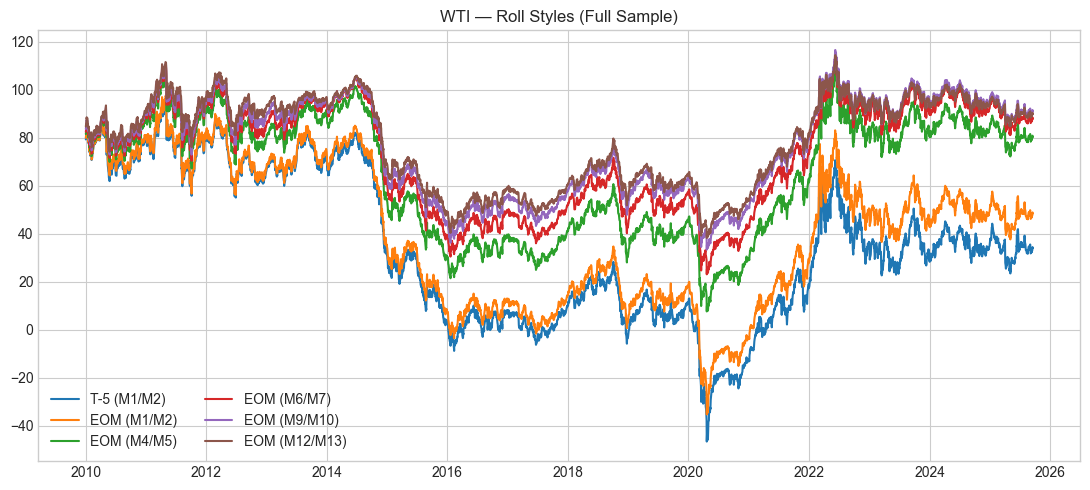

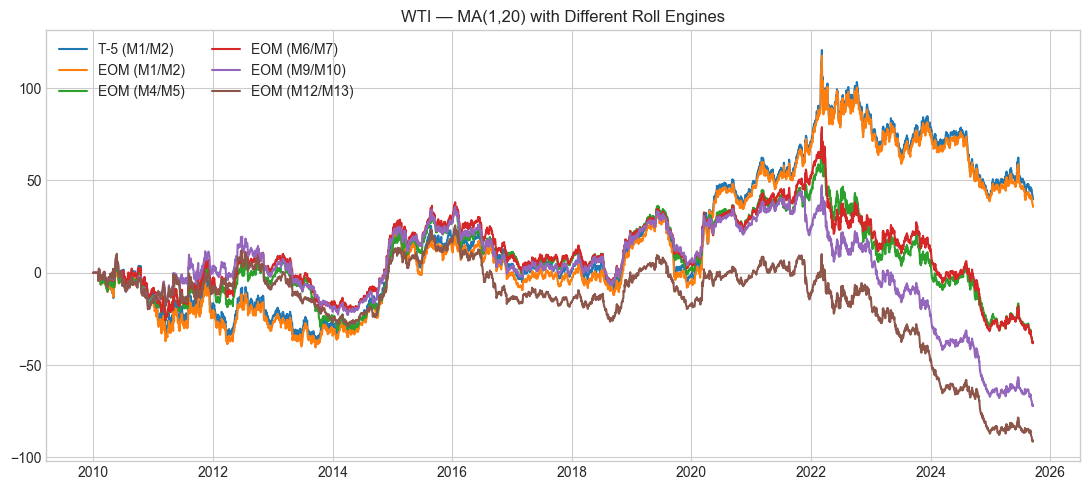

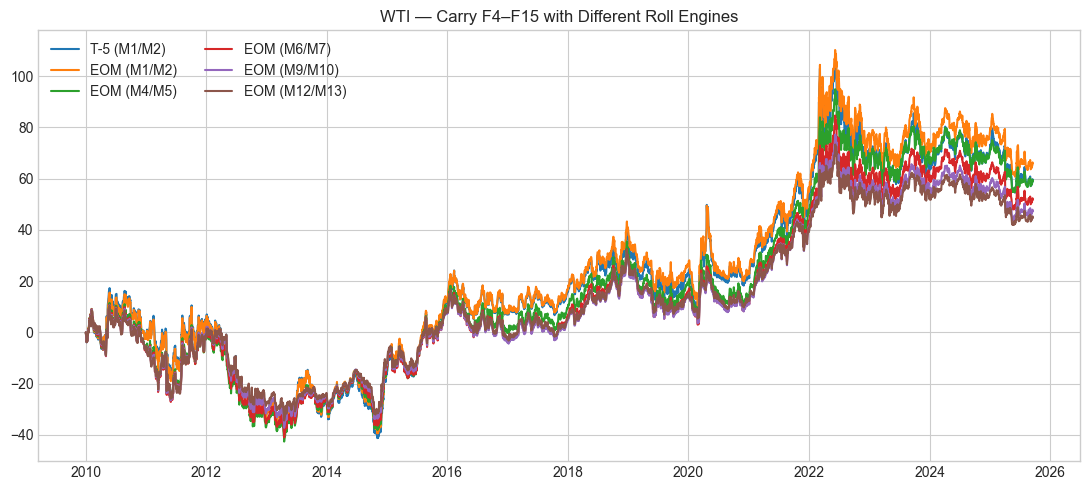

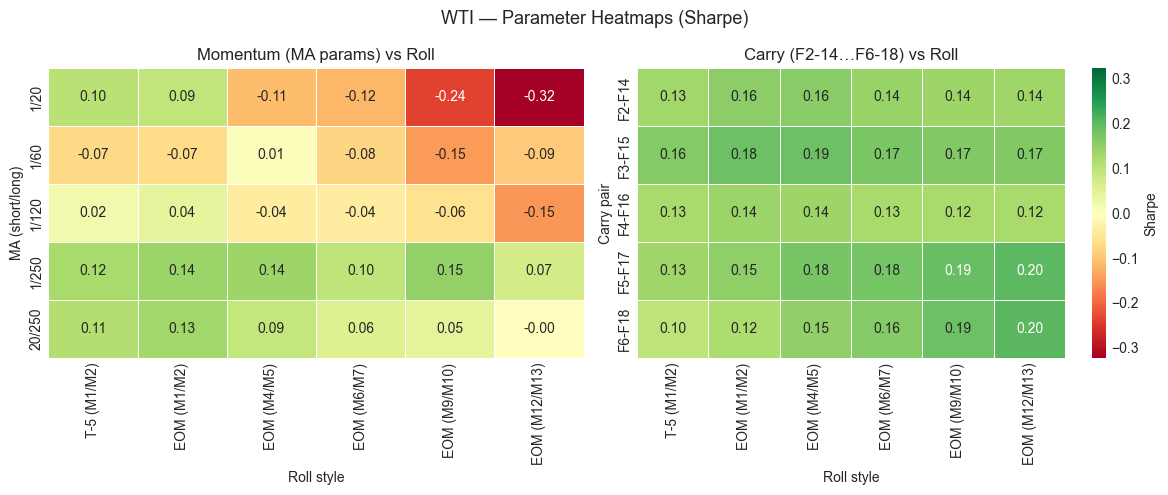

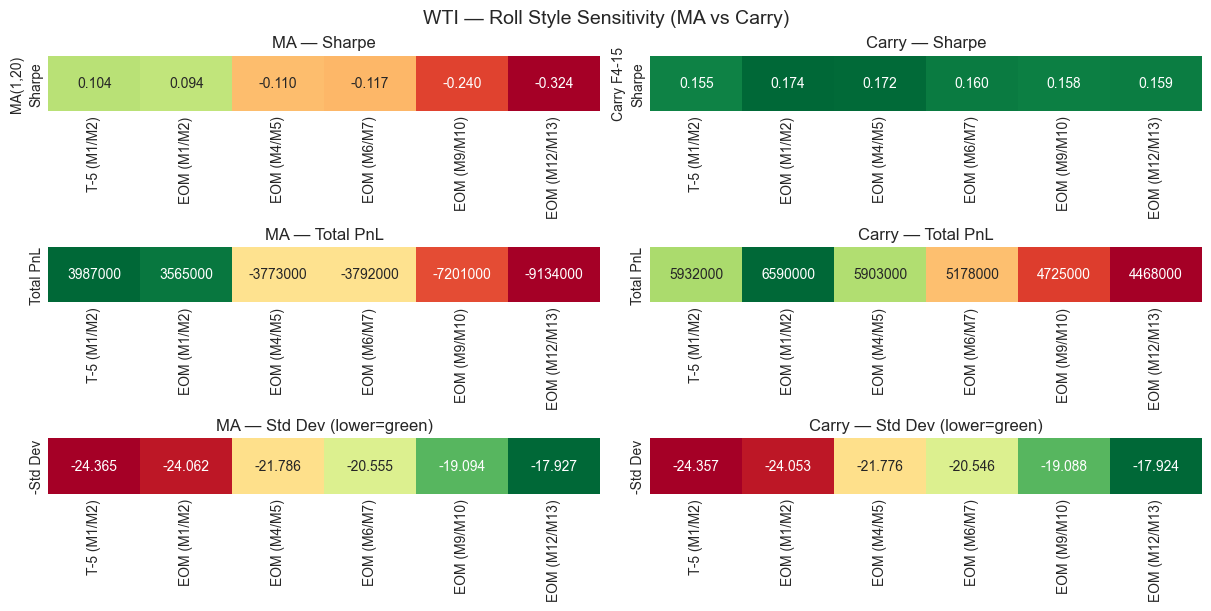

Total PnL    Total Cost  APL/unit  Std Dev (ann.)  Sharpe  \
style                                                                           
EOM (M1/M2)   -3,159,000.0000 -378,000.0000   -2.0095         24.0565 -0.0835   
EOM (M12/M13)    511,000.0000 -378,000.0000    0.3251         17.9254  0.0181   
EOM (M4/M5)     -124,000.0000 -378,000.0000   -0.0789         21.7792 -0.0036   
EOM (M6/M7)      538,000.0000 -378,000.0000    0.3422         20.5478  0.0167   
EOM (M9/M10)     730,000.0000 -378,000.0000    0.4644         19.0898  0.0243   
T-5 (M1/M2)   -4,539,000.0000 -378,000.0000   -2.8873         24.3583 -0.1185   

               Drawdown     RoD   Years  
style                                    
EOM (M1/M2)     -1.1308 -1.7770 15.7205  
EOM (M12/M13)   -0.5784  0.5620 15.7205  
EOM (M4/M5)     -0.7932 -0.0994 15.7205  
EOM (M6/M7)     -0.6812  0.5024 15.7205  
EOM (M9/M10)    -0.6090  0.7626 15.7205  
T-5 (M1/M2)     -1.2233 -2.3603 15.7205

Total PnL     Total Cost  APL/unit  \
style         strategy                                            
EOM (M1/M2)   MA(1,20)  3,565,000.0000   849,000.0000    2.2677   
EOM (M12/M13) MA(1,20) -9,134,000.0000 1,001,000.0000   -5.8102   
EOM (M4/M5)   MA(1,20) -3,773,000.0000   919,000.0000   -2.4000   
EOM (M6/M7)   MA(1,20) -3,792,000.0000   943,000.0000   -2.4121   
EOM (M9/M10)  MA(1,20) -7,201,000.0000   981,000.0000   -4.5806   
T-5 (M1/M2)   MA(1,20)  3,987,000.0000   869,000.0000    2.5362   

                        Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                    
EOM (M1/M2)   MA(1,20)         24.0616  0.0942   -0.4263  5.3199 15.7205  
EOM (M12/M13) MA(1,20)         17.9271 -0.3241   -0.9322 -6.2329 15.7205  
EOM (M4/M5)   MA(1,20)         21.7859 -0.1102   -0.6477 -3.7057 15.7205  
EOM (M6/M7)   MA(1,20)         20.5545 -0.1174   -0.6545 -3.6856 15.7205  
EOM (M9/M10)  MA(1,20)         19.0937 -0.2399   -0.8114 -5.6454 15.7205  
T-5 (M1/M2)   MA(1,20)         24.3654  0.1041   -0.4113  6.1669 15.7205

Total PnL  Total Cost  APL/unit  \
style         strategy                                           
EOM (M1/M2)   Carry F4-15 6,590,000.0000 84,000.0000    4.1920   
EOM (M12/M13) Carry F4-15 4,468,000.0000 84,000.0000    2.8421   
EOM (M4/M5)   Carry F4-15 5,903,000.0000 84,000.0000    3.7550   
EOM (M6/M7)   Carry F4-15 5,178,000.0000 84,000.0000    3.2938   
EOM (M9/M10)  Carry F4-15 4,725,000.0000 84,000.0000    3.0056   
T-5 (M1/M2)   Carry F4-15 5,932,000.0000 90,000.0000    3.7734   

                           Std Dev (ann.)  Sharpe  Drawdown    RoD   Years  
style         strategy                                                      
EOM (M1/M2)   Carry F4-15         24.0529  0.1743   -0.4759 8.8093 15.7205  
EOM (M12/M13) Carry F4-15         17.9242  0.1586   -0.4056 7.0070 15.7205  
EOM (M4/M5)   Carry F4-15         21.7764  0.1724   -0.4852 7.7382 15.7205  
EOM (M6/M7)   Carry F4-15         20.5458  0.1603   -0.4670 7.0531 15.7205  
EOM (M9/M10)  Carry F4-15         19.0884  0.1575   -0.4319 6.9588 15.7205  
T-5 (M1/M2)   Carry F4-15         24.3566  0.1549   -0.4991 7.5603 15.7205

In [5]:
# ---------------------------------------------------------------------
# WTI Roll — T-5 M1/M2 + EOM M1/M2 + EOM M4/M5 + EOM M6/M7 + EOM M9/M10 + EOM M12/M13
# + MA / Carry parameter heatmaps (WTI-specific)
# ---------------------------------------------------------------------
commodity_name = "WTI"
ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

prices = load_prices(commodity_name, ticker)
expiry_cal = load_expiry(ticker)

# WTI-specific collectors (do NOT touch NGL ones)
wti_roll_metrics_list  = []
wti_ma_metrics_list    = []
wti_carry_metrics_list = []

# --- 1) T-5, M1/M2 ---------------------------------------------------
wti_res_t5_m12 = rolling_pnl(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
    roll_window=roll_window,
)
wti_res_t5_m12 = roll_EL(wti_res_t5_m12, prices, front_col="F1", t_cost=t_cost)

# --- 2) EOM midmonth, M1/M2 ------------------------------------------
wti_res_eom_m12 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
)
wti_res_eom_m12 = roll_EL(wti_res_eom_m12, prices, front_col="F1", t_cost=t_cost)

# --- 3) EOM midmonth, M4/M5 ------------------------------------------
wti_res_eom_m45 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F4",
    next_col="F5",
)
wti_res_eom_m45 = roll_EL(wti_res_eom_m45, prices, front_col="F4", t_cost=t_cost)

# --- 4) EOM midmonth, M6/M7 ------------------------------------------
wti_res_eom_m67 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F6",
    next_col="F7",
)
wti_res_eom_m67 = roll_EL(wti_res_eom_m67, prices, front_col="F6", t_cost=t_cost)

# --- 5) EOM midmonth, M9/M10 -----------------------------------------
wti_res_eom_m910 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F9",
    next_col="F10",
)
wti_res_eom_m910 = roll_EL(wti_res_eom_m910, prices, front_col="F9", t_cost=t_cost)

# --- 6) EOM midmonth, M12/M13 ----------------------------------------
wti_res_eom_m1213 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F12",
    next_col="F13",
)
wti_res_eom_m1213 = roll_EL(wti_res_eom_m1213, prices, front_col="F12", t_cost=t_cost)

# --- bundle for plotting / downstream strategies ---------------------
wti_roll_results = {
    "T-5 (M1/M2)":    wti_res_t5_m12,
    "EOM (M1/M2)":    wti_res_eom_m12,
    "EOM (M4/M5)":    wti_res_eom_m45,
    "EOM (M6/M7)":    wti_res_eom_m67,
    "EOM (M9/M10)":   wti_res_eom_m910,
    "EOM (M12/M13)":  wti_res_eom_m1213,
}

# keep front cols per style
wti_style_front_cols = {
    "T-5 (M1/M2)":   "F1",
    "EOM (M1/M2)":   "F1",
    "EOM (M4/M5)":   "F4",
    "EOM (M6/M7)":   "F6",
    "EOM (M9/M10)":  "F9",
    "EOM (M12/M13)": "F12",
}
wti_styles_order = list(wti_roll_results.keys())

# ---------------------------------------------------------------------
# 0. BASE ROLL CHART
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(wti_roll_results))

for (label, df_res), color in zip(wti_roll_results.items(), palette):
    ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

ax.set_title("WTI — Roll Styles (Full Sample)")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# BASE ROLL METRICS (WTI-only)
# ---------------------------------------------------------------------
for label, df_res in wti_roll_results.items():
    m = metrics(df_res, contracts=contracts, units=units)
    m["commodity"] = commodity_name
    m["style"] = label
    wti_roll_metrics_list.append(m)

# ---------------------------------------------------------------------
# 1. MA(1,20) ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
wti_ma_results = {}

for label, rolled_df in wti_roll_results.items():
    front_col_for_style = wti_style_front_cols[label]

    df_ma = momentum(
        prices=prices,
        rolled_df=rolled_df,
        front_col=front_col_for_style,
        short_ma=1,
        long_ma=20,
        t_cost=t_cost,
        epsilon=0.00,
    )
    wti_ma_results[label] = df_ma

    m_ma = metrics(df_ma, contracts=contracts, units=units)
    m_ma["commodity"] = commodity_name
    m_ma["style"] = label
    m_ma["strategy"] = "MA(1,20)"
    wti_ma_metrics_list.append(m_ma)

fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(wti_ma_results))

for (label, df_ma), color in zip(wti_ma_results.items(), palette):
    ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

ax.set_title("WTI — MA(1,20) with Different Roll Engines")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
wti_carry_results = {}

for label, rolled_df in wti_roll_results.items():
    if not {"F4", "F15"}.issubset(prices.columns):
        continue

    df_carry = carry(
        prices=prices,
        rolled_df=rolled_df,
        front_col="F4",
        end_col="F15",
        t_cost=t_cost,
        epsilon=0.00,
    )
    wti_carry_results[label] = df_carry

    m_c = metrics(df_carry, contracts=contracts, units=units)
    m_c["commodity"] = commodity_name
    m_c["style"] = label
    m_c["strategy"] = "Carry F4-15"
    wti_carry_metrics_list.append(m_c)

if wti_carry_results:
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(wti_carry_results))

    for (label, df_carry), color in zip(wti_carry_results.items(), palette):
        ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

    ax.set_title("WTI — Carry F4–F15 with Different Roll Engines")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 3. PARAMETER HEATMAPS (MA grid, Carry grid) — WTI-specific
# ---------------------------------------------------------------------
wti_ma_sharpes = pd.DataFrame(
    index=[f"{s}/{l}" for (s, l) in ma_params],
    columns=wti_styles_order,
    dtype=float,
)

for roll_name, rolled_df in wti_roll_results.items():
    front_col_for_style = wti_style_front_cols[roll_name]
    for (sma, lma) in ma_params:
        df_ma_param = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col=front_col_for_style,
            short_ma=sma,
            long_ma=lma,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_ma_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        wti_ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

wti_carry_sharpes = pd.DataFrame(
    index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
    columns=wti_styles_order,
    dtype=float,
)

for roll_name, rolled_df in wti_roll_results.items():
    for (f1, f2) in carry_pairs:
        c1, c2 = f"F{f1}", f"F{f2}"
        if c1 not in prices.columns or c2 not in prices.columns:
            continue

        df_c_param = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col=c1,
            end_col=c2,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_c_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        wti_carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

# symmetric color
all_vals = np.concatenate(
    [
        wti_ma_sharpes.to_numpy().flatten(),
        wti_carry_sharpes.to_numpy().flatten(),
    ]
)
all_vals = all_vals[~np.isnan(all_vals)]
vlim = float(np.max(np.abs(all_vals))) if len(all_vals) else 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("WTI — Parameter Heatmaps (Sharpe)", fontsize=13)

sns.heatmap(
    wti_ma_sharpes,
    ax=axes[0],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
)
axes[0].set_title("Momentum (MA params) vs Roll")
axes[0].set_xlabel("Roll style")
axes[0].set_ylabel("MA (short/long)")

sns.heatmap(
    wti_carry_sharpes,
    ax=axes[1],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=True,
    cbar_kws={"label": "Sharpe"},
    linewidths=0.5,
    linecolor="white",
)
axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
axes[1].set_xlabel("Roll style")
axes[1].set_ylabel("Carry pair")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# WTI — Roll Style Sensitivity (MA vs Carry)
# ---------------------------------------------------------------------
wti_styles_order = [
    "T-5 (M1/M2)",
    "EOM (M1/M2)",
    "EOM (M4/M5)",
    "EOM (M6/M7)",
    "EOM (M9/M10)",
    "EOM (M12/M13)",
]

# build dfs from WTI-only lists
wti_roll_df  = pd.DataFrame(wti_roll_metrics_list).set_index(["commodity", "style"])
wti_ma_df    = pd.DataFrame(wti_ma_metrics_list).set_index(["commodity", "style", "strategy"])
if wti_carry_metrics_list:
    wti_carry_df = pd.DataFrame(wti_carry_metrics_list).set_index(["commodity", "style", "strategy"])
else:
    wti_carry_df = pd.DataFrame()

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(12, 6),
    constrained_layout=True
)
fig.suptitle("WTI — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

# MA slice
wti_ma_base   = wti_ma_df.loc[("WTI", slice(None), "MA(1,20)")]
wti_ma_sharpe = wti_ma_base["Sharpe"].reindex(wti_styles_order)
wti_ma_pnl    = wti_ma_base["Total PnL"].reindex(wti_styles_order)
wti_ma_std    = wti_ma_base["Std Dev (ann.)"].reindex(wti_styles_order)

# MA — Sharpe
ax = axes[0, 0]
ma_sharpe_df = pd.DataFrame(
    [wti_ma_sharpe.values],
    index=["Sharpe"],
    columns=wti_styles_order,
)
sns.heatmap(
    ma_sharpe_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.0,
    cbar=False,
)
ax.set_ylabel("MA(1,20)")
ax.set_xlabel("")
ax.set_title("MA — Sharpe")

# MA — Total PnL
ax = axes[1, 0]
ma_pnl_df = pd.DataFrame(
    [wti_ma_pnl.values],
    index=["Total PnL"],
    columns=wti_styles_order,
)
vmin = ma_pnl_df.min().min()
vmax = ma_pnl_df.max().max()
sns.heatmap(
    ma_pnl_df,
    ax=ax,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Total PnL")

# MA — Std Dev (lower=green)
ax = axes[2, 0]
ma_std_df = pd.DataFrame(
    [(-wti_ma_std).values],
    index=["-Std Dev"],
    columns=wti_styles_order,
)
sns.heatmap(
    ma_std_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Std Dev (lower=green)")

# Carry slice (if any)
has_carry = not wti_carry_df.empty
if has_carry:
    wti_carry_base = wti_carry_df.loc[("WTI", slice(None), "Carry F4-15")]
    wti_carry_sharpe = wti_carry_base["Sharpe"].reindex(wti_styles_order)
    wti_carry_pnl    = wti_carry_base["Total PnL"].reindex(wti_styles_order)
    wti_carry_std    = wti_carry_base["Std Dev (ann.)"].reindex(wti_styles_order)

    # Carry — Sharpe
    ax = axes[0, 1]
    carry_sharpe_df = pd.DataFrame(
        [wti_carry_sharpe.values],
        index=["Sharpe"],
        columns=wti_styles_order,
    )
    sns.heatmap(
        carry_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("Carry F4-15")
    ax.set_xlabel("")
    ax.set_title("Carry — Sharpe")

    # Carry — Total PnL
    ax = axes[1, 1]
    carry_pnl_df = pd.DataFrame(
        [wti_carry_pnl.values],
        index=["Total PnL"],
        columns=wti_styles_order,
    )
    vmin = carry_pnl_df.min().min()
    vmax = carry_pnl_df.max().max()
    sns.heatmap(
        carry_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Total PnL")

    # Carry — Std Dev
    ax = axes[2, 1]
    carry_std_df = pd.DataFrame(
        [(-wti_carry_std).values],
        index=["-Std Dev"],
        columns=wti_styles_order,
    )
    sns.heatmap(
        carry_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Std Dev (lower=green)")
else:
    for r in range(3):
        axes[r, 1].axis("off")

plt.show()

# ---------------------------------------------------------------------
# FINAL: WTI-only metrics tables
# ---------------------------------------------------------------------
wti_roll_metrics_df  = wti_roll_df.loc["WTI"].sort_index()
wti_ma_metrics_df    = wti_ma_df.loc[("WTI", slice(None), slice(None))].sort_index()
try:
    wti_carry_metrics_df = wti_carry_df.loc[("WTI", slice(None), slice(None))].sort_index()
except KeyError:
    wti_carry_metrics_df = pd.DataFrame()

display(wti_roll_metrics_df)
display(wti_ma_metrics_df)
display(wti_carry_metrics_df)


## Brent Roll

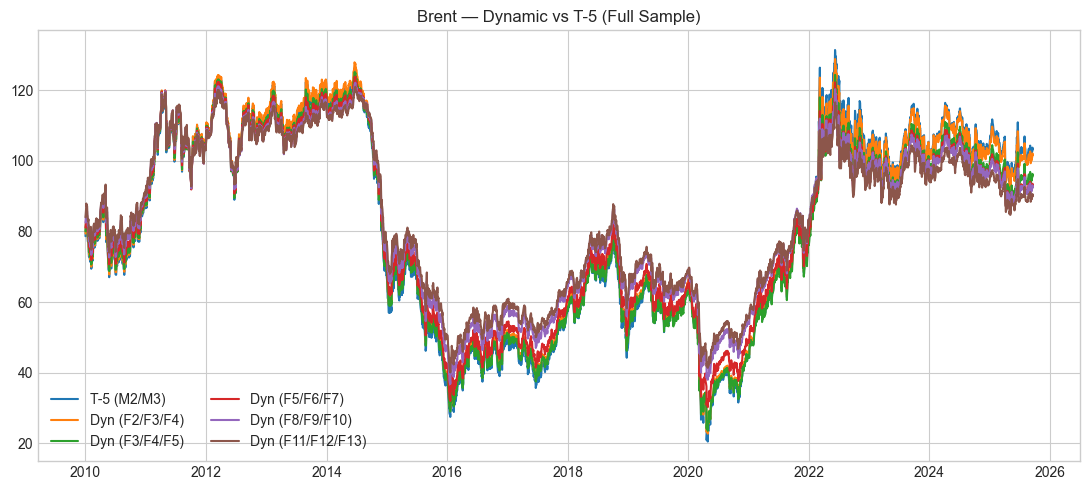

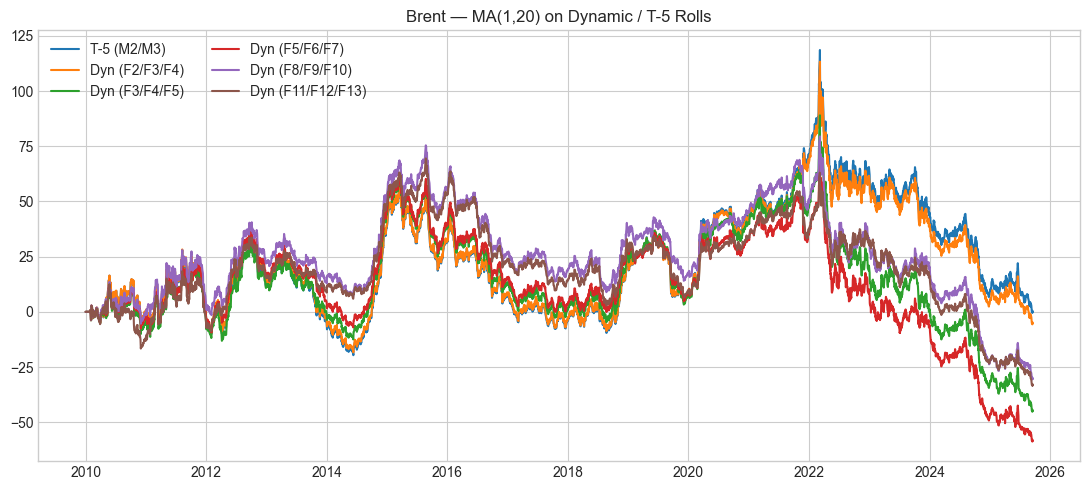

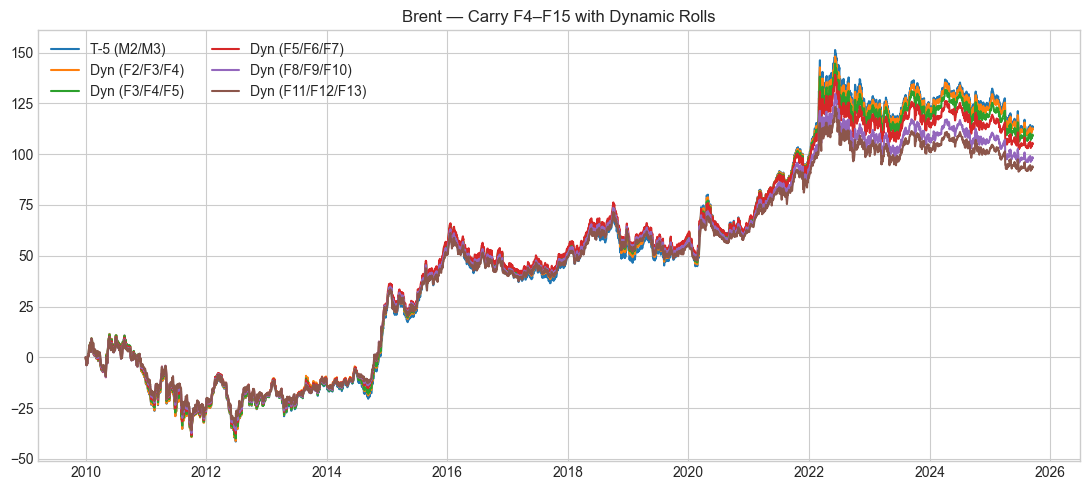

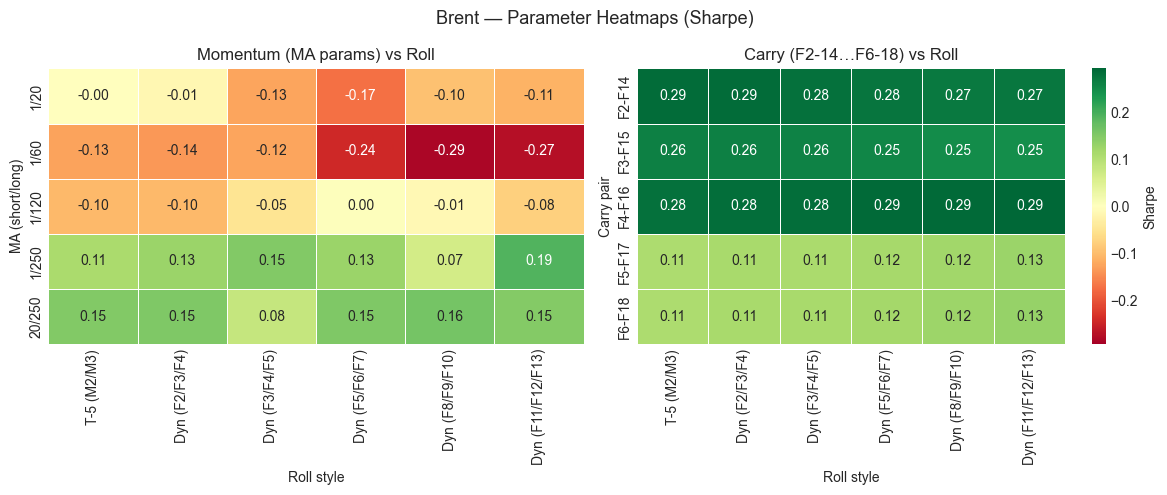

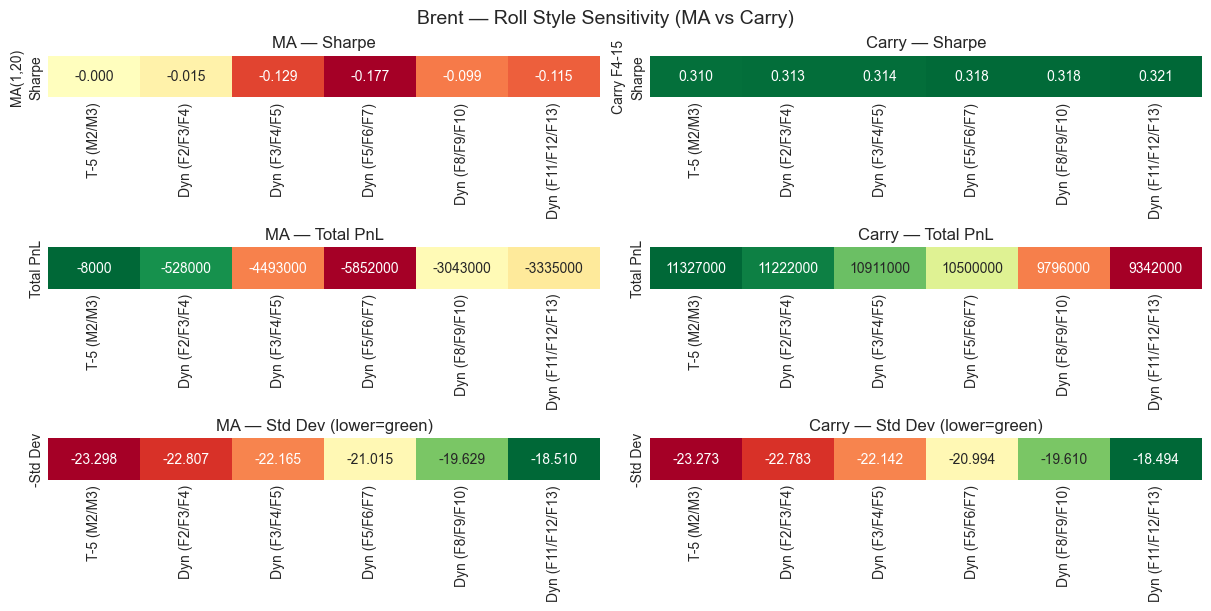

Total PnL    Total Cost  APL/unit  Std Dev (ann.)  \
style                                                                      
Dyn (F11/F12/F13)   595,000.0000 -380,000.0000    0.3785         18.5027   
Dyn (F2/F3/F4)    2,213,000.0000 -380,000.0000    1.4077         22.7963   
Dyn (F3/F4/F5)    1,565,000.0000 -380,000.0000    0.9955         22.1545   
Dyn (F5/F6/F7)    1,182,000.0000 -380,000.0000    0.7519         21.0054   
Dyn (F8/F9/F10)     988,000.0000 -380,000.0000    0.6285         19.6197   
T-5 (M2/M3)       2,448,000.0000 -380,000.0000    1.5572         23.2873   

                   Sharpe  Drawdown    RoD   Years  
style                                               
Dyn (F11/F12/F13)  0.0205   -0.5905 0.6410 15.7205  
Dyn (F2/F3/F4)     0.0618   -0.7079 1.9886 15.7205  
Dyn (F3/F4/F5)     0.0449   -0.6999 1.4224 15.7205  
Dyn (F5/F6/F7)     0.0358   -0.6554 1.1473 15.7205  
Dyn (F8/F9/F10)    0.0320   -0.6111 1.0284 15.7205  
T-5 (M2/M3)        0.0669   -0.7163 2.1739 15.7205

Total PnL   Total Cost  APL/unit  \
style             strategy                                          
Dyn (F11/F12/F13) MA(1,20) -3,335,000.0000 967,000.0000   -2.1214   
Dyn (F2/F3/F4)    MA(1,20)   -528,000.0000 909,000.0000   -0.3359   
Dyn (F3/F4/F5)    MA(1,20) -4,493,000.0000 929,000.0000   -2.8580   
Dyn (F5/F6/F7)    MA(1,20) -5,852,000.0000 979,000.0000   -3.7225   
Dyn (F8/F9/F10)   MA(1,20) -3,043,000.0000 937,000.0000   -1.9357   
T-5 (M2/M3)       MA(1,20)     -8,000.0000 917,000.0000   -0.0051   

                            Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style             strategy                                                    
Dyn (F11/F12/F13) MA(1,20)         18.5098 -0.1146   -0.6074 -3.4928 15.7205  
Dyn (F2/F3/F4)    MA(1,20)         22.8069 -0.0147   -0.5578 -0.6022 15.7205  
Dyn (F3/F4/F5)    MA(1,20)         22.1652 -0.1289   -0.7104 -4.0234 15.7205  
Dyn (F5/F6/F7)    MA(1,20)         21.0154 -0.1771   -0.7580 -4.9108 15.7205  
Dyn (F8/F9/F10)   MA(1,20)         19.6288 -0.0986   -0.6134 -3.1555 15.7205  
T-5 (M2/M3)       MA(1,20)         23.2981 -0.0002   -0.5449 -0.0093 15.7205

Total PnL   Total Cost  APL/unit  \
style             strategy                                             
Dyn (F11/F12/F13) Carry F4-15  9,342,000.0000  94,000.0000    5.9425   
Dyn (F2/F3/F4)    Carry F4-15 11,222,000.0000  94,000.0000    7.1384   
Dyn (F3/F4/F5)    Carry F4-15 10,911,000.0000  94,000.0000    6.9406   
Dyn (F5/F6/F7)    Carry F4-15 10,500,000.0000  94,000.0000    6.6792   
Dyn (F8/F9/F10)   Carry F4-15  9,796,000.0000  94,000.0000    6.2313   
T-5 (M2/M3)       Carry F4-15 11,327,000.0000 102,000.0000    7.2052   

                               Std Dev (ann.)  Sharpe  Drawdown     RoD  \
style             strategy                                                
Dyn (F11/F12/F13) Carry F4-15         18.4939  0.3213   -0.4172 14.2427   
Dyn (F2/F3/F4)    Carry F4-15         22.7832  0.3133   -0.4722 15.1178   
Dyn (F3/F4/F5)    Carry F4-15         22.1421  0.3135   -0.4595 15.1054   
Dyn (F5/F6/F7)    Carry F4-15         20.9942  0.3181   -0.4409 15.1479   
Dyn (F8/F9/F10)   Carry F4-15         19.6102  0.3178   -0.4291 14.5221   
T-5 (M2/M3)       Carry F4-15         23.2725  0.3096   -0.4753 15.1609   

                                Years  
style             strategy             
Dyn (F11/F12/F13) Carry F4-15 15.7205  
Dyn (F2/F3/F4)    Carry F4-15 15.7205  
Dyn (F3/F4/F5)    Carry F4-15 15.7205  
Dyn (F5/F6/F7)    Carry F4-15 15.7205  
Dyn (F8/F9/F10)   Carry F4-15 15.7205  
T-5 (M2/M3)       Carry F4-15 15.7205

In [6]:
# ---------------------------------------------------------------------
# Brent Roll — T-5 M2/M3 + Dynamic 2-3-4 + Dynamic 3-4-5 + Dynamic 5-6-7
#                 + Dynamic 8-9-10 + Dynamic 11-12-13
# + MA / Carry parameter heatmaps (Brent-specific)
# ---------------------------------------------------------------------
commodity_name = "Brent"
ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

prices = load_prices(commodity_name, ticker)      # already clipped to 2010-01-04
expiry_cal = load_expiry(ticker)

# Brent-only collectors (don’t touch NGL or WTI lists)
brent_roll_metrics_list  = []
brent_ma_metrics_list    = []
brent_carry_metrics_list = []

# --- 1) T-5, M2/M3 (baseline) ---------------------------------------
brent_res_t5_m23 = rolling_pnl(
    prices,
    expiry_cal,
    front_col="F2",
    next_col="F3",
    roll_window=roll_window,
)
brent_res_t5_m23 = roll_EL(brent_res_t5_m23, prices, front_col="F2", t_cost=t_cost)

# --- 2) Dynamic 2-3-4 (was 1-2-3, moved up one) ---------------------
brent_res_dyn_234 = roll_EOM_dynamic_brent(
    prices,
    expiry_cal,
    front_col="F2",
    next_col="F3",
    third_col="F4",
)
brent_res_dyn_234 = roll_EL(brent_res_dyn_234, prices, front_col="F2", t_cost=t_cost)

# --- 3) Dynamic 3-4-5 ------------------------------------------------
brent_res_dyn_345 = roll_EOM_dynamic_brent(
    prices,
    expiry_cal,
    front_col="F3",
    next_col="F4",
    third_col="F5",
)
brent_res_dyn_345 = roll_EL(brent_res_dyn_345, prices, front_col="F3", t_cost=t_cost)

# --- 4) Dynamic 5-6-7 ------------------------------------------------
brent_res_dyn_567 = roll_EOM_dynamic_brent(
    prices,
    expiry_cal,
    front_col="F5",
    next_col="F6",
    third_col="F7",
)
brent_res_dyn_567 = roll_EL(brent_res_dyn_567, prices, front_col="F5", t_cost=t_cost)

# --- 5) Dynamic 8-9-10 ----------------------------------------------
brent_res_dyn_8910 = roll_EOM_dynamic_brent(
    prices,
    expiry_cal,
    front_col="F8",
    next_col="F9",
    third_col="F10",
)
brent_res_dyn_8910 = roll_EL(brent_res_dyn_8910, prices, front_col="F8", t_cost=t_cost)

# --- 6) Dynamic 11-12-13 --------------------------------------------
brent_res_dyn_111213 = roll_EOM_dynamic_brent(
    prices,
    expiry_cal,
    front_col="F11",
    next_col="F12",
    third_col="F13",
)
brent_res_dyn_111213 = roll_EL(brent_res_dyn_111213, prices, front_col="F11", t_cost=t_cost)

# --- bundle for plotting / downstream strategies --------------------
brent_roll_results = {
    "T-5 (M2/M3)":        brent_res_t5_m23,
    "Dyn (F2/F3/F4)":     brent_res_dyn_234,
    "Dyn (F3/F4/F5)":     brent_res_dyn_345,
    "Dyn (F5/F6/F7)":     brent_res_dyn_567,
    "Dyn (F8/F9/F10)":    brent_res_dyn_8910,
    "Dyn (F11/F12/F13)":  brent_res_dyn_111213,
}

# tell MA which front leg to use per style
brent_style_front_cols = {
    "T-5 (M2/M3)":       "F2",
    "Dyn (F2/F3/F4)":    "F2",
    "Dyn (F3/F4/F5)":    "F3",
    "Dyn (F5/F6/F7)":    "F5",
    "Dyn (F8/F9/F10)":   "F8",
    "Dyn (F11/F12/F13)": "F11",
}
brent_styles_order = list(brent_roll_results.keys())

# ---------------------------------------------------------------------
# 0. BASE ROLL CHART
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(brent_roll_results))

for (label, df_res), color in zip(brent_roll_results.items(), palette):
    ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

ax.set_title("Brent — Dynamic vs T-5 (Full Sample)")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# BASE ROLL METRICS (Brent-only)
# ---------------------------------------------------------------------
for label, df_res in brent_roll_results.items():
    m = metrics(df_res, contracts=contracts, units=units)
    m["commodity"] = commodity_name
    m["style"] = label
    brent_roll_metrics_list.append(m)

# ---------------------------------------------------------------------
# 1. MA(1,20) ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
brent_ma_results = {}

for label, rolled_df in brent_roll_results.items():
    front_col_for_style = brent_style_front_cols[label]

    df_ma = momentum(
        prices=prices,
        rolled_df=rolled_df,
        front_col=front_col_for_style,
        short_ma=1,
        long_ma=20,
        t_cost=t_cost,
        epsilon=0.00,
    )
    brent_ma_results[label] = df_ma

    m_ma = metrics(df_ma, contracts=contracts, units=units)
    m_ma["commodity"] = commodity_name
    m_ma["style"] = label
    m_ma["strategy"] = "MA(1,20)"
    brent_ma_metrics_list.append(m_ma)

fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(brent_ma_results))

for (label, df_ma), color in zip(brent_ma_results.items(), palette):
    ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

ax.set_title("Brent — MA(1,20) on Dynamic / T-5 Rolls")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
brent_carry_results = {}

for label, rolled_df in brent_roll_results.items():
    if not {"F4", "F15"}.issubset(prices.columns):
        continue

    df_carry = carry(
        prices=prices,
        rolled_df=rolled_df,
        front_col="F4",    # same convention as WTI
        end_col="F15",
        t_cost=t_cost,
        epsilon=0.00,
    )
    brent_carry_results[label] = df_carry

    m_c = metrics(df_carry, contracts=contracts, units=units)
    m_c["commodity"] = commodity_name
    m_c["style"] = label
    m_c["strategy"] = "Carry F4-15"
    brent_carry_metrics_list.append(m_c)

if brent_carry_results:
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(brent_carry_results))

    for (label, df_carry), color in zip(brent_carry_results.items(), palette):
        ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

    ax.set_title("Brent — Carry F4–F15 with Dynamic Rolls")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 3. PARAMETER HEATMAPS (MA grid, Carry grid) — Brent-specific
# ---------------------------------------------------------------------
brent_ma_sharpes = pd.DataFrame(
    index=[f"{s}/{l}" for (s, l) in ma_params],
    columns=brent_styles_order,
    dtype=float,
)

for roll_name, rolled_df in brent_roll_results.items():
    front_col_for_style = brent_style_front_cols[roll_name]
    for (sma, lma) in ma_params:
        df_ma_param = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col=front_col_for_style,
            short_ma=sma,
            long_ma=lma,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_ma_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        brent_ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

# Carry grid: 5 carry pairs × 6 roll styles
brent_carry_sharpes = pd.DataFrame(
    index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
    columns=brent_styles_order,
    dtype=float,
)

for roll_name, rolled_df in brent_roll_results.items():
    for (f1, f2) in carry_pairs:
        c1, c2 = f"F{f1}", f"F{f2}"
        if c1 not in prices.columns or c2 not in prices.columns:
            continue
        df_c_param = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col=c1,
            end_col=c2,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_c_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        brent_carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

# symmetric color range
all_vals = np.concatenate(
    [
        brent_ma_sharpes.to_numpy().flatten(),
        brent_carry_sharpes.to_numpy().flatten(),
    ]
)
all_vals = all_vals[~np.isnan(all_vals)]
vlim = float(np.max(np.abs(all_vals))) if len(all_vals) else 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Brent — Parameter Heatmaps (Sharpe)", fontsize=13)

sns.heatmap(
    brent_ma_sharpes,
    ax=axes[0],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
)
axes[0].set_title("Momentum (MA params) vs Roll")
axes[0].set_xlabel("Roll style")
axes[0].set_ylabel("MA (short/long)")

sns.heatmap(
    brent_carry_sharpes,
    ax=axes[1],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=True,
    cbar_kws={"label": "Sharpe"},
    linewidths=0.5,
    linecolor="white",
)
axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
axes[1].set_xlabel("Roll style")
axes[1].set_ylabel("Carry pair")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# Build Brent-only DataFrames from our Brent lists
# ---------------------------------------------------------------------
brent_roll_df = pd.DataFrame(brent_roll_metrics_list).set_index(["commodity", "style"])
brent_ma_df   = pd.DataFrame(brent_ma_metrics_list).set_index(["commodity", "style", "strategy"])
if brent_carry_metrics_list:
    brent_carry_df = pd.DataFrame(brent_carry_metrics_list).set_index(["commodity", "style", "strategy"])
else:
    brent_carry_df = pd.DataFrame()

# ---------------------------------------------------------------------
# Brent — Roll Style Sensitivity (MA vs Carry)
# ---------------------------------------------------------------------
brent_styles_order = [
    "T-5 (M2/M3)",
    "Dyn (F2/F3/F4)",
    "Dyn (F3/F4/F5)",
    "Dyn (F5/F6/F7)",
    "Dyn (F8/F9/F10)",
    "Dyn (F11/F12/F13)",
]

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(12, 6),
    constrained_layout=True
)
fig.suptitle("Brent — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

# ----- MA(1,20) slice ------------------------------------------------
brent_ma_base = brent_ma_df.loc[("Brent", slice(None), "MA(1,20)")]
brent_ma_sharpe_slice = brent_ma_base["Sharpe"].reindex(brent_styles_order)
brent_ma_pnl_slice    = brent_ma_base["Total PnL"].reindex(brent_styles_order)
brent_ma_std_slice    = brent_ma_base["Std Dev (ann.)"].reindex(brent_styles_order)

# MA — Sharpe
ax = axes[0, 0]
ma_sharpe_df = pd.DataFrame(
    [brent_ma_sharpe_slice.values],
    index=["Sharpe"],
    columns=brent_styles_order,
)
sns.heatmap(
    ma_sharpe_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.0,
    cbar=False,
)
ax.set_ylabel("MA(1,20)")
ax.set_xlabel("")
ax.set_title("MA — Sharpe")

# MA — Total PnL
ax = axes[1, 0]
ma_pnl_df = pd.DataFrame(
    [brent_ma_pnl_slice.values],
    index=["Total PnL"],
    columns=brent_styles_order,
)
vmin = ma_pnl_df.min().min()
vmax = ma_pnl_df.max().max()
sns.heatmap(
    ma_pnl_df,
    ax=ax,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Total PnL")

# MA — Std Dev (lower=green)
ax = axes[2, 0]
ma_std_df = pd.DataFrame(
    [(-brent_ma_std_slice).values],
    index=["-Std Dev"],
    columns=brent_styles_order,
)
sns.heatmap(
    ma_std_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Std Dev (lower=green)")

# ----- CARRY F4-15 slice ---------------------------------------------
has_carry = not brent_carry_df.empty
if has_carry:
    brent_carry_base = brent_carry_df.loc[("Brent", slice(None), "Carry F4-15")]
    brent_carry_sharpe_slice = brent_carry_base["Sharpe"].reindex(brent_styles_order)
    brent_carry_pnl_slice    = brent_carry_base["Total PnL"].reindex(brent_styles_order)
    brent_carry_std_slice    = brent_carry_base["Std Dev (ann.)"].reindex(brent_styles_order)

    # Carry — Sharpe
    ax = axes[0, 1]
    carry_sharpe_df = pd.DataFrame(
        [brent_carry_sharpe_slice.values],
        index=["Sharpe"],
        columns=brent_styles_order,
    )
    sns.heatmap(
        carry_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("Carry F4-15")
    ax.set_xlabel("")
    ax.set_title("Carry — Sharpe")

    # Carry — Total PnL
    ax = axes[1, 1]
    carry_pnl_df = pd.DataFrame(
        [brent_carry_pnl_slice.values],
        index=["Total PnL"],
        columns=brent_styles_order,
    )
    vmin = carry_pnl_df.min().min()
    vmax = carry_pnl_df.max().max()
    sns.heatmap(
        carry_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Total PnL")

    # Carry — Std Dev (lower=green)
    ax = axes[2, 1]
    carry_std_df = pd.DataFrame(
        [(-brent_carry_std_slice).values],
        index=["-Std Dev"],
        columns=brent_styles_order,
    )
    sns.heatmap(
        carry_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Std Dev (lower=green)")
else:
    for r in range(3):
        axes[r, 1].axis("off")

plt.show()

# ---------------------------------------------------------------------
# Brent-only metrics tables (for display / export)
# ---------------------------------------------------------------------
brent_roll_metrics_df  = brent_roll_df.loc["Brent"].sort_index()
brent_ma_metrics_df    = brent_ma_df.loc[("Brent", slice(None), slice(None))].sort_index()
try:
    brent_carry_metrics_df = brent_carry_df.loc[("Brent", slice(None), slice(None))].sort_index()
except KeyError:
    brent_carry_metrics_df = pd.DataFrame()

display(brent_roll_metrics_df)
display(brent_ma_metrics_df)
display(brent_carry_metrics_df)

## RBOB + Heating Oil Roll

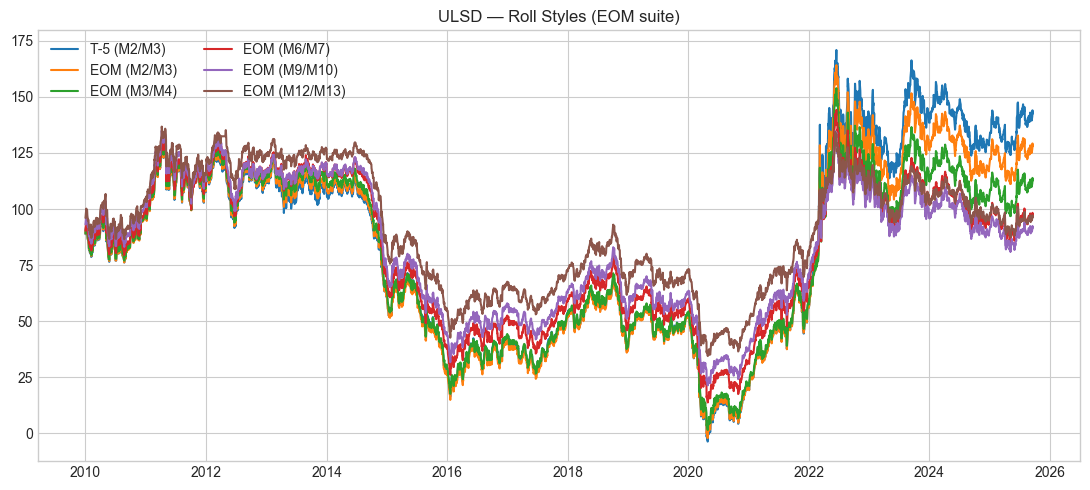

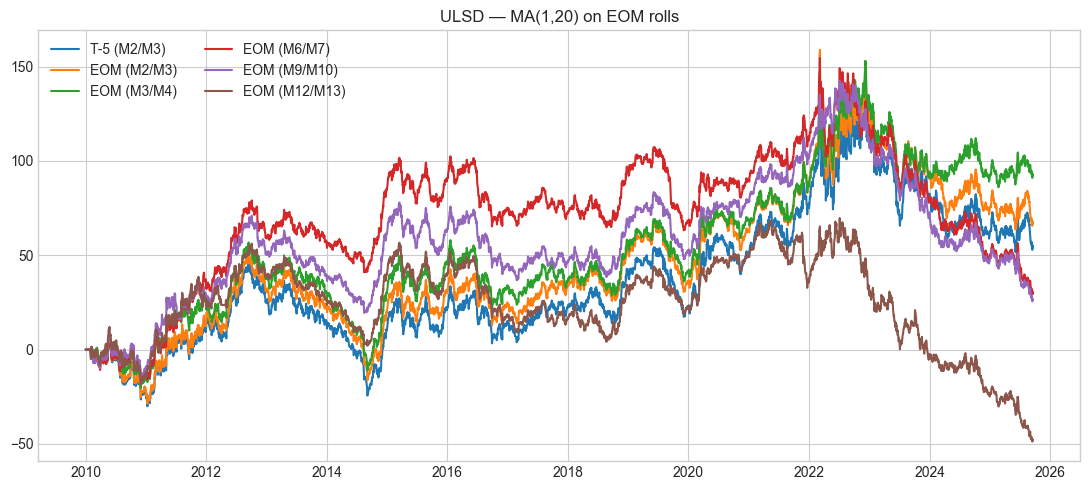

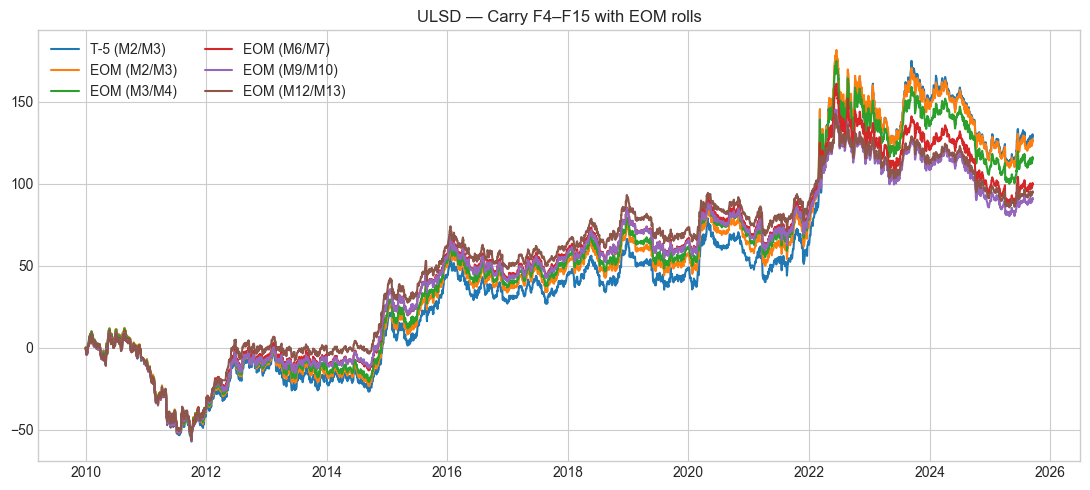

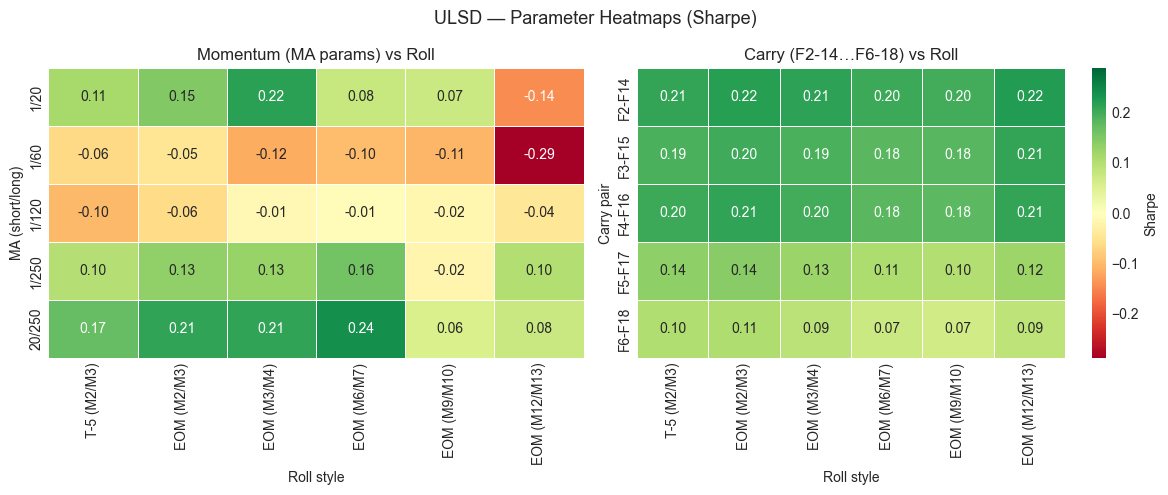

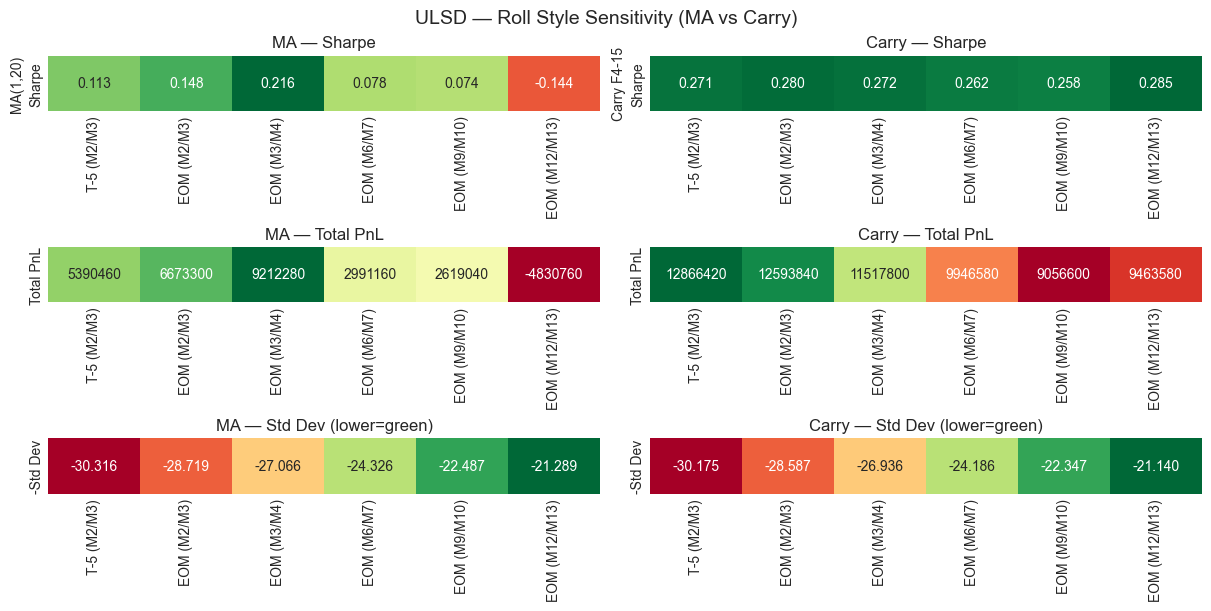

Total PnL      Total Cost  APL/unit  Std Dev (ann.)  \
style                                                                    
EOM (M12/M13)    26,880.0000 -1,890,000.0000    0.0171         21.1275   
EOM (M2/M3)   3,879,120.0000 -1,890,000.0000    2.4675         28.5752   
EOM (M3/M4)   2,333,520.0000 -1,890,000.0000    1.4844         26.9240   
EOM (M6/M7)     684,180.0000 -1,890,000.0000    0.4352         24.1723   
EOM (M9/M10)   -167,160.0000 -1,890,000.0000   -0.1063         22.3327   
T-5 (M2/M3)   5,357,940.0000 -1,890,000.0000    3.4082         30.1673   

               Sharpe  Drawdown     RoD   Years  
style                                            
EOM (M12/M13)  0.0008   -0.7270  0.0235 15.7205  
EOM (M2/M3)    0.0864   -0.9371  2.6331 15.7205  
EOM (M3/M4)    0.0551   -0.9131  1.6256 15.7205  
EOM (M6/M7)    0.0180   -0.8347  0.5214 15.7205  
EOM (M9/M10)  -0.0048   -0.8009 -0.1328 15.7205  
T-5 (M2/M3)    0.1130   -0.9464  3.6014 15.7205

Total PnL     Total Cost  APL/unit  \
style         strategy                                            
EOM (M12/M13) MA(1,20) -4,830,760.0000 4,525,000.0000   -3.0729   
EOM (M2/M3)   MA(1,20)  6,673,300.0000 4,505,000.0000    4.2450   
EOM (M3/M4)   MA(1,20)  9,212,280.0000 4,305,000.0000    5.8600   
EOM (M6/M7)   MA(1,20)  2,991,160.0000 4,505,000.0000    1.9027   
EOM (M9/M10)  MA(1,20)  2,619,040.0000 4,505,000.0000    1.6660   
T-5 (M2/M3)   MA(1,20)  5,390,460.0000 4,695,000.0000    3.4289   

                        Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                    
EOM (M12/M13) MA(1,20)         21.2889 -0.1443   -0.6984 -4.4000 15.7205  
EOM (M2/M3)   MA(1,20)         28.7189  0.1478   -0.4439  9.5634 15.7205  
EOM (M3/M4)   MA(1,20)         27.0659  0.2165   -0.4336 13.5154 15.7205  
EOM (M6/M7)   MA(1,20)         24.3265  0.0782   -0.4928  3.8614 15.7205  
EOM (M9/M10)  MA(1,20)         22.4873  0.0741   -0.4819  3.4572 15.7205  
T-5 (M2/M3)   MA(1,20)         30.3155  0.1131   -0.4830  7.0990 15.7205

Total PnL   Total Cost  APL/unit  \
style         strategy                                             
EOM (M12/M13) Carry F4-15  9,463,580.0000 700,000.0000    6.0199   
EOM (M2/M3)   Carry F4-15 12,593,840.0000 700,000.0000    8.0111   
EOM (M3/M4)   Carry F4-15 11,517,800.0000 700,000.0000    7.3266   
EOM (M6/M7)   Carry F4-15  9,946,580.0000 700,000.0000    6.3271   
EOM (M9/M10)  Carry F4-15  9,056,600.0000 700,000.0000    5.7610   
T-5 (M2/M3)   Carry F4-15 12,866,420.0000 700,000.0000    8.1845   

                           Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                       
EOM (M12/M13) Carry F4-15         21.1403  0.2848   -0.5992 10.0468 15.7205  
EOM (M2/M3)   Carry F4-15         28.5867  0.2802   -0.6071 13.1948 15.7205  
EOM (M3/M4)   Carry F4-15         26.9357  0.2720   -0.6089 12.0328 15.7205  
EOM (M6/M7)   Carry F4-15         24.1858  0.2616   -0.6064 10.4333 15.7205  
EOM (M9/M10)  Carry F4-15         22.3474  0.2578   -0.6070  9.4911 15.7205  
T-5 (M2/M3)   Carry F4-15         30.1749  0.2712   -0.6179 13.2465 15.7205

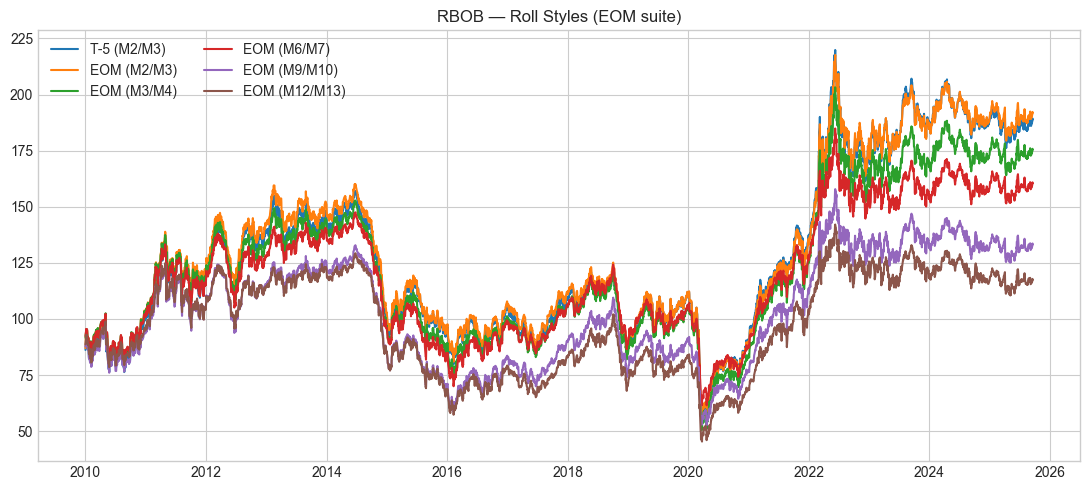

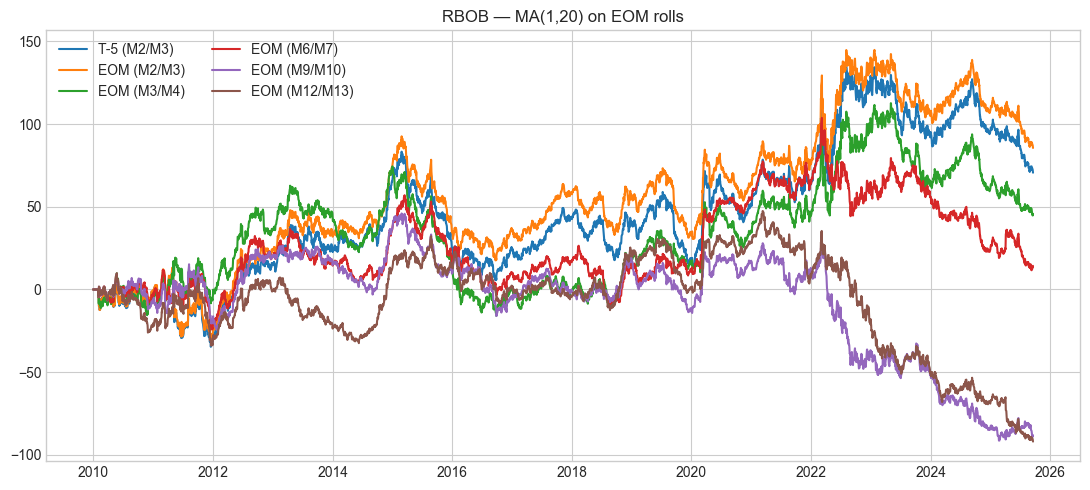

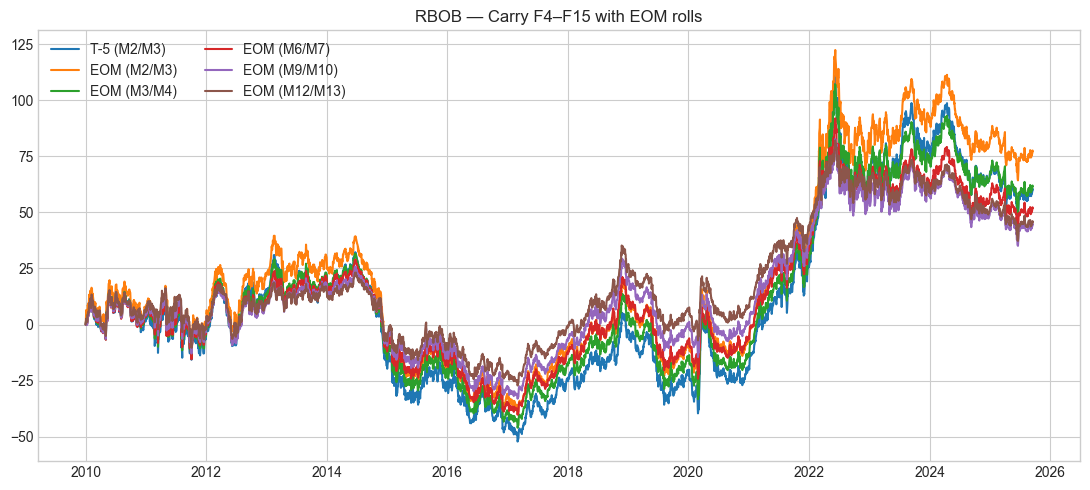

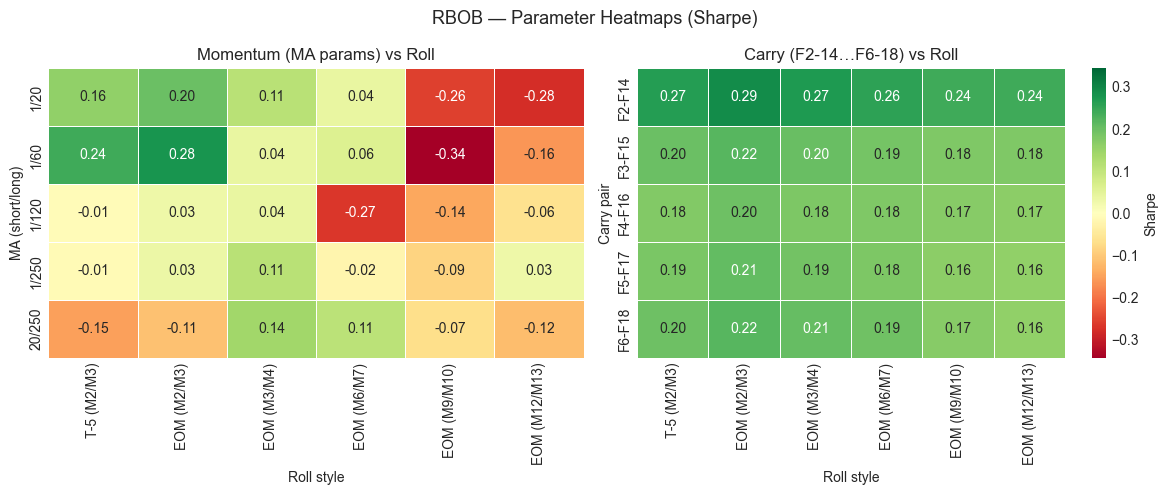

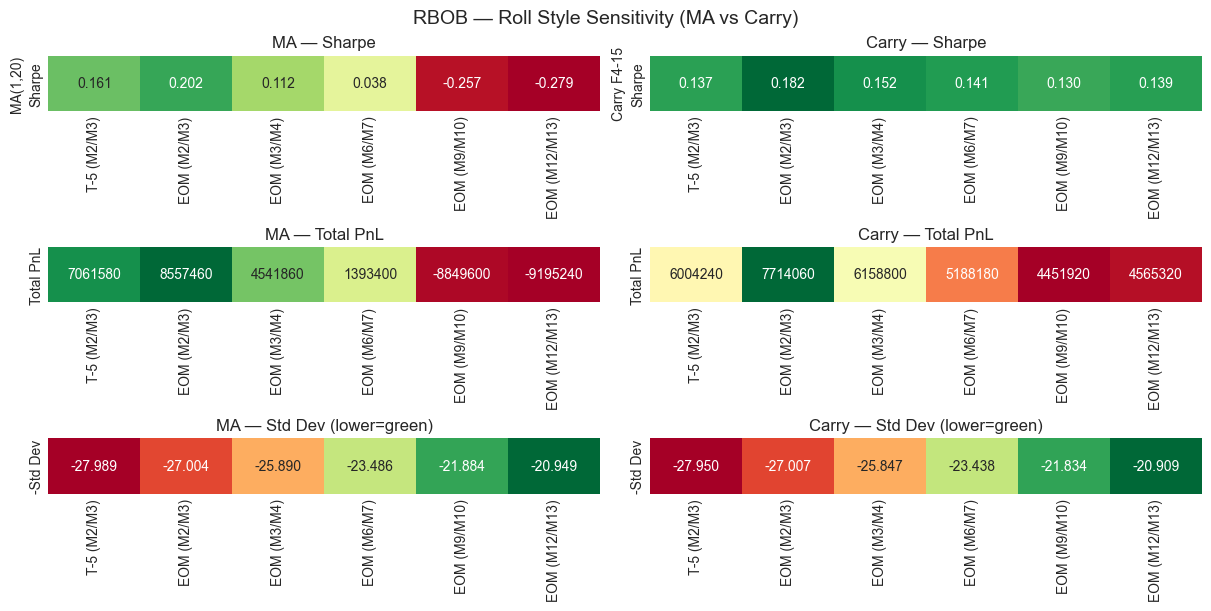

Total PnL    Total Cost  APL/unit  Std Dev (ann.)  Sharpe  \
style                                                                           
EOM (M12/M13)  2,866,920.0000 -756,000.0000    1.8237         20.9081  0.0872   
EOM (M2/M3)   10,478,580.0000 -756,000.0000    6.6655         27.0037  0.2468   
EOM (M3/M4)    8,382,360.0000 -756,000.0000    5.3321         25.8439  0.2063   
EOM (M6/M7)    6,809,460.0000 -756,000.0000    4.3316         23.4358  0.1848   
EOM (M9/M10)   4,535,160.0000 -756,000.0000    2.8849         21.8327  0.1321   
T-5 (M2/M3)   10,258,500.0000 -756,000.0000    6.5255         27.9442  0.2335   

               Drawdown     RoD   Years  
style                                    
EOM (M12/M13)   -0.5968  3.0558 15.7205  
EOM (M2/M3)     -0.6137 10.8603 15.7205  
EOM (M3/M4)     -0.6345  8.4039 15.7205  
EOM (M6/M7)     -0.5542  7.8159 15.7205  
EOM (M9/M10)    -0.5530  5.2170 15.7205  
T-5 (M2/M3)     -0.6192 10.5379 15.7205

Total PnL     Total Cost  APL/unit  \
style         strategy                                            
EOM (M12/M13) MA(1,20) -9,195,240.0000 1,794,000.0000   -5.8492   
EOM (M2/M3)   MA(1,20)  8,557,460.0000 1,654,000.0000    5.4435   
EOM (M3/M4)   MA(1,20)  4,541,860.0000 1,730,000.0000    2.8891   
EOM (M6/M7)   MA(1,20)  1,393,400.0000 1,786,000.0000    0.8864   
EOM (M9/M10)  MA(1,20) -8,849,600.0000 1,802,000.0000   -5.6293   
T-5 (M2/M3)   MA(1,20)  7,061,580.0000 1,758,000.0000    4.4919   

                        Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                    
EOM (M12/M13) MA(1,20)         20.9490 -0.2792   -0.9454 -6.1869 15.7205  
EOM (M2/M3)   MA(1,20)         27.0037  0.2016   -0.3895 13.9750 15.7205  
EOM (M3/M4)   MA(1,20)         25.8902  0.1116   -0.5181  5.5764 15.7205  
EOM (M6/M7)   MA(1,20)         23.4864  0.0377   -0.4521  1.9605 15.7205  
EOM (M9/M10)  MA(1,20)         21.8841 -0.2572   -0.9409 -5.9826 15.7205  
T-5 (M2/M3)   MA(1,20)         27.9892  0.1605   -0.4239 10.5959 15.7205

Total PnL   Total Cost  APL/unit  \
style         strategy                                            
EOM (M12/M13) Carry F4-15 4,565,320.0000 200,000.0000    2.9040   
EOM (M2/M3)   Carry F4-15 7,714,060.0000 200,000.0000    4.9070   
EOM (M3/M4)   Carry F4-15 6,158,800.0000 200,000.0000    3.9177   
EOM (M6/M7)   Carry F4-15 5,188,180.0000 200,000.0000    3.3003   
EOM (M9/M10)  Carry F4-15 4,451,920.0000 200,000.0000    2.8319   
T-5 (M2/M3)   Carry F4-15 6,004,240.0000 284,000.0000    3.8194   

                           Std Dev (ann.)  Sharpe  Drawdown    RoD   Years  
style         strategy                                                      
EOM (M12/M13) Carry F4-15         20.9085  0.1389   -0.4091 7.0989 15.7205  
EOM (M2/M3)   Carry F4-15         27.0069  0.1817   -0.5690 8.6235 15.7205  
EOM (M3/M4)   Carry F4-15         25.8466  0.1516   -0.5891 6.6501 15.7205  
EOM (M6/M7)   Carry F4-15         23.4380  0.1408   -0.5360 6.1575 15.7205  
EOM (M9/M10)  Carry F4-15         21.8341  0.1297   -0.4676 6.0565 15.7205  
T-5 (M2/M3)   Carry F4-15         27.9501  0.1366   -0.6375 5.9909 15.7205

In [7]:
# ---------------------------------------------------------------------
# ULSD / RBOB — EOM-style suite
# Styles:
#   1) T-5 (M2/M3)
#   2) EOM (M2/M3)
#   3) EOM (M3/M4)
#   4) EOM (M6/M7)
#   5) EOM (M9/M10)
#   6) EOM (M12/M13)
#
# Uses same MA / Carry machinery as WTI/Brent
# ---------------------------------------------------------------------
refined_names = ["ULSD", "RBOB"]

for commodity_name in refined_names:
    ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

    prices = load_prices(commodity_name, ticker)
    expiry_cal = load_expiry(ticker)

    # per-commodity collectors
    ref_roll_metrics_list  = []
    ref_ma_metrics_list    = []
    ref_carry_metrics_list = []

    # -------------------------------------------------------------
    # 1) T-5 (M2/M3)
    # -------------------------------------------------------------
    res_t5_m23 = rolling_pnl(
        prices,
        expiry_cal,
        front_col="F2",
        next_col="F3",
        roll_window=roll_window,
    )
    res_t5_m23 = roll_EL(res_t5_m23, prices, front_col="F2", t_cost=t_cost)

    # -------------------------------------------------------------
    # 2) EOM (M2/M3)
    # -------------------------------------------------------------
    res_eom_m23 = roll_EOM_midmonth_expiry(
        prices,
        expiry_cal,
        front_col="F2",
        next_col="F3",
    )
    res_eom_m23 = roll_EL(res_eom_m23, prices, front_col="F2", t_cost=t_cost)

    # -------------------------------------------------------------
    # 3) EOM (M3/M4)
    # -------------------------------------------------------------
    res_eom_m34 = roll_EOM_midmonth_expiry(
        prices,
        expiry_cal,
        front_col="F3",
        next_col="F4",
    )
    res_eom_m34 = roll_EL(res_eom_m34, prices, front_col="F3", t_cost=t_cost)

    # -------------------------------------------------------------
    # 4) EOM (M6/M7)
    # -------------------------------------------------------------
    res_eom_m67 = roll_EOM_midmonth_expiry(
        prices,
        expiry_cal,
        front_col="F6",
        next_col="F7",
    )
    res_eom_m67 = roll_EL(res_eom_m67, prices, front_col="F6", t_cost=t_cost)

    # -------------------------------------------------------------
    # 5) EOM (M9/M10)
    # -------------------------------------------------------------
    res_eom_m910 = roll_EOM_midmonth_expiry(
        prices,
        expiry_cal,
        front_col="F9",
        next_col="F10",
    )
    res_eom_m910 = roll_EL(res_eom_m910, prices, front_col="F9", t_cost=t_cost)

    # -------------------------------------------------------------
    # 6) EOM (M12/M13)
    # -------------------------------------------------------------
    res_eom_m1213 = roll_EOM_midmonth_expiry(
        prices,
        expiry_cal,
        front_col="F12",
        next_col="F13",
    )
    res_eom_m1213 = roll_EL(res_eom_m1213, prices, front_col="F12", t_cost=t_cost)

    # bundle
    refined_roll_results = {
        "T-5 (M2/M3)":     res_t5_m23,
        "EOM (M2/M3)":     res_eom_m23,
        "EOM (M3/M4)":     res_eom_m34,
        "EOM (M6/M7)":     res_eom_m67,
        "EOM (M9/M10)":    res_eom_m910,
        "EOM (M12/M13)":   res_eom_m1213,
    }

    # tell MA which front leg to use per style
    refined_style_front_cols = {
        "T-5 (M2/M3)":   "F2",
        "EOM (M2/M3)":   "F2",
        "EOM (M3/M4)":   "F3",
        "EOM (M6/M7)":   "F6",
        "EOM (M9/M10)":  "F9",
        "EOM (M12/M13)": "F12",
    }
    refined_styles_order = list(refined_roll_results.keys())

    # -----------------------------------------------------------------
    # 0. BASE ROLL CHART
    # -----------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(refined_roll_results))

    for (label, df_res), color in zip(refined_roll_results.items(), palette):
        ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

    ax.set_title(f"{commodity_name} — Roll Styles (EOM suite)")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # BASE ROLL METRICS
    # -----------------------------------------------------------------
    for label, df_res in refined_roll_results.items():
        m = metrics(df_res, contracts=contracts, units=units)
        m["commodity"] = commodity_name
        m["style"] = label
        ref_roll_metrics_list.append(m)

    # -----------------------------------------------------------------
    # 1. MA(1,20) ON TOP OF EACH ROLL VARIANT
    # -----------------------------------------------------------------
    refined_ma_results = {}
    for label, rolled_df in refined_roll_results.items():
        front_col_for_style = refined_style_front_cols[label]

        df_ma = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col=front_col_for_style,
            short_ma=1,
            long_ma=20,
            t_cost=t_cost,
            epsilon=0.00,
        )
        refined_ma_results[label] = df_ma

        m_ma = metrics(df_ma, contracts=contracts, units=units)
        m_ma["commodity"] = commodity_name
        m_ma["style"] = label
        m_ma["strategy"] = "MA(1,20)"
        ref_ma_metrics_list.append(m_ma)

    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(refined_ma_results))

    for (label, df_ma), color in zip(refined_ma_results.items(), palette):
        ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

    ax.set_title(f"{commodity_name} — MA(1,20) on EOM rolls")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
    # -----------------------------------------------------------------
    refined_carry_results = {}
    for label, rolled_df in refined_roll_results.items():
        if not {"F4", "F15"}.issubset(prices.columns):
            continue

        df_carry = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col="F4",
            end_col="F15",
            t_cost=t_cost,
            epsilon=0.00,
        )
        refined_carry_results[label] = df_carry

        m_c = metrics(df_carry, contracts=contracts, units=units)
        m_c["commodity"] = commodity_name
        m_c["style"] = label
        m_c["strategy"] = "Carry F4-15"
        ref_carry_metrics_list.append(m_c)

    if refined_carry_results:
        fig, ax = plt.subplots(figsize=(11, 5))
        palette = sns.color_palette("tab10", len(refined_carry_results))
        for (label, df_carry), color in zip(refined_carry_results.items(), palette):
            ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

        ax.set_title(f"{commodity_name} — Carry F4–F15 with EOM rolls")
        ax.legend(loc="best", ncol=2)
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    # -----------------------------------------------------------------
    # 3. PARAMETER HEATMAPS (MA grid, Carry grid)
    # -----------------------------------------------------------------
    refined_ma_sharpes = pd.DataFrame(
        index=[f"{s}/{l}" for (s, l) in ma_params],
        columns=refined_styles_order,
        dtype=float,
    )

    for roll_name, rolled_df in refined_roll_results.items():
        front_col_for_style = refined_style_front_cols[roll_name]
        for (sma, lma) in ma_params:
            df_ma_param = momentum(
                prices=prices,
                rolled_df=rolled_df,
                front_col=front_col_for_style,
                short_ma=sma,
                long_ma=lma,
                t_cost=t_cost,
                epsilon=0.00,
            )
            rets = df_ma_param["equity_line"].diff().dropna()
            if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
                sh = rets.mean() / rets.std() * np.sqrt(252)
            else:
                sh = np.nan
            refined_ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

    refined_carry_sharpes = pd.DataFrame(
        index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
        columns=refined_styles_order,
        dtype=float,
    )

    for roll_name, rolled_df in refined_roll_results.items():
        for (f1, f2) in carry_pairs:
            c1, c2 = f"F{f1}", f"F{f2}"
            if c1 not in prices.columns or c2 not in prices.columns:
                continue

            df_c_param = carry(
                prices=prices,
                rolled_df=rolled_df,
                front_col=c1,
                end_col=c2,
                t_cost=t_cost,
                epsilon=0.00,
            )
            rets = df_c_param["equity_line"].diff().dropna()
            if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
                sh = rets.mean() / rets.std() * np.sqrt(252)
            else:
                sh = np.nan
            refined_carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

    all_vals = np.concatenate(
        [
            refined_ma_sharpes.to_numpy().flatten(),
            refined_carry_sharpes.to_numpy().flatten(),
        ]
    )
    all_vals = all_vals[~np.isnan(all_vals)]
    vlim = float(np.max(np.abs(all_vals))) if len(all_vals) else 1.0

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{commodity_name} — Parameter Heatmaps (Sharpe)", fontsize=13)

    sns.heatmap(
        refined_ma_sharpes,
        ax=axes[0],
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        center=0.0,
        vmin=-vlim,
        vmax=vlim,
        cbar=False,
        linewidths=0.5,
        linecolor="white",
    )
    axes[0].set_title("Momentum (MA params) vs Roll")
    axes[0].set_xlabel("Roll style")
    axes[0].set_ylabel("MA (short/long)")

    sns.heatmap(
        refined_carry_sharpes,
        ax=axes[1],
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        center=0.0,
        vmin=-vlim,
        vmax=vlim,
        cbar=True,
        cbar_kws={"label": "Sharpe"},
        linewidths=0.5,
        linecolor="white",
    )
    axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
    axes[1].set_xlabel("Roll style")
    axes[1].set_ylabel("Carry pair")

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------
    # Build per-commodity DataFrames
    # -----------------------------------------------------------------
    ref_roll_df  = pd.DataFrame(ref_roll_metrics_list).set_index(["commodity", "style"])
    ref_ma_df    = pd.DataFrame(ref_ma_metrics_list).set_index(["commodity", "style", "strategy"])
    if ref_carry_metrics_list:
        ref_carry_df = pd.DataFrame(ref_carry_metrics_list).set_index(["commodity", "style", "strategy"])
    else:
        ref_carry_df = pd.DataFrame()

    # -----------------------------------------------------------------
    # Sensitivity panel — Sharpe / PnL / Std (MA vs Carry)
    # -----------------------------------------------------------------
    fig, axes = plt.subplots(
        nrows=3, ncols=2,
        figsize=(12, 6),
        constrained_layout=True
    )
    fig.suptitle(f"{commodity_name} — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

    # MA(1,20) slice
    ref_ma_base = ref_ma_df.loc[(commodity_name, slice(None), "MA(1,20)")]
    ref_ma_sharpe_slice = ref_ma_base["Sharpe"].reindex(refined_styles_order)
    ref_ma_pnl_slice    = ref_ma_base["Total PnL"].reindex(refined_styles_order)
    ref_ma_std_slice    = ref_ma_base["Std Dev (ann.)"].reindex(refined_styles_order)

    # MA — Sharpe
    ax = axes[0, 0]
    ma_sharpe_df = pd.DataFrame(
        [ref_ma_sharpe_slice.values],
        index=["Sharpe"],
        columns=refined_styles_order,
    )
    sns.heatmap(
        ma_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("MA(1,20)")
    ax.set_xlabel("")
    ax.set_title("MA — Sharpe")

    # MA — Total PnL
    ax = axes[1, 0]
    ma_pnl_df = pd.DataFrame(
        [ref_ma_pnl_slice.values],
        index=["Total PnL"],
        columns=refined_styles_order,
    )
    vmin = ma_pnl_df.min().min()
    vmax = ma_pnl_df.max().max()
    sns.heatmap(
        ma_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("MA — Total PnL")

    # MA — Std Dev (lower=green)
    ax = axes[2, 0]
    ma_std_df = pd.DataFrame(
        [(-ref_ma_std_slice).values],
        index=["-Std Dev"],
        columns=refined_styles_order,
    )
    sns.heatmap(
        ma_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("MA — Std Dev (lower=green)")

    # Carry slice
    has_carry = not ref_carry_df.empty
    if has_carry:
        ref_carry_base = ref_carry_df.loc[(commodity_name, slice(None), "Carry F4-15")]
        ref_carry_sharpe_slice = ref_carry_base["Sharpe"].reindex(refined_styles_order)
        ref_carry_pnl_slice    = ref_carry_base["Total PnL"].reindex(refined_styles_order)
        ref_carry_std_slice    = ref_carry_base["Std Dev (ann.)"].reindex(refined_styles_order)

        # Carry — Sharpe
        ax = axes[0, 1]
        carry_sharpe_df = pd.DataFrame(
            [ref_carry_sharpe_slice.values],
            index=["Sharpe"],
            columns=refined_styles_order,
        )
        sns.heatmap(
            carry_sharpe_df,
            ax=ax,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            center=0.0,
            cbar=False,
        )
        ax.set_ylabel("Carry F4-15")
        ax.set_xlabel("")
        ax.set_title("Carry — Sharpe")

        # Carry — Total PnL
        ax = axes[1, 1]
        carry_pnl_df = pd.DataFrame(
            [ref_carry_pnl_slice.values],
            index=["Total PnL"],
            columns=refined_styles_order,
        )
        vmin = carry_pnl_df.min().min()
        vmax = carry_pnl_df.max().max()
        sns.heatmap(
            carry_pnl_df,
            ax=ax,
            annot=True,
            fmt=".0f",
            cmap="RdYlGn",
            vmin=vmin,
            vmax=vmax,
            cbar=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title("Carry — Total PnL")

        # Carry — Std Dev
        ax = axes[2, 1]
        carry_std_df = pd.DataFrame(
            [(-ref_carry_std_slice).values],
            index=["-Std Dev"],
            columns=refined_styles_order,
        )
        sns.heatmap(
            carry_std_df,
            ax=ax,
            annot=True,
            fmt=".3f",
            cmap="RdYlGn",
            cbar=False,
        )
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_title("Carry — Std Dev (lower=green)")
    else:
        for r in range(3):
            axes[r, 1].axis("off")

    plt.show()

    # -----------------------------------------------------------------
    # Display / export per commodity
    # -----------------------------------------------------------------
    ref_roll_metrics_df  = ref_roll_df.loc[commodity_name].sort_index()
    ref_ma_metrics_df    = ref_ma_df.loc[(commodity_name, slice(None), slice(None))].sort_index()
    try:
        ref_carry_metrics_df = ref_carry_df.loc[(commodity_name, slice(None), slice(None))].sort_index()
    except KeyError:
        ref_carry_metrics_df = pd.DataFrame()

    display(ref_roll_metrics_df)
    display(ref_ma_metrics_df)
    display(ref_carry_metrics_df)


## Gasoil Roll

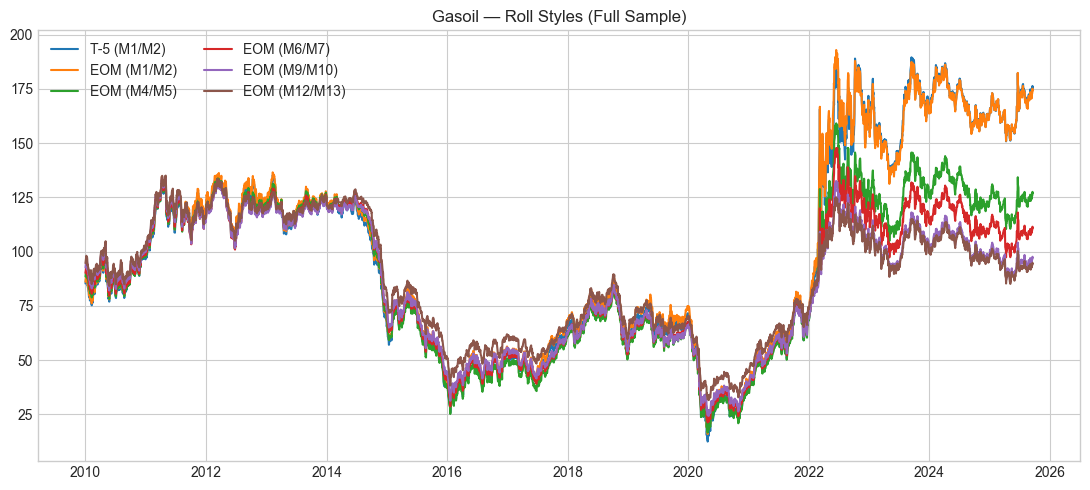

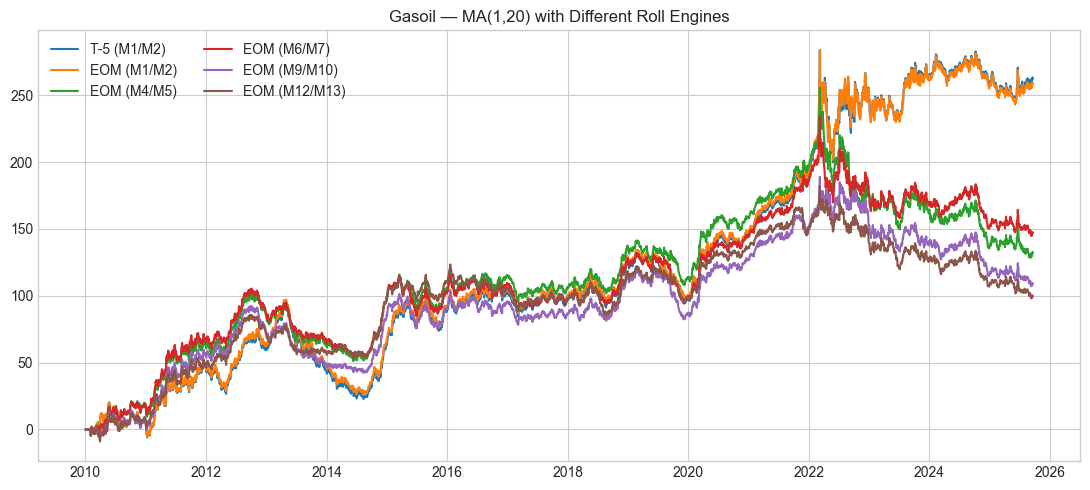

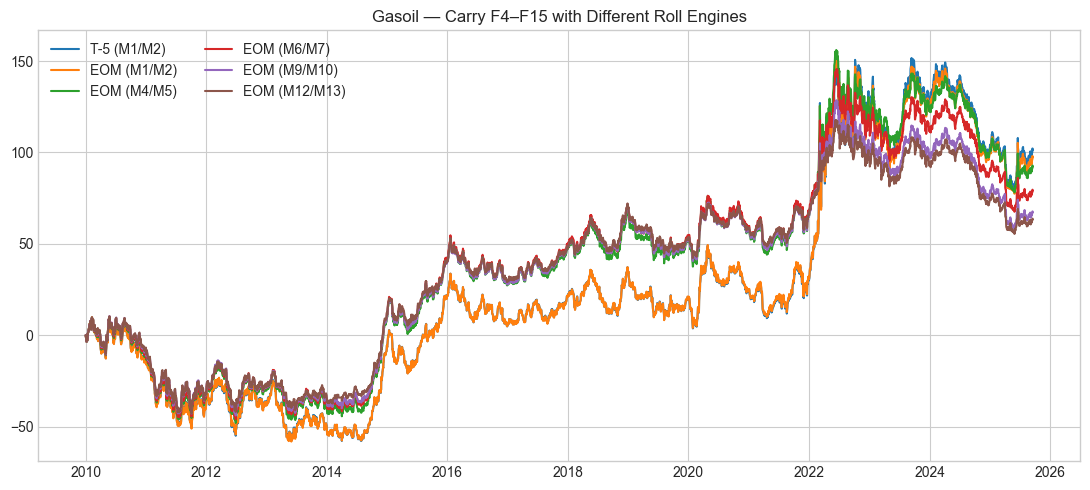

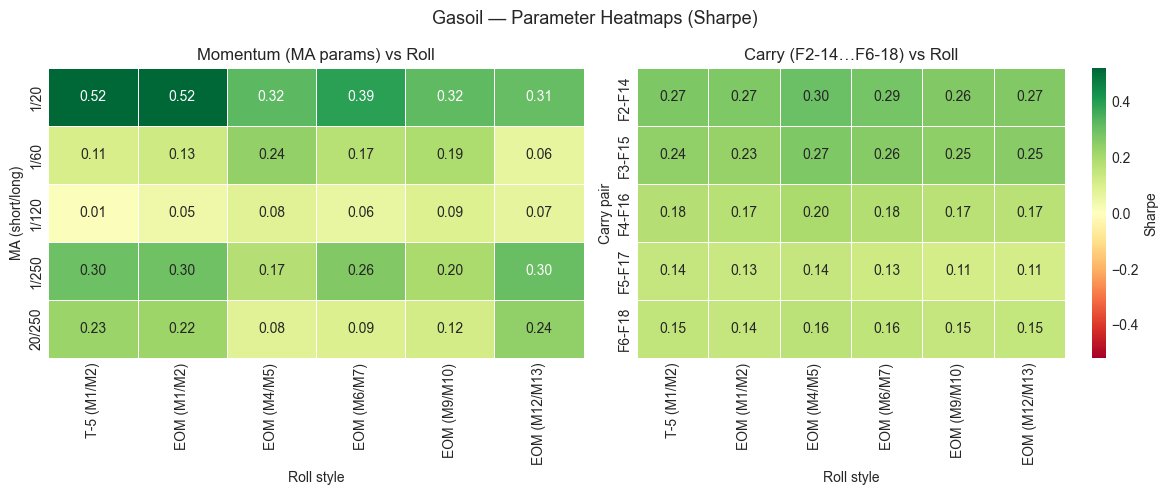

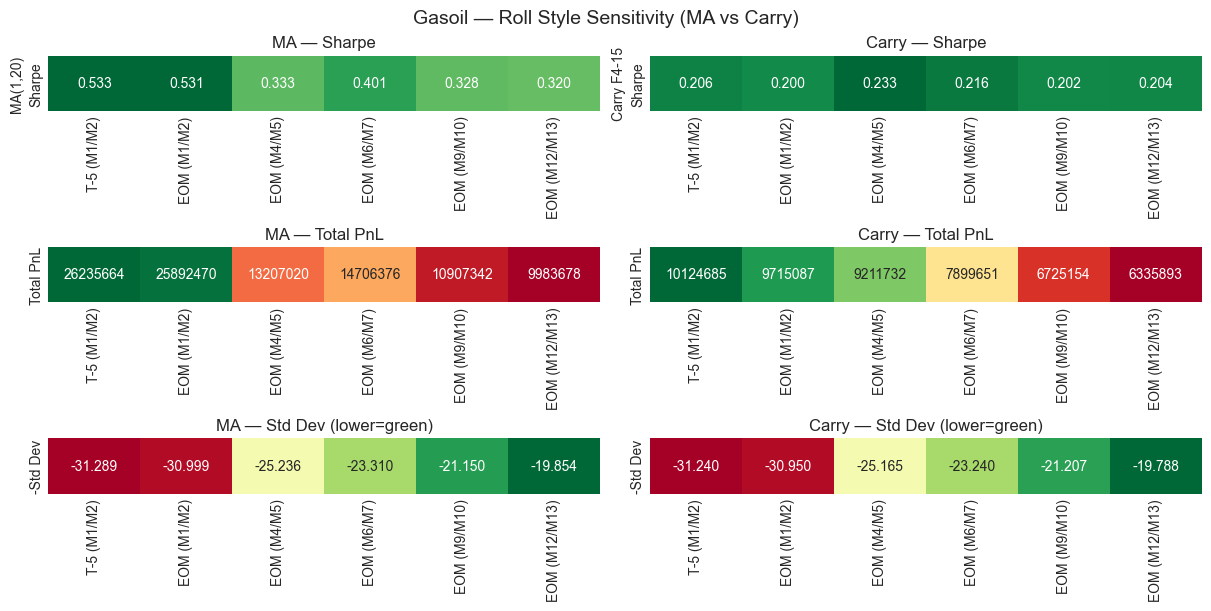

Total PnL    Total Cost  APL/unit  Std Dev (ann.)  Sharpe  \
style                                                                          
EOM (M1/M2)   8,810,469.7987 -760,000.0000    5.6044         30.9748  0.1809   
EOM (M12/M13)   -31,812.0805 -760,000.0000   -0.0202         19.8146 -0.0010   
EOM (M4/M5)   3,833,959.7315 -760,000.0000    2.4388         25.1940  0.0968   
EOM (M6/M7)   2,065,503.3557 -760,000.0000    1.3139         23.2698  0.0565   
EOM (M9/M10)    444,697.9866 -760,000.0000    0.2829         21.2359  0.0133   
T-5 (M1/M2)   9,015,167.7852 -760,000.0000    5.7346         31.2675  0.1834   

               Drawdown     RoD   Years  
style                                    
EOM (M1/M2)     -0.8022  6.9859 15.7205  
EOM (M12/M13)   -0.7378 -0.0274 15.7205  
EOM (M4/M5)     -0.8070  3.0221 15.7205  
EOM (M6/M7)     -0.7834  1.6772 15.7205  
EOM (M9/M10)    -0.7771  0.3640 15.7205  
T-5 (M1/M2)     -0.8193  6.9998 15.7205

Total PnL     Total Cost  APL/unit  \
style         strategy                                            
EOM (M1/M2)   MA(1,20) 25,892,469.7987 1,678,000.0000   16.4705   
EOM (M12/M13) MA(1,20)  9,983,677.8523 1,768,000.0000    6.3507   
EOM (M4/M5)   MA(1,20) 13,207,020.1342 1,746,000.0000    8.4011   
EOM (M6/M7)   MA(1,20) 14,706,375.8389 1,750,000.0000    9.3549   
EOM (M9/M10)  MA(1,20) 10,907,342.2819 1,794,000.0000    6.9383   
T-5 (M1/M2)   MA(1,20) 26,235,664.4295 1,714,000.0000   16.6888   

                        Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                    
EOM (M1/M2)   MA(1,20)         30.9994  0.5313   -0.3612 45.5958 15.7205  
EOM (M12/M13) MA(1,20)         19.8543  0.3199   -0.2978 21.3273 15.7205  
EOM (M4/M5)   MA(1,20)         25.2359  0.3329   -0.3572 23.5166 15.7205  
EOM (M6/M7)   MA(1,20)         23.3096  0.4013   -0.2678 34.9375 15.7205  
EOM (M9/M10)  MA(1,20)         21.1498  0.3281   -0.2829 24.5248 15.7205  
T-5 (M1/M2)   MA(1,20)         31.2886  0.5334   -0.3679 45.3567 15.7205

Total PnL   Total Cost  APL/unit  \
style         strategy                                             
EOM (M1/M2)   Carry F4-15  9,715,087.2483 248,000.0000    6.1799   
EOM (M12/M13) Carry F4-15  6,335,892.6174 248,000.0000    4.0303   
EOM (M4/M5)   Carry F4-15  9,211,731.5436 248,000.0000    5.8597   
EOM (M6/M7)   Carry F4-15  7,899,651.0067 248,000.0000    5.0250   
EOM (M9/M10)  Carry F4-15  6,725,154.3624 248,000.0000    4.2779   
T-5 (M1/M2)   Carry F4-15 10,124,684.5638 278,000.0000    6.4404   

                           Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                       
EOM (M1/M2)   Carry F4-15         30.9499  0.1997   -0.6196  9.9746 15.7205  
EOM (M12/M13) Carry F4-15         19.7877  0.2037   -0.4819  8.3636 15.7205  
EOM (M4/M5)   Carry F4-15         25.1650  0.2329   -0.5277 11.1032 15.7205  
EOM (M6/M7)   Carry F4-15         23.2401  0.2162   -0.5107  9.8403 15.7205  
EOM (M9/M10)  Carry F4-15         21.2072  0.2017   -0.4917  8.7011 15.7205  
T-5 (M1/M2)   Carry F4-15         31.2398  0.2062   -0.6166 10.4459 15.7205

In [8]:
# ---------------------------------------------------------------------
# GASOIL Roll — T-5 M1/M2 + EOM M1/M2 + EOM M4/M5 + EOM M6/M7 + EOM M9/M10 + EOM M12/M13
# + MA / Carry parameter heatmaps (Gasoil-specific)
# ---------------------------------------------------------------------
commodity_name = "Gasoil"
ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

prices = load_prices(commodity_name, ticker)
expiry_cal = load_expiry(ticker)

# Gasoil-specific collectors
gasoil_roll_metrics_list  = []
gasoil_ma_metrics_list    = []
gasoil_carry_metrics_list = []

# --- 1) T-5, M1/M2 ---------------------------------------------------
gasoil_res_t5_m12 = rolling_pnl(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
    roll_window=roll_window,
)
gasoil_res_t5_m12 = roll_EL(gasoil_res_t5_m12, prices, front_col="F1", t_cost=t_cost)

# --- 2) EOM midmonth, M1/M2 ------------------------------------------
gasoil_res_eom_m12 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
)
gasoil_res_eom_m12 = roll_EL(gasoil_res_eom_m12, prices, front_col="F1", t_cost=t_cost)

# --- 3) EOM midmonth, M4/M5 ------------------------------------------
gasoil_res_eom_m45 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F4",
    next_col="F5",
)
gasoil_res_eom_m45 = roll_EL(gasoil_res_eom_m45, prices, front_col="F4", t_cost=t_cost)

# --- 4) EOM midmonth, M6/M7 ------------------------------------------
gasoil_res_eom_m67 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F6",
    next_col="F7",
)
gasoil_res_eom_m67 = roll_EL(gasoil_res_eom_m67, prices, front_col="F6", t_cost=t_cost)

# --- 5) EOM midmonth, M9/M10 -----------------------------------------
gasoil_res_eom_m910 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F9",
    next_col="F10",
)
gasoil_res_eom_m910 = roll_EL(gasoil_res_eom_m910, prices, front_col="F9", t_cost=t_cost)

# --- 6) EOM midmonth, M12/M13 ----------------------------------------
gasoil_res_eom_m1213 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F12",
    next_col="F13",
)
gasoil_res_eom_m1213 = roll_EL(gasoil_res_eom_m1213, prices, front_col="F12", t_cost=t_cost)

# --- bundle for plotting / downstream strategies ---------------------
gasoil_roll_results = {
    "T-5 (M1/M2)":    gasoil_res_t5_m12,
    "EOM (M1/M2)":    gasoil_res_eom_m12,
    "EOM (M4/M5)":    gasoil_res_eom_m45,
    "EOM (M6/M7)":    gasoil_res_eom_m67,
    "EOM (M9/M10)":   gasoil_res_eom_m910,
    "EOM (M12/M13)":  gasoil_res_eom_m1213,
}

# keep front cols per style
gasoil_style_front_cols = {
    "T-5 (M1/M2)":   "F1",
    "EOM (M1/M2)":   "F1",
    "EOM (M4/M5)":   "F4",
    "EOM (M6/M7)":   "F6",
    "EOM (M9/M10)":  "F9",
    "EOM (M12/M13)": "F12",
}
gasoil_styles_order = list(gasoil_roll_results.keys())

# ---------------------------------------------------------------------
# 0. BASE ROLL CHART
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(gasoil_roll_results))

for (label, df_res), color in zip(gasoil_roll_results.items(), palette):
    ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

ax.set_title("Gasoil — Roll Styles (Full Sample)")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# BASE ROLL METRICS (Gasoil-only)
# ---------------------------------------------------------------------
for label, df_res in gasoil_roll_results.items():
    m = metrics(df_res, contracts=contracts, units=units)
    m["commodity"] = commodity_name
    m["style"] = label
    gasoil_roll_metrics_list.append(m)

# ---------------------------------------------------------------------
# 1. MA(1,20) ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
gasoil_ma_results = {}

for label, rolled_df in gasoil_roll_results.items():
    front_col_for_style = gasoil_style_front_cols[label]

    df_ma = momentum(
        prices=prices,
        rolled_df=rolled_df,
        front_col=front_col_for_style,
        short_ma=1,
        long_ma=20,
        t_cost=t_cost,
        epsilon=0.00,
    )
    gasoil_ma_results[label] = df_ma

    m_ma = metrics(df_ma, contracts=contracts, units=units)
    m_ma["commodity"] = commodity_name
    m_ma["style"] = label
    m_ma["strategy"] = "MA(1,20)"
    gasoil_ma_metrics_list.append(m_ma)

fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(gasoil_ma_results))

for (label, df_ma), color in zip(gasoil_ma_results.items(), palette):
    ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

ax.set_title("Gasoil — MA(1,20) with Different Roll Engines")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
gasoil_carry_results = {}

for label, rolled_df in gasoil_roll_results.items():
    if not {"F4", "F15"}.issubset(prices.columns):
        continue

    df_carry = carry(
        prices=prices,
        rolled_df=rolled_df,
        front_col="F4",
        end_col="F15",
        t_cost=t_cost,
        epsilon=0.00,
    )
    gasoil_carry_results[label] = df_carry

    m_c = metrics(df_carry, contracts=contracts, units=units)
    m_c["commodity"] = commodity_name
    m_c["style"] = label
    m_c["strategy"] = "Carry F4-15"
    gasoil_carry_metrics_list.append(m_c)

if gasoil_carry_results:
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(gasoil_carry_results))

    for (label, df_carry), color in zip(gasoil_carry_results.items(), palette):
        ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

    ax.set_title("Gasoil — Carry F4–F15 with Different Roll Engines")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 3. PARAMETER HEATMAPS (MA grid, Carry grid) — Gasoil-specific
# ---------------------------------------------------------------------
gasoil_ma_sharpes = pd.DataFrame(
    index=[f"{s}/{l}" for (s, l) in ma_params],
    columns=gasoil_styles_order,
    dtype=float,
)

for roll_name, rolled_df in gasoil_roll_results.items():
    front_col_for_style = gasoil_style_front_cols[roll_name]
    for (sma, lma) in ma_params:
        df_ma_param = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col=front_col_for_style,
            short_ma=sma,
            long_ma=lma,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_ma_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        gasoil_ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

gasoil_carry_sharpes = pd.DataFrame(
    index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
    columns=gasoil_styles_order,
    dtype=float,
)

for roll_name, rolled_df in gasoil_roll_results.items():
    for (f1, f2) in carry_pairs:
        c1, c2 = f"F{f1}", f"F{f2}"
        if c1 not in prices.columns or c2 not in prices.columns:
            continue

        df_c_param = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col=c1,
            end_col=c2,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_c_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        gasoil_carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

# symmetric color
all_vals = np.concatenate(
    [
        gasoil_ma_sharpes.to_numpy().flatten(),
        gasoil_carry_sharpes.to_numpy().flatten(),
    ]
)
all_vals = all_vals[~np.isnan(all_vals)]
vlim = float(np.max(np.abs(all_vals))) if len(all_vals) else 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Gasoil — Parameter Heatmaps (Sharpe)", fontsize=13)

sns.heatmap(
    gasoil_ma_sharpes,
    ax=axes[0],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
)
axes[0].set_title("Momentum (MA params) vs Roll")
axes[0].set_xlabel("Roll style")
axes[0].set_ylabel("MA (short/long)")

sns.heatmap(
    gasoil_carry_sharpes,
    ax=axes[1],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=True,
    cbar_kws={"label": "Sharpe"},
    linewidths=0.5,
    linecolor="white",
)
axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
axes[1].set_xlabel("Roll style")
axes[1].set_ylabel("Carry pair")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# GASOIL — Roll Style Sensitivity (MA vs Carry)
# ---------------------------------------------------------------------
gasoil_styles_order = [
    "T-5 (M1/M2)",
    "EOM (M1/M2)",
    "EOM (M4/M5)",
    "EOM (M6/M7)",
    "EOM (M9/M10)",
    "EOM (M12/M13)",
]

# build dfs from Gasoil-only lists
gasoil_roll_df  = pd.DataFrame(gasoil_roll_metrics_list).set_index(["commodity", "style"])
gasoil_ma_df    = pd.DataFrame(gasoil_ma_metrics_list).set_index(["commodity", "style", "strategy"])
if gasoil_carry_metrics_list:
    gasoil_carry_df = pd.DataFrame(gasoil_carry_metrics_list).set_index(["commodity", "style", "strategy"])
else:
    gasoil_carry_df = pd.DataFrame()

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(12, 6),
    constrained_layout=True
)
fig.suptitle("Gasoil — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

# MA slice
gasoil_ma_base   = gasoil_ma_df.loc[("Gasoil", slice(None), "MA(1,20)")]
gasoil_ma_sharpe = gasoil_ma_base["Sharpe"].reindex(gasoil_styles_order)
gasoil_ma_pnl    = gasoil_ma_base["Total PnL"].reindex(gasoil_styles_order)
gasoil_ma_std    = gasoil_ma_base["Std Dev (ann.)"].reindex(gasoil_styles_order)

# MA — Sharpe
ax = axes[0, 0]
ma_sharpe_df = pd.DataFrame(
    [gasoil_ma_sharpe.values],
    index=["Sharpe"],
    columns=gasoil_styles_order,
)
sns.heatmap(
    ma_sharpe_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.0,
    cbar=False,
)
ax.set_ylabel("MA(1,20)")
ax.set_xlabel("")
ax.set_title("MA — Sharpe")

# MA — Total PnL
ax = axes[1, 0]
ma_pnl_df = pd.DataFrame(
    [gasoil_ma_pnl.values],
    index=["Total PnL"],
    columns=gasoil_styles_order,
)
vmin = ma_pnl_df.min().min()
vmax = ma_pnl_df.max().max()
sns.heatmap(
    ma_pnl_df,
    ax=ax,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Total PnL")

# MA — Std Dev (lower=green)
ax = axes[2, 0]
ma_std_df = pd.DataFrame(
    [(-gasoil_ma_std).values],
    index=["-Std Dev"],
    columns=gasoil_styles_order,
)
sns.heatmap(
    ma_std_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Std Dev (lower=green)")

# Carry slice (if any)
has_carry = not gasoil_carry_df.empty
if has_carry:
    gasoil_carry_base = gasoil_carry_df.loc[("Gasoil", slice(None), "Carry F4-15")]
    gasoil_carry_sharpe = gasoil_carry_base["Sharpe"].reindex(gasoil_styles_order)
    gasoil_carry_pnl    = gasoil_carry_base["Total PnL"].reindex(gasoil_styles_order)
    gasoil_carry_std    = gasoil_carry_base["Std Dev (ann.)"].reindex(gasoil_styles_order)

    # Carry — Sharpe
    ax = axes[0, 1]
    carry_sharpe_df = pd.DataFrame(
        [gasoil_carry_sharpe.values],
        index=["Sharpe"],
        columns=gasoil_styles_order,
    )
    sns.heatmap(
        carry_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("Carry F4-15")
    ax.set_xlabel("")
    ax.set_title("Carry — Sharpe")

    # Carry — Total PnL
    ax = axes[1, 1]
    carry_pnl_df = pd.DataFrame(
        [gasoil_carry_pnl.values],
        index=["Total PnL"],
        columns=gasoil_styles_order,
    )
    vmin = carry_pnl_df.min().min()
    vmax = carry_pnl_df.max().max()
    sns.heatmap(
        carry_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Total PnL")

    # Carry — Std Dev
    ax = axes[2, 1]
    carry_std_df = pd.DataFrame(
        [(-gasoil_carry_std).values],
        index=["-Std Dev"],
        columns=gasoil_styles_order,
    )
    sns.heatmap(
        carry_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Std Dev (lower=green)")
else:
    for r in range(3):
        axes[r, 1].axis("off")

plt.show()

# ---------------------------------------------------------------------
# FINAL: Gasoil-only metrics tables
# ---------------------------------------------------------------------
gasoil_roll_metrics_df  = gasoil_roll_df.loc["Gasoil"].sort_index()
gasoil_ma_metrics_df    = gasoil_ma_df.loc[("Gasoil", slice(None), slice(None))].sort_index()
try:
    gasoil_carry_metrics_df = gasoil_carry_df.loc[("Gasoil", slice(None), slice(None))].sort_index()
except KeyError:
    gasoil_carry_metrics_df = pd.DataFrame()

display(gasoil_roll_metrics_df)
display(gasoil_ma_metrics_df)
display(gasoil_carry_metrics_df)


## NatGas Roll

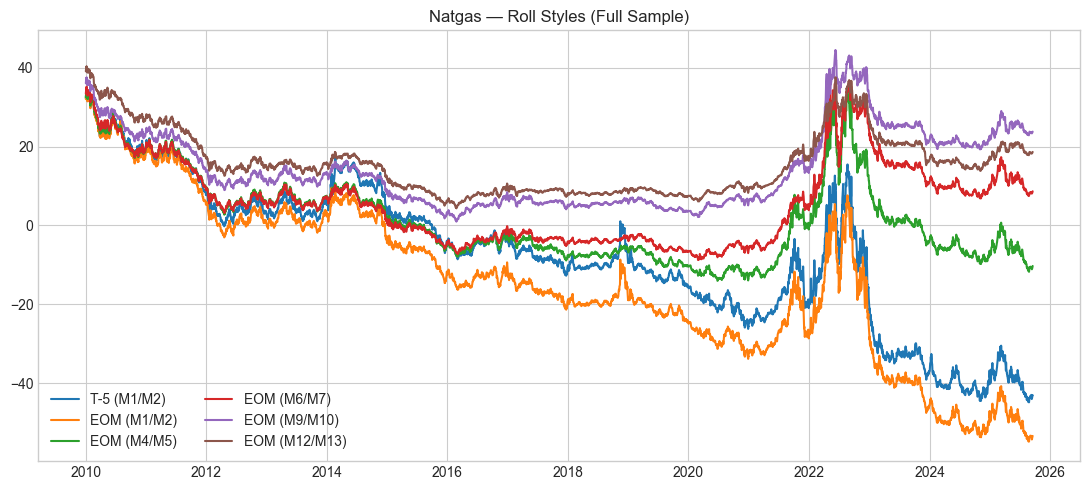

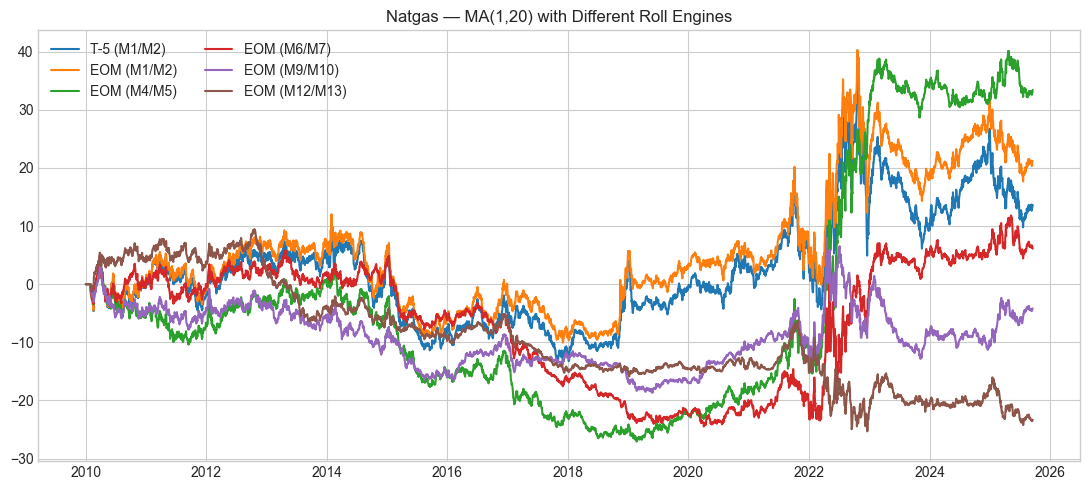

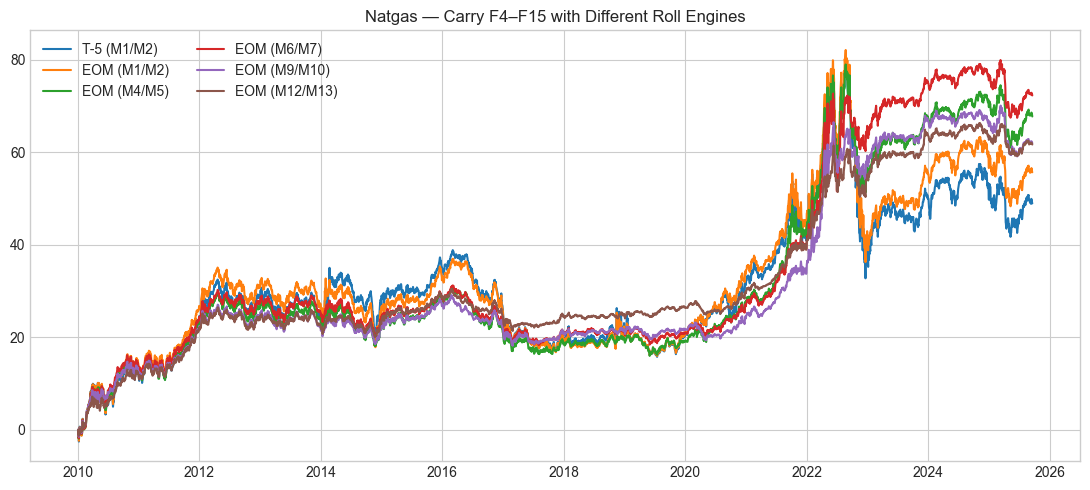

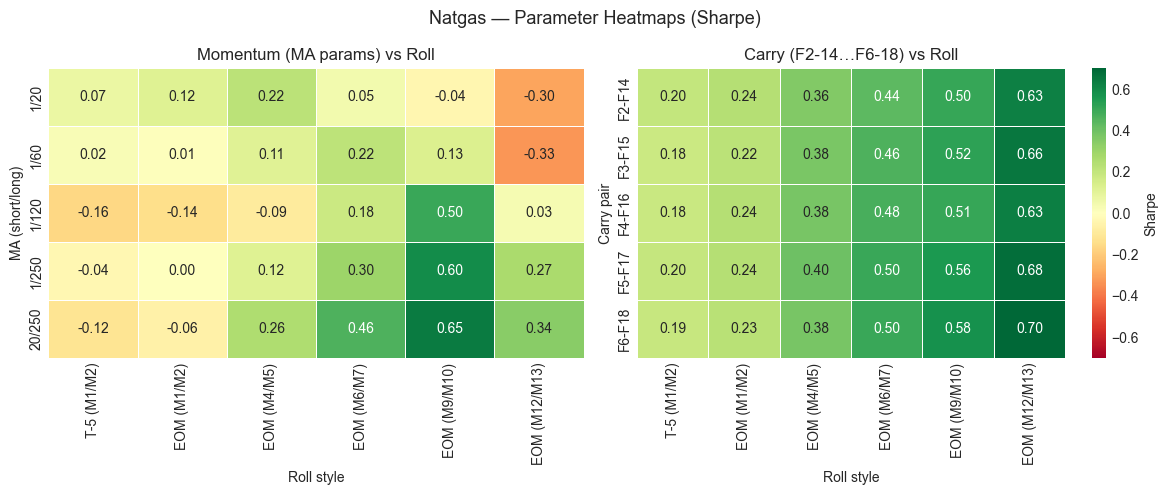

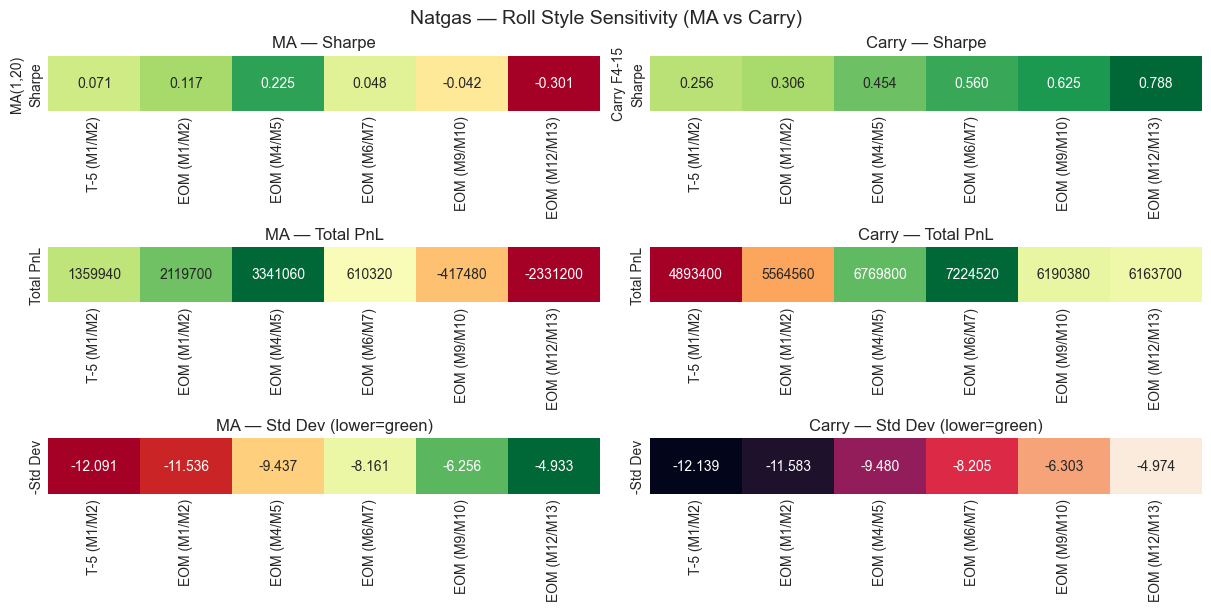

Total PnL   Total Cost  APL/unit  Std Dev (ann.)  Sharpe  \
style                                                                          
EOM (M1/M2)   -8,550,460.0000 -37,800.0000   -5.4390         11.5862 -0.4694   
EOM (M12/M13) -2,044,600.0000 -37,800.0000   -1.3006          4.9814 -0.2611   
EOM (M4/M5)   -4,283,980.0000 -37,800.0000   -2.7251          9.4856 -0.2873   
EOM (M6/M7)   -2,476,120.0000 -37,800.0000   -1.5751          8.2119 -0.1918   
EOM (M9/M10)  -1,226,220.0000 -37,800.0000   -0.7800          6.3087 -0.1236   
T-5 (M1/M2)   -7,540,680.0000 -37,800.0000   -4.7967         12.1429 -0.3950   

               Drawdown     RoD   Years  
style                                    
EOM (M1/M2)     -0.8723 -6.2352 15.7205  
EOM (M12/M13)   -0.3557 -3.6566 15.7205  
EOM (M4/M5)     -0.4762 -5.7228 15.7205  
EOM (M6/M7)     -0.4322 -3.6446 15.7205  
EOM (M9/M10)    -0.3604 -2.1640 15.7205  
T-5 (M1/M2)     -0.7777 -6.1680 15.7205

Total PnL  Total Cost  APL/unit  Std Dev (ann.)  \
style         strategy                                                         
EOM (M1/M2)   MA(1,20)  2,119,700.0000 90,100.0000    1.3484         11.5356   
EOM (M12/M13) MA(1,20) -2,331,200.0000 83,700.0000   -1.4829          4.9326   
EOM (M4/M5)   MA(1,20)  3,341,060.0000 87,900.0000    2.1253          9.4367   
EOM (M6/M7)   MA(1,20)    610,320.0000 85,100.0000    0.3882          8.1611   
EOM (M9/M10)  MA(1,20)   -417,480.0000 86,300.0000   -0.2656          6.2564   
T-5 (M1/M2)   MA(1,20)  1,359,940.0000 94,700.0000    0.8651         12.0908   

                        Sharpe  Drawdown     RoD   Years  
style         strategy                                    
EOM (M1/M2)   MA(1,20)  0.1169   -0.1991  6.7709 15.7205  
EOM (M12/M13) MA(1,20) -0.3006   -0.3178 -4.6668 15.7205  
EOM (M4/M5)   MA(1,20)  0.2252   -0.3051  6.9661 15.7205  
EOM (M6/M7)   MA(1,20)  0.0476   -0.2861  1.3568 15.7205  
EOM (M9/M10)  MA(1,20) -0.0424   -0.2108 -1.2596 15.7205  
T-5 (M1/M2)   MA(1,20)  0.0715   -0.2283  3.7891 15.7205

Total PnL  Total Cost  APL/unit  \
style         strategy                                           
EOM (M1/M2)   Carry F4-15 5,564,560.0000 13,300.0000    3.5397   
EOM (M12/M13) Carry F4-15 6,163,700.0000 13,300.0000    3.9208   
EOM (M4/M5)   Carry F4-15 6,769,800.0000 13,300.0000    4.3063   
EOM (M6/M7)   Carry F4-15 7,224,520.0000 13,300.0000    4.5956   
EOM (M9/M10)  Carry F4-15 6,190,380.0000 13,300.0000    3.9378   
T-5 (M1/M2)   Carry F4-15 4,893,400.0000 16,300.0000    3.1127   

                           Std Dev (ann.)  Sharpe  Drawdown     RoD   Years  
style         strategy                                                       
EOM (M1/M2)   Carry F4-15         11.5828  0.3056   -0.2517 14.0649 15.7205  
EOM (M12/M13) Carry F4-15          4.9744  0.7882   -0.0695 56.3919 15.7205  
EOM (M4/M5)   Carry F4-15          9.4804  0.4542   -0.1547 27.8407 15.7205  
EOM (M6/M7)   Carry F4-15          8.2054  0.5601   -0.1224 37.5334 15.7205  
EOM (M9/M10)  Carry F4-15          6.3025  0.6248   -0.0845 46.6200 15.7205  
T-5 (M1/M2)   Carry F4-15         12.1387  0.2564   -0.2610 11.9245 15.7205

In [9]:
# ---------------------------------------------------------------------
# NATGAS Roll — T-5 M1/M2 + EOM M1/M2 + EOM M4/M5 + EOM M6/M7 + EOM M9/M10 + EOM M12/M13
# + MA / Carry parameter heatmaps (Natgas-specific)
# ---------------------------------------------------------------------
commodity_name = "Natgas"
ticker, contracts, units, t_cost = COMMODITIES[commodity_name]

prices = load_prices(commodity_name, ticker)
expiry_cal = load_expiry(ticker)

# Natgas-specific collectors
ng_roll_metrics_list  = []
ng_ma_metrics_list    = []
ng_carry_metrics_list = []

# --- 1) T-5, M1/M2 ---------------------------------------------------
ng_res_t5_m12 = rolling_pnl(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
    roll_window=roll_window,
)
ng_res_t5_m12 = roll_EL(ng_res_t5_m12, prices, front_col="F1", t_cost=t_cost)

# --- 2) EOM midmonth, M1/M2 ------------------------------------------
ng_res_eom_m12 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F1",
    next_col="F2",
)
ng_res_eom_m12 = roll_EL(ng_res_eom_m12, prices, front_col="F1", t_cost=t_cost)

# --- 3) EOM midmonth, M4/M5 ------------------------------------------
ng_res_eom_m45 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F4",
    next_col="F5",
)
ng_res_eom_m45 = roll_EL(ng_res_eom_m45, prices, front_col="F4", t_cost=t_cost)

# --- 4) EOM midmonth, M6/M7 ------------------------------------------
ng_res_eom_m67 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F6",
    next_col="F7",
)
ng_res_eom_m67 = roll_EL(ng_res_eom_m67, prices, front_col="F6", t_cost=t_cost)

# --- 5) EOM midmonth, M9/M10 -----------------------------------------
ng_res_eom_m910 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F9",
    next_col="F10",
)
ng_res_eom_m910 = roll_EL(ng_res_eom_m910, prices, front_col="F9", t_cost=t_cost)

# --- 6) EOM midmonth, M12/M13 ----------------------------------------
ng_res_eom_m1213 = roll_EOM_midmonth_expiry(
    prices,
    expiry_cal,
    front_col="F12",
    next_col="F13",
)
ng_res_eom_m1213 = roll_EL(ng_res_eom_m1213, prices, front_col="F12", t_cost=t_cost)

# --- bundle for plotting / downstream strategies ---------------------
ng_roll_results = {
    "T-5 (M1/M2)":    ng_res_t5_m12,
    "EOM (M1/M2)":    ng_res_eom_m12,
    "EOM (M4/M5)":    ng_res_eom_m45,
    "EOM (M6/M7)":    ng_res_eom_m67,
    "EOM (M9/M10)":   ng_res_eom_m910,
    "EOM (M12/M13)":  ng_res_eom_m1213,
}

# keep front cols per style
ng_style_front_cols = {
    "T-5 (M1/M2)":   "F1",
    "EOM (M1/M2)":   "F1",
    "EOM (M4/M5)":   "F4",
    "EOM (M6/M7)":   "F6",
    "EOM (M9/M10)":  "F9",
    "EOM (M12/M13)": "F12",
}
ng_styles_order = list(ng_roll_results.keys())

# ---------------------------------------------------------------------
# 0. BASE ROLL CHART
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(ng_roll_results))

for (label, df_res), color in zip(ng_roll_results.items(), palette):
    ax.plot(df_res.index, df_res["equity_line"], label=label, color=color)

ax.set_title("Natgas — Roll Styles (Full Sample)")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# BASE ROLL METRICS (Natgas-only)
# ---------------------------------------------------------------------
for label, df_res in ng_roll_results.items():
    m = metrics(df_res, contracts=contracts, units=units)
    m["commodity"] = commodity_name
    m["style"] = label
    ng_roll_metrics_list.append(m)

# ---------------------------------------------------------------------
# 1. MA(1,20) ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
ng_ma_results = {}

for label, rolled_df in ng_roll_results.items():
    front_col_for_style = ng_style_front_cols[label]

    df_ma = momentum(
        prices=prices,
        rolled_df=rolled_df,
        front_col=front_col_for_style,
        short_ma=1,
        long_ma=20,
        t_cost=t_cost,
        epsilon=0.00,
    )
    ng_ma_results[label] = df_ma

    m_ma = metrics(df_ma, contracts=contracts, units=units)
    m_ma["commodity"] = commodity_name
    m_ma["style"] = label
    m_ma["strategy"] = "MA(1,20)"
    ng_ma_metrics_list.append(m_ma)

fig, ax = plt.subplots(figsize=(11, 5))
palette = sns.color_palette("tab10", len(ng_ma_results))

for (label, df_ma), color in zip(ng_ma_results.items(), palette):
    ax.plot(df_ma.index, df_ma["equity_line"], label=label, color=color)

ax.set_title("Natgas — MA(1,20) with Different Roll Engines")
ax.legend(loc="best", ncol=2)
ax.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 2. CARRY F4–F15 ON TOP OF EACH ROLL VARIANT
# ---------------------------------------------------------------------
ng_carry_results = {}

for label, rolled_df in ng_roll_results.items():
    if not {"F4", "F15"}.issubset(prices.columns):
        continue

    df_carry = carry(
        prices=prices,
        rolled_df=rolled_df,
        front_col="F4",
        end_col="F15",
        t_cost=t_cost,
        epsilon=0.00,
    )
    ng_carry_results[label] = df_carry

    m_c = metrics(df_carry, contracts=contracts, units=units)
    m_c["commodity"] = commodity_name
    m_c["style"] = label
    m_c["strategy"] = "Carry F4-15"
    ng_carry_metrics_list.append(m_c)

if ng_carry_results:
    fig, ax = plt.subplots(figsize=(11, 5))
    palette = sns.color_palette("tab10", len(ng_carry_results))

    for (label, df_carry), color in zip(ng_carry_results.items(), palette):
        ax.plot(df_carry.index, df_carry["equity_line"], label=label, color=color)

    ax.set_title("Natgas — Carry F4–F15 with Different Roll Engines")
    ax.legend(loc="best", ncol=2)
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 3. PARAMETER HEATMAPS (MA grid, Carry grid) — Natgas-specific
# ---------------------------------------------------------------------
ng_ma_sharpes = pd.DataFrame(
    index=[f"{s}/{l}" for (s, l) in ma_params],
    columns=ng_styles_order,
    dtype=float,
)

for roll_name, rolled_df in ng_roll_results.items():
    front_col_for_style = ng_style_front_cols[roll_name]
    for (sma, lma) in ma_params:
        df_ma_param = momentum(
            prices=prices,
            rolled_df=rolled_df,
            front_col=front_col_for_style,
            short_ma=sma,
            long_ma=lma,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_ma_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        ng_ma_sharpes.loc[f"{sma}/{lma}", roll_name] = sh

ng_carry_sharpes = pd.DataFrame(
    index=[f"F{f1}-F{f2}" for (f1, f2) in carry_pairs],
    columns=ng_styles_order,
    dtype=float,
)

for roll_name, rolled_df in ng_roll_results.items():
    for (f1, f2) in carry_pairs:
        c1, c2 = f"F{f1}", f"F{f2}"
        if c1 not in prices.columns or c2 not in prices.columns:
            continue

        df_c_param = carry(
            prices=prices,
            rolled_df=rolled_df,
            front_col=c1,
            end_col=c2,
            t_cost=t_cost,
            epsilon=0.00,
        )
        rets = df_c_param["equity_line"].diff().dropna()
        if rets.std() and not np.isnan(rets.std()) and rets.std() != 0:
            sh = rets.mean() / rets.std() * np.sqrt(252)
        else:
            sh = np.nan
        ng_carry_sharpes.loc[f"F{f1}-F{f2}", roll_name] = sh

# symmetric color
all_vals = np.concatenate(
    [
        ng_ma_sharpes.to_numpy().flatten(),
        ng_carry_sharpes.to_numpy().flatten(),
    ]
)
all_vals = all_vals[~np.isnan(all_vals)]
vlim = float(np.max(np.abs(all_vals))) if len(all_vals) else 1.0

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Natgas — Parameter Heatmaps (Sharpe)", fontsize=13)

sns.heatmap(
    ng_ma_sharpes,
    ax=axes[0],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
)
axes[0].set_title("Momentum (MA params) vs Roll")
axes[0].set_xlabel("Roll style")
axes[0].set_ylabel("MA (short/long)")

sns.heatmap(
    ng_carry_sharpes,
    ax=axes[1],
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0.0,
    vmin=-vlim,
    vmax=vlim,
    cbar=True,
    cbar_kws={"label": "Sharpe"},
    linewidths=0.5,
    linecolor="white",
)
axes[1].set_title("Carry (F2-14…F6-18) vs Roll")
axes[1].set_xlabel("Roll style")
axes[1].set_ylabel("Carry pair")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# NATGAS — Roll Style Sensitivity (MA vs Carry)
# ---------------------------------------------------------------------
ng_styles_order = [
    "T-5 (M1/M2)",
    "EOM (M1/M2)",
    "EOM (M4/M5)",
    "EOM (M6/M7)",
    "EOM (M9/M10)",
    "EOM (M12/M13)",
]

# build dfs from Natgas-only lists
ng_roll_df  = pd.DataFrame(ng_roll_metrics_list).set_index(["commodity", "style"])
ng_ma_df    = pd.DataFrame(ng_ma_metrics_list).set_index(["commodity", "style", "strategy"])
if ng_carry_metrics_list:
    ng_carry_df = pd.DataFrame(ng_carry_metrics_list).set_index(["commodity", "style", "strategy"])
else:
    ng_carry_df = pd.DataFrame()

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(12, 6),
    constrained_layout=True
)
fig.suptitle("Natgas — Roll Style Sensitivity (MA vs Carry)", fontsize=14)

# MA slice
ng_ma_base   = ng_ma_df.loc[("Natgas", slice(None), "MA(1,20)")]
ng_ma_sharpe = ng_ma_base["Sharpe"].reindex(ng_styles_order)
ng_ma_pnl    = ng_ma_base["Total PnL"].reindex(ng_styles_order)
ng_ma_std    = ng_ma_base["Std Dev (ann.)"].reindex(ng_styles_order)

# MA — Sharpe
ax = axes[0, 0]
ma_sharpe_df = pd.DataFrame(
    [ng_ma_sharpe.values],
    index=["Sharpe"],
    columns=ng_styles_order,
)
sns.heatmap(
    ma_sharpe_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    center=0.0,
    cbar=False,
)
ax.set_ylabel("MA(1,20)")
ax.set_xlabel("")
ax.set_title("MA — Sharpe")

# MA — Total PnL
ax = axes[1, 0]
ma_pnl_df = pd.DataFrame(
    [ng_ma_pnl.values],
    index=["Total PnL"],
    columns=ng_styles_order,
)
vmin = ma_pnl_df.min().min()
vmax = ma_pnl_df.max().max()
sns.heatmap(
    ma_pnl_df,
    ax=ax,
    annot=True,
    fmt=".0f",
    cmap="RdYlGn",
    vmin=vmin,
    vmax=vmax,
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Total PnL")

# MA — Std Dev (lower=green)
ax = axes[2, 0]
ma_std_df = pd.DataFrame(
    [(-ng_ma_std).values],
    index=["-Std Dev"],
    columns=ng_styles_order,
)
sns.heatmap(
    ma_std_df,
    ax=ax,
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",
    cbar=False,
)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("MA — Std Dev (lower=green)")

# Carry slice (if any)
has_carry = not ng_carry_df.empty
if has_carry:
    ng_carry_base = ng_carry_df.loc[("Natgas", slice(None), "Carry F4-15")]
    ng_carry_sharpe = ng_carry_base["Sharpe"].reindex(ng_styles_order)
    ng_carry_pnl    = ng_carry_base["Total PnL"].reindex(ng_styles_order)
    ng_carry_std    = ng_carry_base["Std Dev (ann.)"].reindex(ng_styles_order)

    # Carry — Sharpe
    ax = axes[0, 1]
    carry_sharpe_df = pd.DataFrame(
        [ng_carry_sharpe.values],
        index=["Sharpe"],
        columns=ng_styles_order,
    )
    sns.heatmap(
        carry_sharpe_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cmap="RdYlGn",
        center=0.0,
        cbar=False,
    )
    ax.set_ylabel("Carry F4-15")
    ax.set_xlabel("")
    ax.set_title("Carry — Sharpe")

    # Carry — Total PnL
    ax = axes[1, 1]
    carry_pnl_df = pd.DataFrame(
        [ng_carry_pnl.values],
        index=["Total PnL"],
        columns=ng_styles_order,
    )
    vmin = carry_pnl_df.min().min()
    vmax = carry_pnl_df.max().max()
    sns.heatmap(
        carry_pnl_df,
        ax=ax,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn",
        vmin=vmin,
        vmax=vmax,
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Total PnL")

    # Carry — Std Dev
    ax = axes[2, 1]
    carry_std_df = pd.DataFrame(
        [(-ng_carry_std).values],
        index=["-Std Dev"],
        columns=ng_styles_order,
    )
    sns.heatmap(
        carry_std_df,
        ax=ax,
        annot=True,
        fmt=".3f",
        cbar=False,
    )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("Carry — Std Dev (lower=green)")
else:
    for r in range(3):
        axes[r, 1].axis("off")

plt.show()

# ---------------------------------------------------------------------
# FINAL: Natgas-only metrics tables
# ---------------------------------------------------------------------
ng_roll_metrics_df  = ng_roll_df.loc["Natgas"].sort_index()
ng_ma_metrics_df    = ng_ma_df.loc[("Natgas", slice(None), slice(None))].sort_index()
try:
    ng_carry_metrics_df = ng_carry_df.loc[("Natgas", slice(None), slice(None))].sort_index()
except KeyError:
    ng_carry_metrics_df = pd.DataFrame()

display(ng_roll_metrics_df)
display(ng_ma_metrics_df)
display(ng_carry_metrics_df)



# Strategy Accumulators
- Cut sample to start 2015
- All rolling nearest M EOM
- Constant strategies chosen
    - MA: average of 20-120-250 corresponding to 1-month, 6 month, 1 year
    - EWMA: 20-60-120-180-250
    - Carry: F4-15 so we never use pre-roll data and benefit from deviating from early carry

Total PnL  Total Cost  APL/unit  Std Dev (ann.)  \
commodity style                                                          
Brent     eom_dynamic    25.9200     -2.5000    2.4190         23.9262   
Butane    eom_ngl        63.9286    -10.8360    5.9662         12.2511   
Ethane    eom_ngl       -14.8075    -10.8360   -1.3819          5.2446   
Gasoil    eom_mid        72.3557     -0.6980    6.7527         34.3887   
Natgas    eom_mid       -51.1734     -1.4848   -4.7758         12.7092   
Propane   eom_ngl        18.8710    -10.8360    1.7612         10.9014   
RBOB      eom_eom        88.6536     -2.1672    8.2737         29.1090   
ULSD      eom_eom        90.4722     -5.4180    8.4435         32.9445   
WTI       eom_mid        11.8100     -2.5800    1.1022         24.4496   

                       Sharpe  Drawdown     RoD   Years  
commodity style                                          
Brent     eom_dynamic  0.1011   -0.5303  4.5613 10.7151  
Butane    eom_ngl      0.4870   -0.3039 19.6329 10.7151  
Ethane    eom_ngl     -0.2635   -0.2199 -6.2847 10.7151  
Gasoil    eom_mid      0.1964   -0.6262 10.7845 10.7151  
Natgas    eom_mid     -0.3758   -0.5699 -8.3800 10.7151  
Propane   eom_ngl      0.1616   -0.3352  5.2536 10.7151  
RBOB      eom_eom      0.2842   -0.5659 14.6197 10.7151  
ULSD      eom_eom      0.2563   -0.6681 12.6374 10.7151  
WTI       eom_mid      0.0451   -0.7282  1.5136 10.7151

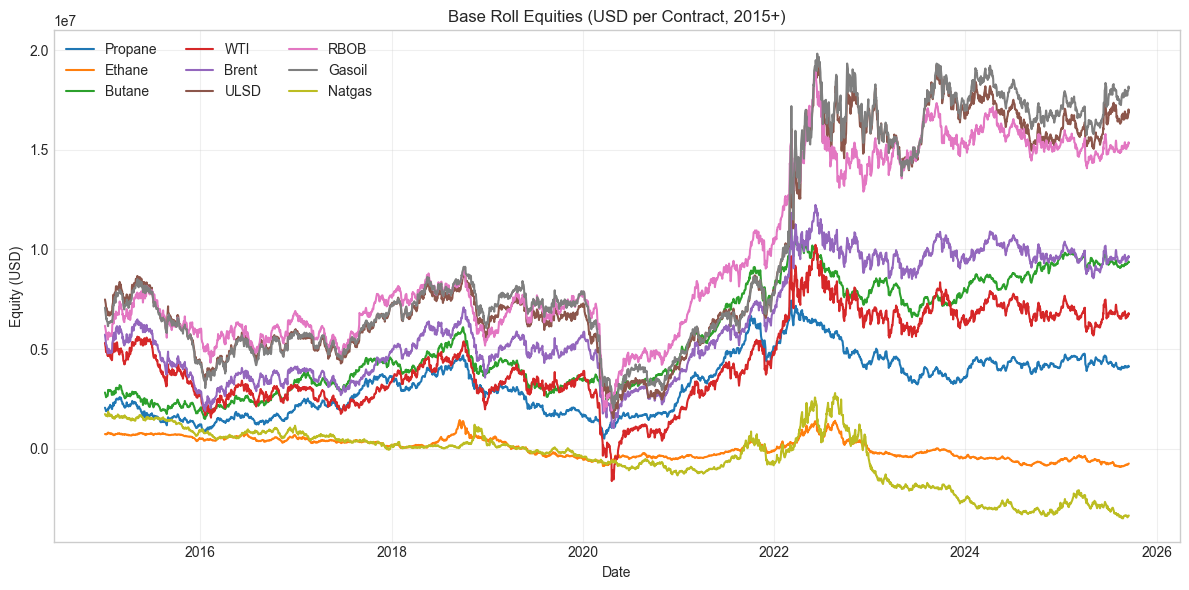

In [20]:
# ---------------------------------------------------------------------
# 0) Setup
# ---------------------------------------------------------------------
START_DATE = "2015-01-01"

BASE_ROLL_STYLES = {
    "Propane": {"style": "eom_ngl",     "mid_col": "F3", "far_col": "F4"},
    "Ethane":  {"style": "eom_ngl",     "mid_col": "F3", "far_col": "F4"},
    "Butane":  {"style": "eom_ngl",     "mid_col": "F3", "far_col": "F4"},
    "WTI":     {"style": "eom_mid",     "front_col": "F1", "next_col": "F2"},
    "Brent":   {"style": "eom_dynamic", "front_col": "F1", "next_col": "F2", "third_col": "F3"},
    "ULSD":    {"style": "eom_eom",     "next_col": "F2", "third_col": "F3"},
    "RBOB":    {"style": "eom_eom",     "next_col": "F2", "third_col": "F3"},
    "Gasoil":  {"style": "eom_mid",     "front_col": "F1", "next_col": "F2"},
    "Natgas":  {"style": "eom_mid",     "front_col": "F1", "next_col": "F2"},
}

ALL_BASE_ROLL = {}
ALL_BASE_METRICS = []

# ---------------------------------------------------------------------
# 1) Build base roll-equity per commodity (2015+)
# ---------------------------------------------------------------------
for commodity_name, (ticker, contracts, units, t_cost) in COMMODITIES.items():
    # prices already normalized by your loader (and carries attrs["norm_scale"])
    prices = load_prices(commodity_name, ticker, normalize=True)
    expiry_cal = load_expiry(ticker)
    prices = prices.loc[prices.index >= START_DATE]

    cfg   = BASE_ROLL_STYLES[commodity_name]
    style = cfg["style"]

    # scale t_cost consistently with normalization applied in the loader
    scale = float(prices.attrs.get("norm_scale", 1.0))
    t_cost_eff = t_cost * scale

    # ---- run the correct roll engine ----
    if style == "eom_ngl":
        rolled = roll_EOM_NGL(
            prices, expiry_cal,
            mid_col=cfg.get("mid_col", "F3"),
            far_col=cfg.get("far_col", "F4"),
        )
        eq_df = roll_EL(rolled, prices, front_col=cfg.get("mid_col", "F3"), t_cost=t_cost_eff)

    elif style == "eom_mid":
        rolled = roll_EOM_midmonth_expiry(
            prices, expiry_cal,
            front_col=cfg.get("front_col", "F1"),
            next_col=cfg.get("next_col", "F2"),
        )
        eq_df = roll_EL(rolled, prices, front_col=cfg.get("front_col", "F1"), t_cost=t_cost_eff)

    elif style == "eom_eom":
        rolled = roll_EOM_EOM_expiry(
            prices, expiry_cal,
            next_col=cfg.get("next_col", "F2"),
            third_col=cfg.get("third_col", "F3"),
        )
        eq_df = roll_EL(rolled, prices, front_col=cfg.get("next_col", "F2"), t_cost=t_cost_eff)

    elif style == "eom_dynamic":
        rolled = roll_EOM_dynamic_brent(
            prices, expiry_cal,
            front_col=cfg.get("front_col", "F1"),
            next_col=cfg.get("next_col", "F2"),
            third_col=cfg.get("third_col", "F3"),
        )
        eq_df = roll_EL(rolled, prices, front_col=cfg.get("next_col", "F2"), t_cost=t_cost_eff)

    else:
        raise ValueError(f"Unknown style {style} for {commodity_name}")

    # store (charts use this normalized equity directly)
    ALL_BASE_ROLL[commodity_name] = eq_df
    CLEAN_DATA[commodity_name] = prices

    # metrics on a comparable basis (unitless; avoids double-scaling)
    m = metrics(eq_df, contracts=1, units=1)
    m["commodity"] = commodity_name
    m["style"] = style
    ALL_BASE_METRICS.append(m)

# ---------------------------------------------------------------------
# 1b) Force a common trading calendar across all commodities
# ---------------------------------------------------------------------
# Build the intersection of dates across ALL_BASE_ROLL
common_index = None
for df in ALL_BASE_ROLL.values():
    common_index = df.index if common_index is None else common_index.intersection(df.index)

# (Optional) also enforce START_DATE, though your loop already trims
common_index = common_index[common_index >= pd.to_datetime(START_DATE)]
common_index = common_index.sort_values()

# Reindex ALL_BASE_ROLL and CLEAN_DATA to the common calendar
for k in list(ALL_BASE_ROLL.keys()):
    ALL_BASE_ROLL[k] = ALL_BASE_ROLL[k].reindex(common_index)
    # keep only cols present; drop all-NaN rows if any edge cases
    CLEAN_DATA[k]    = CLEAN_DATA[k].reindex(common_index).dropna(how="all")

# ---------------------------------------------------------------------
# 2) Metrics table (recompute after alignment)
# ---------------------------------------------------------------------
ALL_BASE_METRICS = []
for commodity_name, eq_df in ALL_BASE_ROLL.items():
    m = metrics(eq_df, contracts=1, units=1)
    m["commodity"] = commodity_name
    m["style"]     = BASE_ROLL_STYLES[commodity_name]["style"]
    ALL_BASE_METRICS.append(m)

base_metrics_df = (
    pd.DataFrame(ALL_BASE_METRICS)
      .set_index(["commodity", "style"])
      .sort_index()
)

display(base_metrics_df)

plt.figure(figsize=(12, 6))

for commodity_name, eq_df in ALL_BASE_ROLL.items():
    # get contract multiplier and units from COMMODITIES
    _, contracts, units, _ = COMMODITIES[commodity_name]
    # convert equity (normalized) back to USD
    equity_usd = eq_df["equity_line"] * contracts * units
    plt.plot(equity_usd.index, equity_usd, label=commodity_name)

plt.title("Base Roll Equities (USD per Contract, 2015+)")
plt.xlabel("Date")
plt.ylabel("Equity (USD)")
plt.legend(ncol=3)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



## Momentum

### MA Averaging -- arithmetic vs EWMA

Total PnL  Total Cost  APL/unit  \
commodity style                                                    
Brent     MA_simple[20,120,250]   -31.7600      5.5700   -2.9641   
Butane    MA_simple[20,120,250]    60.7706     16.1280    5.6715   
Ethane    MA_simple[20,120,250]     1.8169     17.6820    0.1696   
Gasoil    MA_simple[20,120,250]    70.5369      1.4094    6.5830   
Natgas    MA_simple[20,120,250]   -23.7278      3.4046   -2.2144   
Propane   MA_simple[20,120,250]    63.8480     14.5740    5.9587   
RBOB      MA_simple[20,120,250]   -71.9670      5.1156   -6.7164   
ULSD      MA_simple[20,120,250]    48.2580     11.3610    4.5038   
WTI       MA_simple[20,120,250]   -38.6500      5.4500   -3.6071   

                                 Std Dev (ann.)  Sharpe  Drawdown     RoD  \
commodity style                                                             
Brent     MA_simple[20,120,250]         23.9738 -0.1236   -0.5752 -5.1528   
Butane    MA_simple[20,120,250]         12.2831  0.4617   -0.2154 26.3343   
Ethane    MA_simple[20,120,250]          5.2704  0.0322   -0.2274  0.7458   
Gasoil    MA_simple[20,120,250]         34.5287  0.1907   -0.4227 15.5718   
Natgas    MA_simple[20,120,250]         12.7209 -0.1741   -0.4924 -4.4969   
Propane   MA_simple[20,120,250]         10.9204  0.5457   -0.1723 34.5747   
RBOB      MA_simple[20,120,250]         29.1706 -0.2302   -0.8723 -7.7001   
ULSD      MA_simple[20,120,250]         33.0280  0.1364   -0.4338 10.3833   
WTI       MA_simple[20,120,250]         24.5117 -0.1472   -0.5773 -6.2483   

                                  Years  
commodity style                          
Brent     MA_simple[20,120,250] 10.7151  
Butane    MA_simple[20,120,250] 10.7151  
Ethane    MA_simple[20,120,250] 10.7151  
Gasoil    MA_simple[20,120,250] 10.7151  
Natgas    MA_simple[20,120,250] 10.7151  
Propane   MA_simple[20,120,250] 10.7151  
RBOB      MA_simple[20,120,250] 10.7151  
ULSD      MA_simple[20,120,250] 10.7151  
WTI       MA_simple[20,120,250] 10.7151

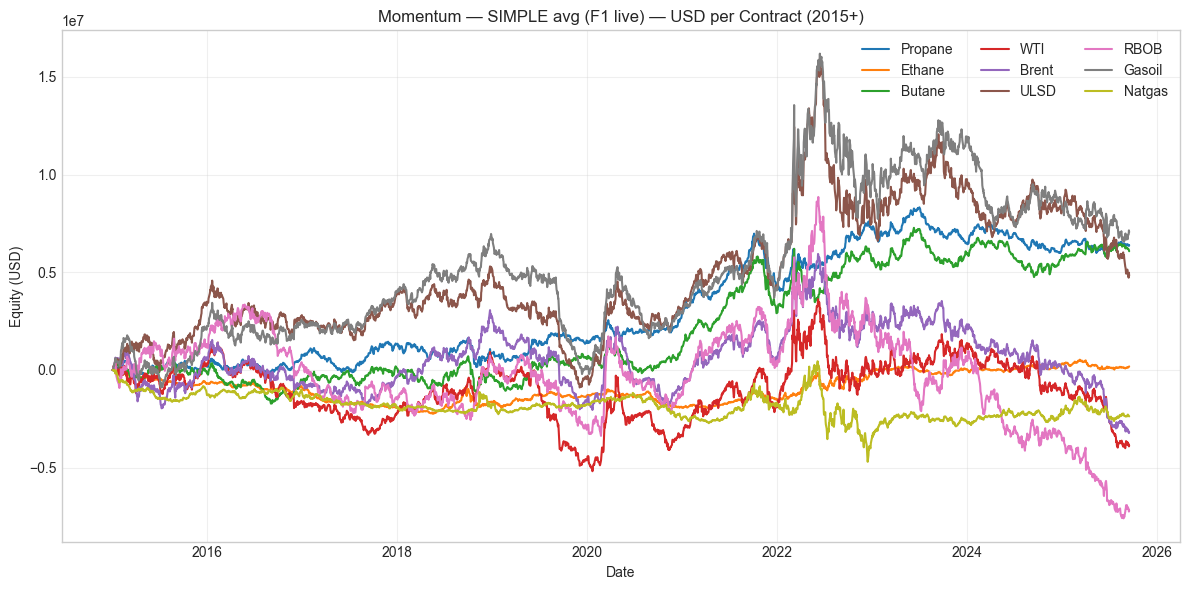

Total PnL  Total Cost  APL/unit  \
commodity style                                                           
Brent     MA_ewma[20,120,250;lam=0.05]   -44.5200      5.6900   -4.1549   
Butane    MA_ewma[20,120,250;lam=0.05]    73.1161     16.5060    6.8237   
Ethane    MA_ewma[20,120,250;lam=0.05]     1.4876     17.7660    0.1388   
Gasoil    MA_ewma[20,120,250;lam=0.05]    41.9329      1.4899    3.9135   
Natgas    MA_ewma[20,120,250;lam=0.05]   -26.7554      3.5090   -2.4970   
Propane   MA_ewma[20,120,250;lam=0.05]    64.2461     14.4900    5.9959   
RBOB      MA_ewma[20,120,250;lam=0.05]   -53.1258      5.0316   -4.9580   
ULSD      MA_ewma[20,120,250;lam=0.05]    27.4428     12.0750    2.5611   
WTI       MA_ewma[20,120,250;lam=0.05]   -27.5700      5.5700   -2.5730   

                                        Std Dev (ann.)  Sharpe  Drawdown  \
commodity style                                                            
Brent     MA_ewma[20,120,250;lam=0.05]         23.9742 -0.1733   -0.6610   
Butane    MA_ewma[20,120,250;lam=0.05]         12.2816  0.5556   -0.2294   
Ethane    MA_ewma[20,120,250;lam=0.05]          5.2707  0.0263   -0.2260   
Gasoil    MA_ewma[20,120,250;lam=0.05]         34.5308  0.1133   -0.4665   
Natgas    MA_ewma[20,120,250;lam=0.05]         12.7212 -0.1963   -0.5009   
Propane   MA_ewma[20,120,250;lam=0.05]         10.9192  0.5491   -0.1707   
RBOB      MA_ewma[20,120,250;lam=0.05]         29.1724 -0.1700   -0.7762   
ULSD      MA_ewma[20,120,250;lam=0.05]         33.0313  0.0775   -0.4833   
WTI       MA_ewma[20,120,250;lam=0.05]         24.5118 -0.1050   -0.5834   

                                           RoD   Years  
commodity style                                         
Brent     MA_ewma[20,120,250;lam=0.05] -6.2855 10.7151  
Butane    MA_ewma[20,120,250;lam=0.05] 29.7467 10.7151  
Ethane    MA_ewma[20,120,250;lam=0.05]  0.6142 10.7151  
Gasoil    MA_ewma[20,120,250;lam=0.05]  8.3888 10.7151  
Natgas    MA_ewma[20,120,250;lam=0.05] -4.9845 10.7151  
Propane   MA_ewma[20,120,250;lam=0.05] 35.1344 10.7151  
RBOB      MA_ewma[20,120,250;lam=0.05] -6.3875 10.7151  
ULSD      MA_ewma[20,120,250;lam=0.05]  5.2989 10.7151  
WTI       MA_ewma[20,120,250;lam=0.05] -4.4102 10.7151

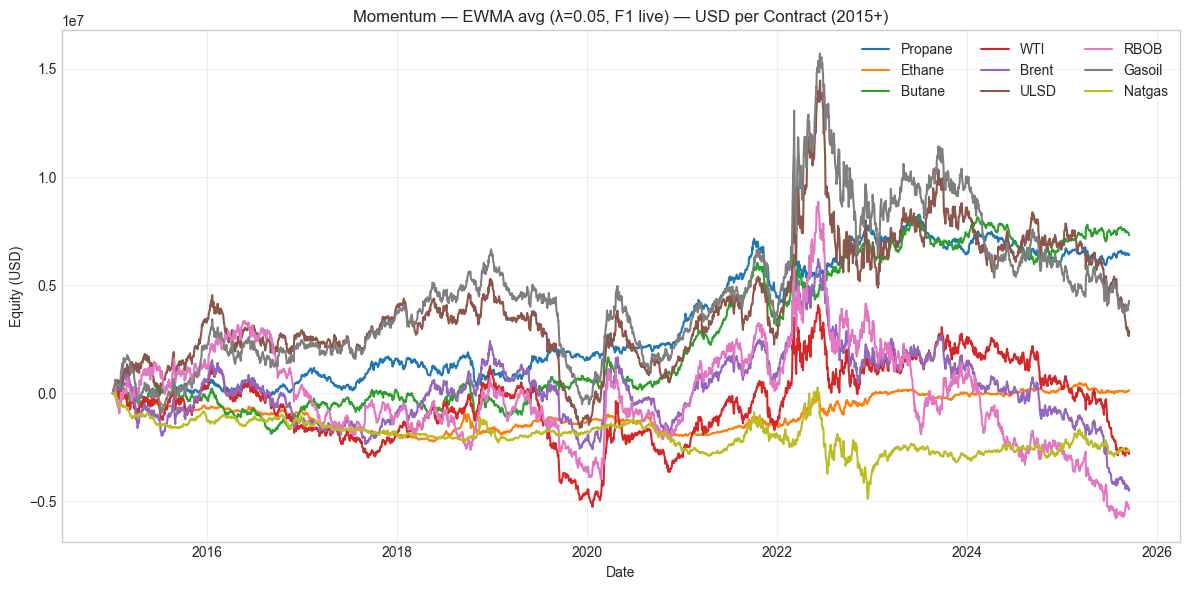

In [21]:
# =====================================================================
# Momentum (Signal-level, F1 live for ALL)
# Two separate runs: SIMPLE avg vs EWMA avg across (20,60,120,180,250)
# Saves per-commodity DataFrames + cross-commodity PnL matrices
# for the next step (EW, Risk Parity, MVO).
# =====================================================================

# if your functions live in momentum.py:
# from momentum import momentum_ma_simple, momentum_ma_ewma

MA_LOOKBACKS = (20, 120, 250)
EWMA_LAMBDA  = 0.05   # decay for EWMA across horizons

def _build_rolled_df(prices: pd.DataFrame, expiry_cal: pd.DatetimeIndex, cfg: dict) -> pd.DataFrame:
    """Recreate the rolled_df that feeds the momentum engine."""
    style = cfg["style"]
    if style == "eom_ngl":
        return roll_EOM_NGL(prices, expiry_cal,
                            mid_col=cfg.get("mid_col", "F3"),
                            far_col=cfg.get("far_col", "F4"))
    elif style == "eom_mid":
        return roll_EOM_midmonth_expiry(prices, expiry_cal,
                                        front_col=cfg.get("front_col", "F1"),
                                        next_col=cfg.get("next_col", "F2"))
    elif style == "eom_eom":
        return roll_EOM_EOM_expiry(prices, expiry_cal,
                                   next_col=cfg.get("next_col", "F2"),
                                   third_col=cfg.get("third_col", "F3"))
    elif style == "eom_dynamic":
        return roll_EOM_dynamic_brent(prices, expiry_cal,
                                      front_col=cfg.get("front_col", "F1"),
                                      next_col=cfg.get("next_col", "F2"),
                                      third_col=cfg.get("third_col", "F3"))
    else:
        raise ValueError(f"Unknown style {style}")

def _plot_curves_usd(curves_dict, title_prefix):
    plt.figure(figsize=(12, 6))
    for commodity_name, pnl_df in curves_dict.items():
        _, contracts, units, _ = COMMODITIES[commodity_name]
        equity_usd = pnl_df["equity_line"] * contracts * units
        plt.plot(equity_usd.index, equity_usd, label=commodity_name)
    plt.title(f"{title_prefix} — USD per Contract (2015+)")
    plt.xlabel("Date"); plt.ylabel("Equity (USD)")
    plt.legend(ncol=3); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# A) SIMPLE arithmetic average block (F1 live leg)
# ---------------------------------------------------------------------
ALL_MA_SIMPLE = {}      # per-commodity DataFrames (daily_pnl, t_cost, net_pnl, equity_line, ...)
ALL_MA_SIMPLE_METRICS = []

for commodity_name, (ticker, contracts, units, t_cost) in COMMODITIES.items():
    prices = CLEAN_DATA[commodity_name]                 # normalized + already truncated to START_DATE
    expiry_cal = load_expiry(ticker)
    rolled_df  = _build_rolled_df(prices, expiry_cal, BASE_ROLL_STYLES[commodity_name])

    # t-cost scaled consistent with loader normalization
    scale = float(prices.attrs.get("norm_scale", 1.0))
    t_cost_eff = t_cost * scale

    pnl_simple = momentum_ma_simple(prices, rolled_df, front_col="F1",
                                lookbacks=(20,60,120,180,250),
                                t_cost=t_cost_eff, epsilon=0.0, warm_start=True)
    
    ALL_MA_SIMPLE[commodity_name] = pnl_simple

    m_simple = metrics(pnl_simple, contracts=1, units=1)
    m_simple["commodity"] = commodity_name
    m_simple["style"]     = f"MA_simple[{','.join(map(str,MA_LOOKBACKS))}]"
    ALL_MA_SIMPLE_METRICS.append(m_simple)

ma_simple_metrics_df = (
    pd.DataFrame(ALL_MA_SIMPLE_METRICS)
      .set_index(["commodity", "style"])
      .sort_index()
)
display(ma_simple_metrics_df)

# Cross-commodity matrices (aligned indices) for portfolio step
MA_PNL_SIMPLE    = pd.concat({k: v["net_pnl"]     for k, v in ALL_MA_SIMPLE.items()}, axis=1).sort_index()
MA_EQUITY_SIMPLE = pd.concat({k: v["equity_line"] for k, v in ALL_MA_SIMPLE.items()}, axis=1).sort_index()

# Quick sanity check plot (USD per contract)
_plot_curves_usd(ALL_MA_SIMPLE, "Momentum — SIMPLE avg (F1 live)")

# ---------------------------------------------------------------------
# B) EWMA average block (F1 live leg)
# ---------------------------------------------------------------------
ALL_MA_EWMA = {}
ALL_MA_EWMA_METRICS = []

for commodity_name, (ticker, contracts, units, t_cost) in COMMODITIES.items():
    prices = CLEAN_DATA[commodity_name]
    expiry_cal = load_expiry(ticker)
    rolled_df  = _build_rolled_df(prices, expiry_cal, BASE_ROLL_STYLES[commodity_name])

    scale = float(prices.attrs.get("norm_scale", 1.0))
    t_cost_eff = t_cost * scale

    pnl_ewma   = momentum_ma_ewma(prices, rolled_df, front_col="F1",
                              lookbacks=(20,60,120,180,250), lam=0.05,
                              t_cost=t_cost_eff, epsilon=0.0, warm_start=True)
    ALL_MA_EWMA[commodity_name] = pnl_ewma

    m_ewma = metrics(pnl_ewma, contracts=1, units=1)
    m_ewma["commodity"] = commodity_name
    m_ewma["style"]     = f"MA_ewma[{','.join(map(str,MA_LOOKBACKS))};lam={EWMA_LAMBDA}]"
    ALL_MA_EWMA_METRICS.append(m_ewma)

ma_ewma_metrics_df = (
    pd.DataFrame(ALL_MA_EWMA_METRICS)
      .set_index(["commodity", "style"])
      .sort_index()
)
display(ma_ewma_metrics_df)

# Cross-commodity matrices for portfolio step
MA_PNL_EWMA     = pd.concat({k: v["net_pnl"]     for k, v in ALL_MA_EWMA.items()}, axis=1).sort_index()
MA_EQUITY_EWMA  = pd.concat({k: v["equity_line"] for k, v in ALL_MA_EWMA.items()}, axis=1).sort_index()

_plot_curves_usd(ALL_MA_EWMA, f"Momentum — EWMA avg (λ={EWMA_LAMBDA}, F1 live)")



## Carry

Total PnL  Total Cost  APL/unit  Std Dev (ann.)  \
commodity style                                                           
Brent     Carry_F4-F15    78.5500      3.2000    7.3308         23.9522   
Butane    Carry_F4-F15    45.7918     15.4140    4.2736         12.2734   
Ethane    Carry_F4-F15    -6.6478     14.7840   -0.6204          5.2448   
Gasoil    Carry_F4-F15   104.9101      0.9289    9.7909         34.5014   
Natgas    Carry_F4-F15    27.6370      2.1170    2.5793         12.7084   
Propane   Carry_F4-F15    34.9885     13.1040    3.2654         10.9155   
RBOB      Carry_F4-F15    81.4422      2.7216    7.6007         29.1618   
ULSD      Carry_F4-F15   115.0506      7.4340   10.7373         33.0033   
WTI       Carry_F4-F15    76.5000      3.0200    7.1395         24.4938   

                        Sharpe  Drawdown     RoD   Years  
commodity style                                           
Brent     Carry_F4-F15  0.3061   -0.2445 29.9814 10.7151  
Butane    Carry_F4-F15  0.3482   -0.2937 14.5525 10.7151  
Ethane    Carry_F4-F15 -0.1183   -0.1980 -3.1338 10.7151  
Gasoil    Carry_F4-F15  0.2838   -0.2854 34.3008 10.7151  
Natgas    Carry_F4-F15  0.2030   -0.2971  8.6829 10.7151  
Propane   Carry_F4-F15  0.2991   -0.2513 12.9947 10.7151  
RBOB      Carry_F4-F15  0.2606   -0.3542 21.4559 10.7151  
ULSD      Carry_F4-F15  0.3253   -0.2589 41.4711 10.7151  
WTI       Carry_F4-F15  0.2915   -0.2263 31.5504 10.7151

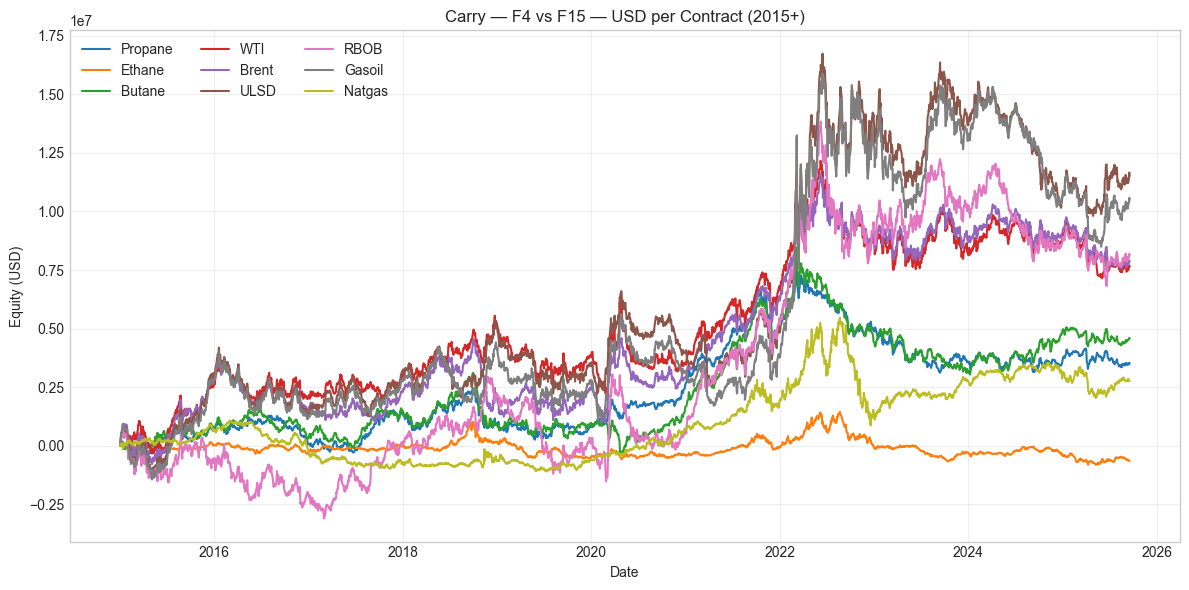

In [22]:
# =====================================================================
# Carry — F4 vs F15 across ALL commodities (consistent cross-asset definition)
# =====================================================================

START_COL_CARRY = "F4"     # mid-curve start
END_COL_CARRY   = "F15"    # long-end anchor
ALL_CARRY = {}
ALL_CARRY_METRICS = []

def _plot_curves_usd(curves_dict, title_prefix):
    plt.figure(figsize=(12, 6))
    for commodity_name, pnl_df in curves_dict.items():
        _, contracts, units, _ = COMMODITIES[commodity_name]
        equity_usd = pnl_df["equity_line"] * contracts * units
        plt.plot(equity_usd.index, equity_usd, label=commodity_name)
    plt.title(f"{title_prefix} — USD per Contract (2015+)")
    plt.xlabel("Date"); plt.ylabel("Equity (USD)")
    plt.legend(ncol=3)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

for commodity_name, (ticker, contracts, units, t_cost) in COMMODITIES.items():
    prices     = CLEAN_DATA[commodity_name]                 # normalized, truncated to START_DATE
    expiry_cal = load_expiry(ticker)
    rolled_df  = _build_rolled_df(prices, expiry_cal, BASE_ROLL_STYLES[commodity_name])

    # scale t_cost to match normalization used by loader
    scale = float(prices.attrs.get("norm_scale", 1.0))
    t_cost_eff = t_cost * scale

    # --- Carry = F4 − F15 ---
    pnl_carry = carry(
        prices,
        rolled_df,
        front_col=START_COL_CARRY,
        end_col=END_COL_CARRY,
        t_cost=t_cost_eff,
        epsilon=0.0,
    )

    ALL_CARRY[commodity_name] = pnl_carry

    m = metrics(pnl_carry, contracts=1, units=1)
    m["commodity"] = commodity_name
    m["style"]     = f"Carry_{START_COL_CARRY}-{END_COL_CARRY}"
    ALL_CARRY_METRICS.append(m)

# Metrics table
carry_metrics_df = (
    pd.DataFrame(ALL_CARRY_METRICS)
      .set_index(["commodity", "style"])
      .sort_index()
)
display(carry_metrics_df)

# Portfolio-ready matrices (PnL & equity)
CARRY_PNL = (
    pd.concat({k: v["net_pnl"] for k, v in ALL_CARRY.items()}, axis=1)
      .sort_index()
)
CARRY_EQUITY = (
    pd.concat({k: v["equity_line"] for k, v in ALL_CARRY.items()}, axis=1)
      .sort_index()
)

# Sanity-check plot (USD per contract)
_plot_curves_usd(ALL_CARRY, f"Carry — {START_COL_CARRY} vs {END_COL_CARRY}")



# Portfolios
- NGLs, 6-Pack, together

## MA Portoflios

In [29]:
# =====================================================================
# EXPORT: Momentum (SIMPLE) + Carry → Excel  (per-bbl + USD reference)
# + Equal-cash seeding at t0 (EW example): q_i = C * w_i / p0_i
# =====================================================================
import os
from datetime import datetime
import pandas as pd
import numpy as np

SEED_CAPITAL = 1_000_000.0   # <-- change if you want a different example seed

def _ensure_series(obj, index, *, prefer_cols=("avg", "combined")):
    if obj is None:
        return pd.Series(index=index, dtype=float)
    if isinstance(obj, pd.Series):
        return obj.reindex(index)
    if isinstance(obj, pd.DataFrame):
        for c in prefer_cols:
            if c in obj.columns:
                return obj[c].reindex(index)
        if obj.shape[1] == 1:
            return obj.iloc[:, 0].reindex(index)
        return obj.mean(axis=1)
    s = pd.Series(obj)
    return s.reindex(index) if len(s) == len(index) else pd.Series(index=index, dtype=float)

def _per_bbl_auto(name: str, s: pd.Series) -> pd.Series:
    try:
        loader_scale = float(CLEAN_DATA[name].attrs.get("norm_scale", 1.0))
    except Exception:
        loader_scale = 1.0
    if abs(loader_scale - 1.0) > 1e-12:
        return s
    return s * float(NORMALIZATION.get(name, 1.0))

def _usd_per_contract(name: str, s: pd.Series) -> pd.Series:
    contracts, units = COMMODITIES[name][1], COMMODITIES[name][2]
    out = s * contracts * units
    if name == "Gasoil":
        out = out / 7.45  # ton → bbl correction so USD sheets are comparable
    return out

def _t0_per_bbl_price(name: str) -> tuple[pd.Timestamp, float]:
    cfg = BASE_ROLL_STYLES[name]
    front = cfg.get("front_col", "F1")
    ser = CLEAN_DATA[name][front].dropna()
    if ser.empty:
        return (pd.NaT, np.nan)
    p0 = _per_bbl_auto(name, ser).iloc[0]
    return (ser.index[0], float(p0))

# ---------- paths ----------
os.makedirs("exports", exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
xlsx_path = f"exports/strategies_equity_{stamp}.xlsx"

# ---------- per-bbl matrices ----------
ma_equity_perbbl = pd.concat({k: _per_bbl_auto(k, v["equity_line"])
                              for k, v in ALL_MA_SIMPLE.items()}, axis=1).sort_index()
carry_equity_perbbl = pd.concat({k: _per_bbl_auto(k, v["equity_line"])
                                 for k, v in ALL_CARRY.items()}, axis=1).sort_index()

# ---------- USD/contract (reference only) ----------
ma_equity_usd = pd.concat({k: _usd_per_contract(k, v["equity_line"])
                           for k, v in ALL_MA_SIMPLE.items()}, axis=1).sort_index()
carry_equity_usd = pd.concat({k: _usd_per_contract(k, v["equity_line"])
                              for k, v in ALL_CARRY.items()}, axis=1).sort_index()

# ---------- t0 sizing table ----------
sizing_rows = []
for name in sorted(CLEAN_DATA.keys()):
    t0, p0 = _t0_per_bbl_price(name)
    sizing_rows.append({
        "commodity": name,
        "t0_date": t0,
        "t0_price_per_bbl": p0,
        "bbl_per_$1": (0.0 if not np.isfinite(p0) or p0 == 0 else 1.0 / p0),
        "bbl_per_$1mm": (0.0 if not np.isfinite(p0) or p0 == 0 else 1_000_000.0 / p0),
    })
sizing_df = pd.DataFrame(sizing_rows).set_index("commodity").sort_index()

# ---------- helper: build EW cash-seeded portfolio sheets ----------
def _cash_seed_bundle(perbbl_df: pd.DataFrame, label: str):
    # Equal weights over available columns
    cols = perbbl_df.columns.tolist()
    n = len(cols)
    w = pd.Series(1.0 / n, index=cols, name="weight_EW")

    # get p0 (per-bbl) from sizing_df
    p0 = sizing_df.reindex(cols)["t0_price_per_bbl"]
    # positions in barrels at t0: q_i = C * w_i / p0_i
    q = SEED_CAPITAL * w / p0
    q.name = "position_bbl"

    # per-commodity $PnL series (per-bbl × q_i)
    pnl_usd = perbbl_df.multiply(q, axis=1)
    # portfolio $PnL and equity
    port_pnl = pnl_usd.sum(axis=1).rename("portfolio_pnl_usd")
    port_eq = port_pnl.cumsum().rename("portfolio_equity_usd")
    port_df = pd.concat([port_pnl, port_eq], axis=1)

    # positions table for export
    pos_tbl = pd.DataFrame({
        "weight_EW": w,
        "t0_price_per_bbl": p0,
        "position_bbl": q,
        "seed_capital_used_$": (SEED_CAPITAL * w).round(2),
    }).rename_axis("commodity")

    return pos_tbl, pnl_usd, port_df

mom_pos, mom_pnl_usd, mom_port = _cash_seed_bundle(ma_equity_perbbl, "Momentum")
car_pos, car_pnl_usd, car_port = _cash_seed_bundle(carry_equity_perbbl, "Carry")

# ---------- write workbook ----------
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as xlw:
    # Summaries (per-bbl + USD per contract)
    ma_equity_perbbl.to_excel(xlw, sheet_name="Momentum_All_Equity_perBBL", index_label="Date")
    ma_equity_usd.to_excel(xlw,     sheet_name="Momentum_All_Equity_USD",    index_label="Date")
    carry_equity_perbbl.to_excel(xlw, sheet_name="Carry_All_Equity_perBBL", index_label="Date")
    carry_equity_usd.to_excel(xlw,     sheet_name="Carry_All_Equity_USD",    index_label="Date")

    # Per-commodity detail (Momentum)
    for name, pnl_df in ALL_MA_SIMPLE.items():
        idx = pnl_df.index
        eq_line   = pnl_df["equity_line"]
        net_pnl   = _ensure_series(pnl_df.get("net_pnl"), index=idx)
        daily_pnl = _ensure_series(pnl_df.get("daily_pnl"), index=idx)
        out = pd.DataFrame({
            "equity_per_bbl":        _per_bbl_auto(name, eq_line),
            "net_pnl_per_bbl":       _per_bbl_auto(name, net_pnl),
            "daily_pnl_per_bbl":     _per_bbl_auto(name, daily_pnl),
            "equity_usd_per_contract": _usd_per_contract(name, eq_line),  # reference only
            "equity_line_native":    eq_line,
        })
        out.to_excel(xlw, sheet_name=f"Momentum_{name[:28]}_perBBL", index_label="Date")

    # Per-commodity detail (Carry)
    for name, pnl_df in ALL_CARRY.items():
        idx = pnl_df.index
        eq_line   = pnl_df["equity_line"]
        net_pnl   = _ensure_series(pnl_df.get("net_pnl"), index=idx)
        daily_pnl = _ensure_series(pnl_df.get("daily_pnl"), index=idx)
        out = pd.DataFrame({
            "equity_per_bbl":        _per_bbl_auto(name, eq_line),
            "net_pnl_per_bbl":       _per_bbl_auto(name, net_pnl),
            "daily_pnl_per_bbl":     _per_bbl_auto(name, daily_pnl),
            "equity_usd_per_contract": _usd_per_contract(name, eq_line),  # reference only
            "equity_line_native":    eq_line,
        })
        out.to_excel(xlw, sheet_name=f"Carry_{name[:28]}_perBBL", index_label="Date")

    # Sizing + cash-seeded examples
    sizing_df.to_excel(xlw, sheet_name="Sizing_t0_perBBL")
    mom_pos.to_excel(xlw, sheet_name="Momentum_Positions_EW_t0")
    car_pos.to_excel(xlw, sheet_name="Carry_Positions_EW_t0")
    mom_pnl_usd.to_excel(xlw, sheet_name="Momentum_PnL_$ (EW t0)", index_label="Date")
    car_pnl_usd.to_excel(xlw, sheet_name="Carry_PnL_$ (EW t0)", index_label="Date")
    mom_port.to_excel(xlw, sheet_name="Momentum_Portfolio_EW", index_label="Date")
    car_port.to_excel(xlw, sheet_name="Carry_Portfolio_EW", index_label="Date")

    # Notes
    notes = pd.DataFrame({
        "section": ["Normalization", "Cash Seeding", "Momentum", "Carry", "Run"],
        "details": [
            "Per-bbl series come from loader (norm_scale!=1) or via one-time NORMALIZATION here. No double scaling. USD/contract fixes Gasoil by /7.45.",
            "Equal-cash at t0 example: q_i = C * w_i / p0_i with C={:,}. You can recompute with your own weights.".format(int(SEED_CAPITAL)),
            "SIMPLE arithmetic MA; lookbacks=(20,60,120,180,250); F1 live leg.",
            f"Carry = {START_COL_CARRY}–{END_COL_CARRY}.",
            f"Start={START_DATE}; timestamp={stamp}",
        ],
    })
    notes.to_excel(xlw, sheet_name="Notes", index=False)

print(f"✅ Wrote combined workbook: {xlsx_path}")



✅ Wrote combined workbook: exports/strategies_equity_20251104_152700.xlsx


### MA Risk Parity


[EW static (MA_EWMA)] Top 5 weights in last quarter (2025-09-30):


Propane  Ethane  Butane    WTI  Brent
weight   0.1111  0.1111  0.1111 0.1111 0.1111

[EW static (MA_EWMA)] Top 5 average weights across all quarters:


Propane  Ethane  Butane    WTI  Brent
avg_weight   0.1111  0.1111  0.1111 0.1111 0.1111


[RP static (MA_EWMA)] Top 5 weights in last quarter (2025-09-30):


Ethane  Natgas  Propane  Butane    WTI
weight  0.3559  0.1613   0.1341  0.1239 0.0500

[RP static (MA_EWMA)] Top 5 average weights across all quarters:


Ethane  Natgas  Propane  Butane    WTI
avg_weight  0.3559  0.1613   0.1341  0.1239 0.0500


[RP dynamic (MA_EWMA)] Top 5 weights in last quarter (2025-09-30):


Propane  Natgas    WTI  Brent  Gasoil
weight   0.3526  0.3160 0.0928 0.0889  0.0772

[RP dynamic (MA_EWMA)] Top 5 average weights across all quarters:


Ethane  Natgas  Propane  Butane  Gasoil
avg_weight  0.3524  0.1645   0.1440  0.1071  0.0489


[MVO (MA_EWMA)] Top 5 weights in last quarter (2025-09-30):


Butane  Ethane   RBOB    WTI   ULSD
weight  0.4177  0.4177 0.1121 0.0172 0.0147

[MVO (MA_EWMA)] Top 5 average weights across all quarters:


Ethane  Natgas  Propane  Butane   RBOB
avg_weight  0.4298  0.3144   0.1016  0.0895 0.0192

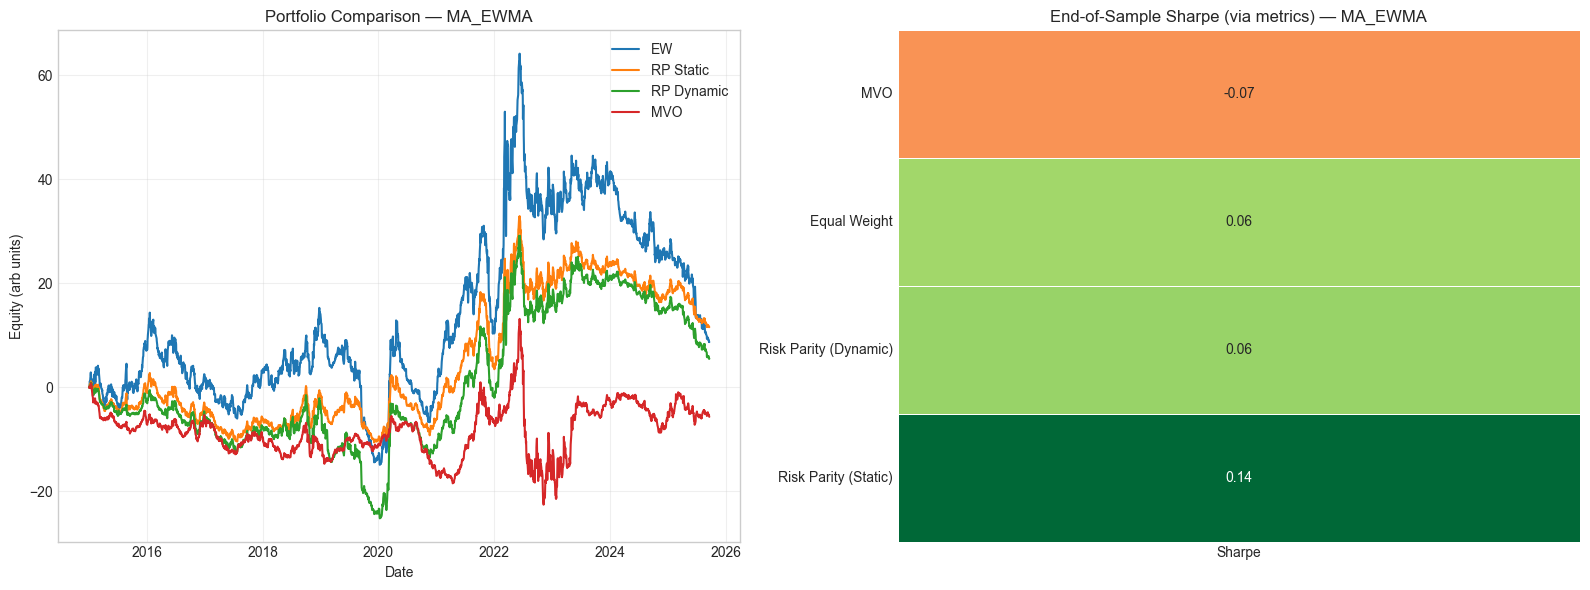


Quarterly average weights (head):


Propane  Ethane  Butane    WTI  Brent   ULSD   RBOB  Gasoil  \
Dates                                                                     
2015-03-31   0.1111  0.1111  0.1111 0.1111 0.1111 0.1111 0.1111  0.1111   
2015-06-30   0.1111  0.1111  0.1111 0.1111 0.1111 0.1111 0.1111  0.1111   
2015-09-30   0.1111  0.1111  0.1111 0.1111 0.1111 0.1111 0.1111  0.1111   
2015-12-31   0.1111  0.1111  0.1111 0.1111 0.1111 0.1111 0.1111  0.1111   

            Natgas  
Dates               
2015-03-31  0.1111  
2015-06-30  0.1111  
2015-09-30  0.1111  
2015-12-31  0.1111

Brent  Butane  Ethane  Gasoil  Natgas  Propane   RBOB   ULSD  \
Dates                                                                      
2015-03-31 0.0492  0.1239  0.3559  0.0406  0.1613   0.1341 0.0471 0.0379   
2015-06-30 0.0492  0.1239  0.3559  0.0406  0.1613   0.1341 0.0471 0.0379   
2015-09-30 0.0492  0.1239  0.3559  0.0406  0.1613   0.1341 0.0471 0.0379   
2015-12-31 0.0492  0.1239  0.3559  0.0406  0.1613   0.1341 0.0471 0.0379   

              WTI  
Dates              
2015-03-31 0.0500  
2015-06-30 0.0500  
2015-09-30 0.0500  
2015-12-31 0.0500

Brent  Butane  Ethane  Gasoil  Natgas  Propane   RBOB   ULSD  \
Dates                                                                      
2015-03-31 0.0000  0.1091  0.4690  0.0537  0.1972   0.1287 0.0000 0.0423   
2015-06-30 0.0000  0.1091  0.4690  0.0537  0.1972   0.1287 0.0000 0.0423   
2015-09-30 0.0000  0.1091  0.4690  0.0537  0.1972   0.1287 0.0000 0.0423   
2015-12-31 0.0000  0.1091  0.4690  0.0537  0.1972   0.1287 0.0000 0.0423   

              WTI  
Dates              
2015-03-31 0.0000  
2015-06-30 0.0000  
2015-09-30 0.0000  
2015-12-31 0.0000

Brent  Butane  Ethane  Gasoil  Natgas  Propane   RBOB   ULSD  \
Dates                                                                      
2015-03-31 0.0157  0.1760  0.3757  0.0055  0.3757   0.0000 0.0300 0.0044   
2015-06-30 0.0157  0.1760  0.3757  0.0055  0.3757   0.0000 0.0300 0.0044   
2015-09-30 0.0157  0.1760  0.3757  0.0055  0.3757   0.0000 0.0300 0.0044   
2015-12-31 0.0157  0.1760  0.3757  0.0055  0.3757   0.0000 0.0300 0.0044   

              WTI  
Dates              
2015-03-31 0.0169  
2015-06-30 0.0169  
2015-09-30 0.0169  
2015-12-31 0.0169

In [14]:
# ---------------------------------------------------------------------
# MA (EWMA) portfolios — strategy-specific risk from EWMA MA only
# ---------------------------------------------------------------------

# Traded PnL and risk/μ bases (all MA EWMA)
PNL_MAT   = MA_PNL_EWMA
MAT_LABEL = "MA_EWMA"
RISK_BASIS = PNL_MAT
MU_BASIS   = PNL_MAT

# --- Helpers ---
def _quarterly_avg_weights(res_dict: dict) -> pd.DataFrame:
    return res_dict["weights_daily"].resample("Q").mean()

def _print_weights_summary(name: str, Wq: pd.DataFrame, k: int = 5):
    if Wq.empty:
        print(f"[{name}] No weights to summarize."); return
    last_q = Wq.index[-1]
    top_last = Wq.loc[last_q].sort_values(ascending=False).head(k)
    overall = Wq.mean().sort_values(ascending=False).head(k)
    print(f"\n[{name}] Top {k} weights in last quarter ({last_q.date()}):")
    display(top_last.to_frame("weight").T)
    print(f"[{name}] Top {k} average weights across all quarters:")
    display(overall.to_frame("avg_weight").T)

def _portfolio_to_metrics_df(res_dict: dict) -> pd.DataFrame:
    df = pd.DataFrame({
        "daily_pnl": res_dict["pnl"],
        "t_cost": 0.0,              # already net in res_dict["pnl"]
    })
    df["net_pnl"]     = df["daily_pnl"]
    df["roll_flag"]   = 0
    df["equity_line"] = df["net_pnl"].cumsum()
    return df

def _extract_sharpe(mdict: dict) -> float:
    for k in ("sharpe", "Sharpe", "sharpe_ratio", "Sharpe Ratio"):
        if k in mdict:
            return float(mdict[k])
    return np.nan

# =====================================================================
# 1) Equal Weight (constant 1/N)
# =====================================================================
EW_RES = equal_weight_static(PNL_MAT, use_all_columns=True)
EW_WQ  = _quarterly_avg_weights(EW_RES)
_print_weights_summary("EW static (MA_EWMA)", EW_WQ)
EW_MET = metrics(_portfolio_to_metrics_df(EW_RES), contracts=1, units=1)

# =====================================================================
# 2) Risk Parity (Static) — Σ from MA_EWMA
# =====================================================================
RP_STATIC_RES = risk_parity_static(
    PNL_MAT,
    risk_basis=RISK_BASIS,
    long_only=True,
)
RP_STATIC_WQ  = _quarterly_avg_weights(RP_STATIC_RES)
_print_weights_summary("RP static (MA_EWMA)", RP_STATIC_WQ)
RP_STATIC_MET = metrics(_portfolio_to_metrics_df(RP_STATIC_RES), contracts=1, units=1)

# =====================================================================
# 3) Risk Parity (Dynamic, 1y LB, Quarterly) — Σ from MA_EWMA
# =====================================================================
RP_DYN_RES = risk_parity_dynamic(
    PNL_MAT,
    risk_basis=RISK_BASIS,
    lookback=252,
    freq="Q",
    long_only=True,
)
RP_DYN_WQ = _quarterly_avg_weights(RP_DYN_RES)
_print_weights_summary("RP dynamic (MA_EWMA)", RP_DYN_WQ)
RP_DYN_MET = metrics(_portfolio_to_metrics_df(RP_DYN_RES), contracts=1, units=1)

# =====================================================================
# 4) MVO (1y LB, Monthly, long-only, 30% cap) — Σ, μ from MA_EWMA
# =====================================================================
MVO_RES = mvo(
    PNL_MAT,
    risk_basis=RISK_BASIS,
    mu_basis=MU_BASIS,
    lookback=252,
    freq="M",
    long_only=True,
    cap=0.30,
    gamma=5.0,
)
MVO_WQ = _quarterly_avg_weights(MVO_RES)
_print_weights_summary("MVO (MA_EWMA)", MVO_WQ)
MVO_MET = metrics(_portfolio_to_metrics_df(MVO_RES), contracts=1, units=1)

# =====================================================================
# 5) Combined Equity + Seaborn Sharpe Heatmap (metrics-based)
# =====================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Equity comparison ---
axes[0].plot(EW_RES["equity"],        label="EW")
axes[0].plot(RP_STATIC_RES["equity"], label="RP Static")
axes[0].plot(RP_DYN_RES["equity"],    label="RP Dynamic")
axes[0].plot(MVO_RES["equity"],       label="MVO")
axes[0].set_title(f"Portfolio Comparison — {MAT_LABEL}")
axes[0].set_xlabel("Date"); axes[0].set_ylabel("Equity (arb units)")
axes[0].grid(alpha=0.3); axes[0].legend()

# --- Sharpe from metrics() ---
sh_df = pd.DataFrame({
    "Sharpe": [
        _extract_sharpe(EW_MET),
        _extract_sharpe(RP_STATIC_MET),
        _extract_sharpe(RP_DYN_MET),
        _extract_sharpe(MVO_MET),
    ]
}, index=["Equal Weight", "Risk Parity (Static)", "Risk Parity (Dynamic)", "MVO"])

sns.heatmap(
    sh_df.sort_values("Sharpe", ascending=True),
    annot=True, fmt=".2f",
    cmap=sns.color_palette("RdYlGn", as_cmap=True),
    center=0,
    linewidths=0.5,
    cbar=False,
    ax=axes[1],
)
axes[1].set_title("End-of-Sample Sharpe (via metrics) — MA_EWMA")
axes[1].set_xlabel(""); axes[1].set_ylabel("")

fig.tight_layout()
plt.show()

print("\nQuarterly average weights (head):")
display(EW_WQ.head(4))
display(RP_STATIC_WQ.head(4))
display(RP_DYN_WQ.head(4))
display(MVO_WQ.head(4))


### MA Dynamic Risk Parity

### MA MVO

## Carry Portfolios

### Carry Equally Weighted

### Carry Risk Parity

### Carry MVO

# Stat-Arb